In [1]:
#loading the packages, and the version for the main packages are inclued.
#Please use the same version packages to replicate the project.
# Tensorflow 1.14.0.
# Cuda 10.0 
# skimage 0.15.0.
# scikit-learn 0.21.3.
# keras  2.3.0.
# numpy 1.16.5.
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
%matplotlib inline

Using TensorFlow backend.


In [111]:
# Set some parameters
# You can make a change for the numbers of pixels and channel regarding to your project. 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
# set the train and test path
# Test path usually is used to predict the output for the images
TRAIN_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/train/'
# TEST_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/test/'
TEST_PATH = 'C:/Users/mxie3/Downloads/unet-master/data/membrane/imagechunck/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

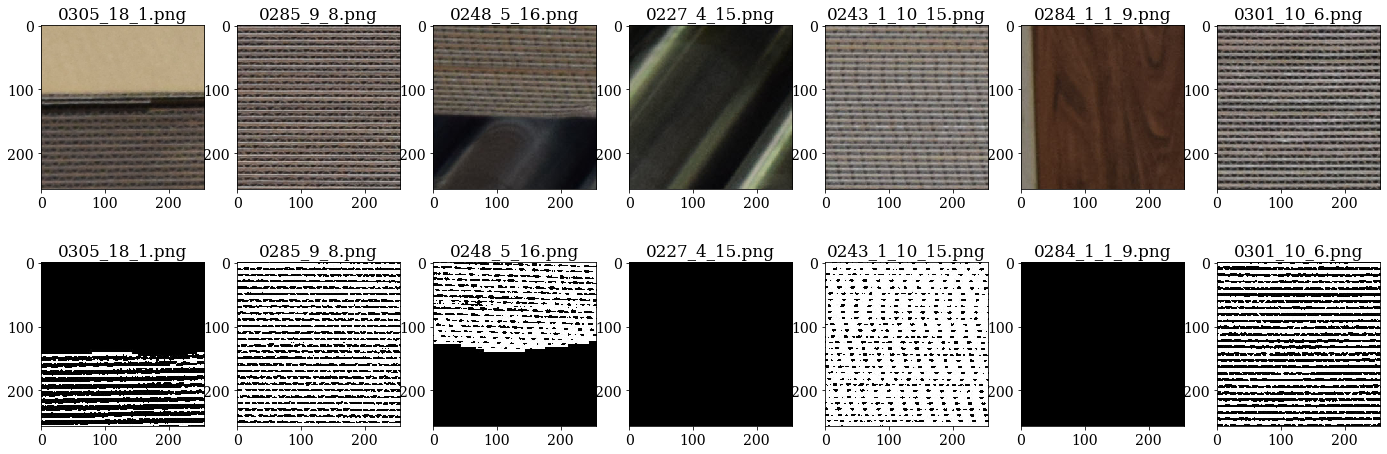

In [35]:
#set the train_image_path and train_mask_path where your images and labels for images are sitting.
# The paths are setted as below:
# train_image_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/image/"
# train_mask_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/label/"
# Radomly sample some data to double check the data quality.
train_image_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/image/"
train_mask_path = "C:/Users/mxie3/Downloads/unet-master/data/membrane/train/label/"
 
image_array = []
 
for root, dirs, files in os.walk(train_image_path): 
    image_array = files

col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(image_array)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(24,8))  
 
for row in range(0,row_size): 
    image_index = 0
    if (row==0): 
        da_path= train_image_path
    else: 
        da_path= train_mask_path
 
    for col in range(0,col_size):
        img = load_img(da_path+image_array[rand_id_array[image_index]])
        ax[row][col].imshow(img)
        ax[row][col].set_title(image_array[rand_id_array[image_index]])
        image_index += 1
plt.show()

In [112]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[0]
print(train_ids)
print(test_ids)

li=[x.split('.')[0] for x in os.listdir(os.path.join(TRAIN_PATH, next(os.walk(TRAIN_PATH))[1][1])) ]

lione=[x.split('.')[0] for x in os.listdir(TEST_PATH)]


['image', 'label']
C:/Users/mxie3/Downloads/unet-master/data/membrane/imagechunck/


Get the data
Let's first import all the images and associated masks. 
I downsample both the training and test images to keep things light and manageable,
but we need to keep a record of the original sizes of the test images to upsample 
our predicted masks and create correct run-length encodings later on. 
There are definitely better ways to handle this, but it works fine for now!

In [113]:
# Get and resize train images and masks
# Set the dtype as np.float32
X_train = np.zeros((len(li), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(li), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(li), total=len(li)):
    path = TRAIN_PATH 
    img = imread(path + '/image/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img/255
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1),dtype=np.float32)
    mask_ = imread(path + '/label/' + id_ + '.png')
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask/255

    #mask = img_to_array(load_img(path + '/label/' + id_ + '.png', grayscale=True))
    #mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
    #Y_train[n] = mask
    
# Get and resize test images
X_test = np.zeros((len(lione), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(lione), total=len(test_ids)):
    path = TEST_PATH 
    img = imread(path + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img/255
print('Done!')

Getting and resizing train images and masks ... 



  5%|████▏                                                                          | 392/7456 [00:07<02:06, 55.76it/s]


 11%|████████▋                                                                      | 816/7456 [00:15<01:57, 56.74it/s]


 17%|████████████▉                                                                 | 1240/7456 [00:23<01:47, 57.93it/s]


 22%|█████████████████▍                                                            | 1664/7456 [00:30<01:51, 52.05it/s]


 28%|█████████████████████▋                                                        | 2078/7456 [00:38<01:50, 48.63it/s]


 33%|██████████████████████████                                                    | 2491/7456 [00:46<01:43, 48.09it/s]


 39%|██████████████████████████████▍                                               | 2904/7456 [00:54<01:22, 55.00it/s]


 45%|██████████████████████████████████▊                                           | 3323/7456 [01:02<01:14, 55.33it/s]


 50%|███████████████████████████████████████                                       | 3732/7456 [01:09<01:04, 57.63it/s]


 56%|███████████████████████████████████████████▍                                  | 4151/7456 [01:17<00:56, 58.47it/s]


 61%|███████████████████████████████████████████████▊                              | 4576/7456 [01:25<00:52, 55.09it/s]


 67%|████████████████████████████████████████████████████▏                         | 4994/7456 [01:33<00:45, 54.24it/s]


 73%|████████████████████████████████████████████████████████▋                     | 5418/7456 [01:40<00:35, 57.99it/s]


 78%|█████████████████████████████████████████████████████████████                 | 5837/7456 [01:48<00:33, 47.87it/s]


 84%|█████████████████████████████████████████████████████████████████▍            | 6258/7456 [01:56<00:21, 55.39it/s]


 90%|█████████████████████████████████████████████████████████████████████▊        | 6677/7456 [02:03<00:15, 50.29it/s]


 95%|██████████████████████████████████████████████████████████████████████████▎   | 7099/7456 [02:11<00:06, 53.67it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 7456/7456 [02:18<00:00, 53.88it/s]


Getting and resizing test images ... 



 94%|████████████████████████████████████████████████████████████████████████████▊     | 59/63 [00:01<00:00, 39.32it/s]
64it [00:01, 40.43it/s]                                                                                                
69it [00:01, 39.71it/s]
74it [00:01, 40.71it/s]
79it [00:01, 39.38it/s]
84it [00:02, 40.33it/s]
89it [00:02, 39.64it/s]
94it [00:02, 40.62it/s]
99it [00:02, 39.65it/s]
104it [00:02, 40.27it/s]
109it [00:02, 41.14it/s]
114it [00:02, 40.14it/s]
119it [00:02, 41.04it/s]
124it [00:03, 38.13it/s]
128it [00:03, 37.01it/s]
132it [00:03, 34.78it/s]
136it [00:03, 36.16it/s]
140it [00:03, 37.20it/s]
144it [00:03, 36.19it/s]
148it [00:03, 37.01it/s]
152it [00:03, 37.84it/s]
157it [00:04, 39.13it/s]
161it [00:04, 36.07it/s]
166it [00:04, 37.97it/s]
171it [00:04, 38.02it/s]
176it [00:04, 39.88it/s]
181it [00:04, 39.81it/s]
186it [00:04, 39.29it/s]
190it [00:04, 39.46it/s]
195it [00:04, 40.54it/s]
200it [00:05, 40.72it/s]
205it [00:05, 39.86it/s]
210it [00:05, 39

1266it [00:32, 40.58it/s]
1271it [00:32, 40.74it/s]
1276it [00:32, 39.87it/s]
1281it [00:32, 40.84it/s]
1286it [00:32, 39.98it/s]
1291it [00:32, 40.27it/s]
1296it [00:32, 41.13it/s]
1301it [00:32, 40.18it/s]
1306it [00:33, 41.02it/s]
1311it [00:33, 38.11it/s]
1315it [00:33, 38.62it/s]
1319it [00:33, 37.31it/s]
1323it [00:33, 38.04it/s]
1328it [00:33, 39.43it/s]
1332it [00:33, 39.56it/s]
1336it [00:33, 39.65it/s]
1340it [00:33, 38.00it/s]
1344it [00:34, 38.54it/s]
1349it [00:34, 37.93it/s]
1354it [00:34, 39.30it/s]
1359it [00:34, 40.42it/s]
1364it [00:34, 39.71it/s]
1369it [00:34, 40.72it/s]
1374it [00:34, 39.33it/s]
1378it [00:34, 37.80it/s]
1383it [00:35, 39.30it/s]
1388it [00:35, 38.94it/s]
1392it [00:35, 36.86it/s]
1396it [00:35, 37.71it/s]
1401it [00:35, 37.84it/s]
1405it [00:35, 38.20it/s]
1409it [00:35, 38.68it/s]
1414it [00:35, 38.52it/s]
1418it [00:35, 38.91it/s]
1422it [00:36, 39.19it/s]
1427it [00:36, 40.34it/s]
1432it [00:36, 40.58it/s]
1437it [00:36, 39.81it/s]
1441it [00:3

2730it [01:09, 39.96it/s]
2735it [01:09, 40.26it/s]
2740it [01:09, 39.55it/s]
2745it [01:09, 40.60it/s]
2750it [01:09, 39.83it/s]
2754it [01:09, 39.84it/s]
2759it [01:10, 40.22it/s]
2764it [01:10, 39.54it/s]
2768it [01:10, 39.63it/s]
2772it [01:10, 39.70it/s]
2777it [01:10, 40.71it/s]
2782it [01:10, 39.90it/s]
2787it [01:10, 40.17it/s]
2792it [01:10, 39.49it/s]
2797it [01:11, 40.56it/s]
2802it [01:11, 39.80it/s]
2806it [01:11, 39.82it/s]
2811it [01:11, 40.16it/s]
2816it [01:11, 41.05it/s]
2821it [01:11, 40.13it/s]
2826it [01:11, 39.51it/s]
2830it [01:11, 37.22it/s]
2834it [01:11, 37.97it/s]
2838it [01:12, 36.90it/s]
2843it [01:12, 38.61it/s]
2848it [01:12, 38.47it/s]
2853it [01:12, 38.10it/s]
2857it [01:12, 38.28it/s]
2861it [01:12, 38.75it/s]
2865it [01:12, 39.07it/s]
2870it [01:12, 40.24it/s]
2875it [01:13, 39.59it/s]
2880it [01:13, 40.63it/s]
2885it [01:13, 39.23it/s]
2889it [01:13, 39.42it/s]
2894it [01:13, 40.50it/s]
2899it [01:13, 39.72it/s]
2904it [01:13, 39.23it/s]
2908it [01:1

Done!


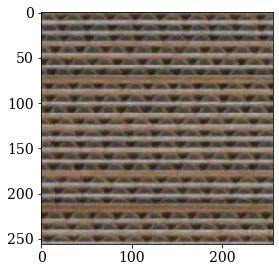

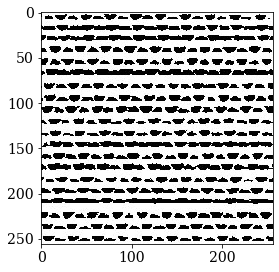

In [38]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

Create our Keras metric
Now we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so We tried to implement this. We're by no means certain that this implementation is correct, though! Any assistance in verifying this would be most welcome!
Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [39]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / ( union + smooth)
    return iou

In [41]:
# Build U-Net model
# The parameters can be ajusted based upon your project needs
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.2) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.2) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.2) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.2) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.2) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou])

# print out the model summary to double check the pramaters for the model
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 256, 256, 16) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 16) 2320        dropout_10[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 16) 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 256, 256, 16) 2320        dropout_18[0][0]                 
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 1)  17          conv2d_37[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


In [42]:
# Fit model and calculate the running time
import timeit

start = timeit.default_timer()

earlystopper = EarlyStopping(patience=20, verbose=1)

# save the model check point, please note the defaut path is where your jupernotebook running
# For other paramerters such as epochs, batch_size etc., you can ajust them based upon what your project needs.

checkpointer = ModelCheckpoint('model-log080623iou.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=30, epochs=150, 
                    callbacks=[earlystopper, checkpointer])

stop = timeit.default_timer()

print('Time: ', stop - start)  


Train on 6710 samples, validate on 746 samples
Epoch 1/150


6390/6710 [===========================>..] - ETA: 4:18 - loss: 0.7804 - iou: 0.716 - ETA: 2:33 - loss: 0.7613 - iou: 0.713 - ETA: 1:58 - loss: 0.7484 - iou: 0.712 - ETA: 1:39 - loss: 0.7342 - iou: 0.714 - ETA: 1:29 - loss: 0.7273 - iou: 0.714 - ETA: 1:22 - loss: 0.7148 - iou: 0.716 - ETA: 1:16 - loss: 0.7024 - iou: 0.719 - ETA: 1:12 - loss: 0.6893 - iou: 0.723 - ETA: 1:09 - loss: 0.6847 - iou: 0.724 - ETA: 1:07 - loss: 0.6738 - iou: 0.727 - ETA: 1:05 - loss: 0.6661 - iou: 0.730 - ETA: 1:03 - loss: 0.6608 - iou: 0.733 - ETA: 1:01 - loss: 0.6516 - iou: 0.736 - ETA: 1:00 - loss: 0.6430 - iou: 0.739 - ETA: 59s - loss: 0.6385 - iou: 0.742 - ETA: 58s - loss: 0.6309 - iou: 0.74 - ETA: 57s - loss: 0.6233 - iou: 0.74 - ETA: 56s - loss: 0.6132 - iou: 0.75 - ETA: 55s - loss: 0.6054 - iou: 0.75 - ETA: 54s - loss: 0.5948 - iou: 0.76 - ETA: 53s - loss: 0.5878 - iou: 0.76 - ETA: 53s - loss: 0.5794 - iou: 0.76 - ETA: 52s - loss: 0.5736 - iou: 0.77 - ETA: 51s - loss: 0.5671 - iou: 0.77 - ETA: 51s - los

6710/6710 [==============================] - ETA: 2s - loss: 0.2895 - iou: 0.893 - ETA: 1s - loss: 0.2894 - iou: 0.893 - ETA: 1s - loss: 0.2889 - iou: 0.893 - ETA: 1s - loss: 0.2885 - iou: 0.893 - ETA: 1s - loss: 0.2882 - iou: 0.893 - ETA: 1s - loss: 0.2880 - iou: 0.893 - ETA: 0s - loss: 0.2876 - iou: 0.893 - ETA: 0s - loss: 0.2870 - iou: 0.894 - ETA: 0s - loss: 0.2867 - iou: 0.894 - ETA: 0s - loss: 0.2864 - iou: 0.894 - 54s 8ms/step - loss: 0.2861 - iou: 0.8945 - val_loss: 0.2307 - val_iou: 0.9377

Epoch 00001: val_loss improved from inf to 0.23074, saving model to model-log080623iou.h5
Epoch 2/150


6450/6710 [===========================>..] - ETA: 46s - loss: 0.1838 - iou: 0.93 - ETA: 46s - loss: 0.2123 - iou: 0.92 - ETA: 47s - loss: 0.1921 - iou: 0.93 - ETA: 47s - loss: 0.1978 - iou: 0.93 - ETA: 46s - loss: 0.1932 - iou: 0.93 - ETA: 47s - loss: 0.1836 - iou: 0.93 - ETA: 47s - loss: 0.1823 - iou: 0.93 - ETA: 46s - loss: 0.1873 - iou: 0.93 - ETA: 46s - loss: 0.1900 - iou: 0.93 - ETA: 46s - loss: 0.1922 - iou: 0.93 - ETA: 46s - loss: 0.1908 - iou: 0.93 - ETA: 46s - loss: 0.1912 - iou: 0.93 - ETA: 46s - loss: 0.1877 - iou: 0.93 - ETA: 46s - loss: 0.1850 - iou: 0.93 - ETA: 45s - loss: 0.1876 - iou: 0.93 - ETA: 45s - loss: 0.1884 - iou: 0.93 - ETA: 45s - loss: 0.1899 - iou: 0.93 - ETA: 45s - loss: 0.1923 - iou: 0.93 - ETA: 45s - loss: 0.1925 - iou: 0.93 - ETA: 44s - loss: 0.1904 - iou: 0.93 - ETA: 44s - loss: 0.1900 - iou: 0.93 - ETA: 44s - loss: 0.1896 - iou: 0.93 - ETA: 44s - loss: 0.1941 - iou: 0.93 - ETA: 44s - loss: 0.1931 - iou: 0.93 - ETA: 43s - loss: 0.1935 - iou: 0.93 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1809 - iou: 0.936 - ETA: 1s - loss: 0.1809 - iou: 0.936 - ETA: 1s - loss: 0.1808 - iou: 0.936 - ETA: 1s - loss: 0.1808 - iou: 0.936 - ETA: 0s - loss: 0.1807 - iou: 0.936 - ETA: 0s - loss: 0.1808 - iou: 0.936 - ETA: 0s - loss: 0.1809 - iou: 0.936 - ETA: 0s - loss: 0.1807 - iou: 0.936 - 52s 8ms/step - loss: 0.1807 - iou: 0.9362 - val_loss: 0.2902 - val_iou: 0.9261

Epoch 00002: val_loss did not improve from 0.23074
Epoch 3/150


6450/6710 [===========================>..] - ETA: 52s - loss: 0.1575 - iou: 0.94 - ETA: 50s - loss: 0.1801 - iou: 0.93 - ETA: 49s - loss: 0.1759 - iou: 0.93 - ETA: 49s - loss: 0.1871 - iou: 0.93 - ETA: 49s - loss: 0.1854 - iou: 0.93 - ETA: 49s - loss: 0.1837 - iou: 0.93 - ETA: 48s - loss: 0.1866 - iou: 0.93 - ETA: 48s - loss: 0.1865 - iou: 0.93 - ETA: 47s - loss: 0.1857 - iou: 0.93 - ETA: 47s - loss: 0.1817 - iou: 0.93 - ETA: 47s - loss: 0.1798 - iou: 0.93 - ETA: 46s - loss: 0.1786 - iou: 0.93 - ETA: 46s - loss: 0.1756 - iou: 0.93 - ETA: 46s - loss: 0.1765 - iou: 0.93 - ETA: 46s - loss: 0.1776 - iou: 0.93 - ETA: 46s - loss: 0.1773 - iou: 0.93 - ETA: 46s - loss: 0.1807 - iou: 0.93 - ETA: 45s - loss: 0.1797 - iou: 0.93 - ETA: 45s - loss: 0.1796 - iou: 0.93 - ETA: 45s - loss: 0.1795 - iou: 0.93 - ETA: 45s - loss: 0.1780 - iou: 0.93 - ETA: 44s - loss: 0.1804 - iou: 0.93 - ETA: 44s - loss: 0.1806 - iou: 0.93 - ETA: 44s - loss: 0.1792 - iou: 0.93 - ETA: 44s - loss: 0.1804 - iou: 0.93 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1706 - iou: 0.939 - ETA: 1s - loss: 0.1704 - iou: 0.939 - ETA: 1s - loss: 0.1703 - iou: 0.939 - ETA: 1s - loss: 0.1704 - iou: 0.939 - ETA: 0s - loss: 0.1705 - iou: 0.939 - ETA: 0s - loss: 0.1706 - iou: 0.939 - ETA: 0s - loss: 0.1705 - iou: 0.939 - ETA: 0s - loss: 0.1704 - iou: 0.940 - 52s 8ms/step - loss: 0.1704 - iou: 0.9400 - val_loss: 0.1793 - val_iou: 0.9483

Epoch 00003: val_loss improved from 0.23074 to 0.17933, saving model to model-log080623iou.h5
Epoch 4/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.1188 - iou: 0.95 - ETA: 48s - loss: 0.1490 - iou: 0.95 - ETA: 48s - loss: 0.1540 - iou: 0.94 - ETA: 48s - loss: 0.1561 - iou: 0.94 - ETA: 48s - loss: 0.1581 - iou: 0.94 - ETA: 48s - loss: 0.1613 - iou: 0.94 - ETA: 47s - loss: 0.1640 - iou: 0.94 - ETA: 47s - loss: 0.1590 - iou: 0.94 - ETA: 47s - loss: 0.1599 - iou: 0.94 - ETA: 47s - loss: 0.1580 - iou: 0.94 - ETA: 47s - loss: 0.1592 - iou: 0.94 - ETA: 47s - loss: 0.1586 - iou: 0.94 - ETA: 47s - loss: 0.1549 - iou: 0.94 - ETA: 46s - loss: 0.1555 - iou: 0.94 - ETA: 46s - loss: 0.1554 - iou: 0.94 - ETA: 46s - loss: 0.1543 - iou: 0.94 - ETA: 46s - loss: 0.1539 - iou: 0.94 - ETA: 45s - loss: 0.1535 - iou: 0.94 - ETA: 45s - loss: 0.1531 - iou: 0.94 - ETA: 45s - loss: 0.1532 - iou: 0.94 - ETA: 45s - loss: 0.1531 - iou: 0.94 - ETA: 45s - loss: 0.1551 - iou: 0.94 - ETA: 44s - loss: 0.1546 - iou: 0.94 - ETA: 44s - loss: 0.1549 - iou: 0.94 - ETA: 44s - loss: 0.1542 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1619 - iou: 0.943 - ETA: 1s - loss: 0.1621 - iou: 0.942 - ETA: 1s - loss: 0.1621 - iou: 0.942 - ETA: 1s - loss: 0.1622 - iou: 0.942 - ETA: 0s - loss: 0.1622 - iou: 0.942 - ETA: 0s - loss: 0.1621 - iou: 0.942 - ETA: 0s - loss: 0.1620 - iou: 0.942 - ETA: 0s - loss: 0.1619 - iou: 0.942 - 52s 8ms/step - loss: 0.1619 - iou: 0.9429 - val_loss: 0.1874 - val_iou: 0.9463

Epoch 00004: val_loss did not improve from 0.17933
Epoch 5/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1658 - iou: 0.94 - ETA: 49s - loss: 0.1655 - iou: 0.94 - ETA: 49s - loss: 0.1614 - iou: 0.94 - ETA: 49s - loss: 0.1607 - iou: 0.94 - ETA: 48s - loss: 0.1622 - iou: 0.94 - ETA: 48s - loss: 0.1656 - iou: 0.94 - ETA: 48s - loss: 0.1630 - iou: 0.94 - ETA: 48s - loss: 0.1682 - iou: 0.94 - ETA: 48s - loss: 0.1746 - iou: 0.94 - ETA: 47s - loss: 0.1725 - iou: 0.94 - ETA: 47s - loss: 0.1726 - iou: 0.94 - ETA: 47s - loss: 0.1724 - iou: 0.94 - ETA: 47s - loss: 0.1733 - iou: 0.94 - ETA: 46s - loss: 0.1723 - iou: 0.94 - ETA: 46s - loss: 0.1707 - iou: 0.94 - ETA: 46s - loss: 0.1707 - iou: 0.94 - ETA: 45s - loss: 0.1683 - iou: 0.94 - ETA: 45s - loss: 0.1680 - iou: 0.94 - ETA: 45s - loss: 0.1667 - iou: 0.94 - ETA: 45s - loss: 0.1660 - iou: 0.94 - ETA: 45s - loss: 0.1666 - iou: 0.94 - ETA: 44s - loss: 0.1651 - iou: 0.94 - ETA: 44s - loss: 0.1647 - iou: 0.94 - ETA: 44s - loss: 0.1664 - iou: 0.94 - ETA: 44s - loss: 0.1658 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1598 - iou: 0.943 - ETA: 1s - loss: 0.1599 - iou: 0.943 - ETA: 1s - loss: 0.1601 - iou: 0.943 - ETA: 1s - loss: 0.1599 - iou: 0.943 - ETA: 0s - loss: 0.1597 - iou: 0.943 - ETA: 0s - loss: 0.1595 - iou: 0.944 - ETA: 0s - loss: 0.1595 - iou: 0.944 - ETA: 0s - loss: 0.1596 - iou: 0.944 - 52s 8ms/step - loss: 0.1596 - iou: 0.9440 - val_loss: 0.2190 - val_iou: 0.9441

Epoch 00005: val_loss did not improve from 0.17933
Epoch 6/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1714 - iou: 0.94 - ETA: 49s - loss: 0.1801 - iou: 0.94 - ETA: 49s - loss: 0.1843 - iou: 0.94 - ETA: 49s - loss: 0.1777 - iou: 0.94 - ETA: 49s - loss: 0.1713 - iou: 0.94 - ETA: 49s - loss: 0.1796 - iou: 0.93 - ETA: 48s - loss: 0.1722 - iou: 0.94 - ETA: 47s - loss: 0.1750 - iou: 0.94 - ETA: 47s - loss: 0.1706 - iou: 0.94 - ETA: 47s - loss: 0.1700 - iou: 0.94 - ETA: 47s - loss: 0.1694 - iou: 0.94 - ETA: 47s - loss: 0.1705 - iou: 0.94 - ETA: 46s - loss: 0.1719 - iou: 0.94 - ETA: 46s - loss: 0.1716 - iou: 0.94 - ETA: 46s - loss: 0.1708 - iou: 0.94 - ETA: 46s - loss: 0.1693 - iou: 0.94 - ETA: 46s - loss: 0.1688 - iou: 0.94 - ETA: 45s - loss: 0.1680 - iou: 0.94 - ETA: 45s - loss: 0.1676 - iou: 0.94 - ETA: 45s - loss: 0.1694 - iou: 0.94 - ETA: 45s - loss: 0.1676 - iou: 0.94 - ETA: 45s - loss: 0.1673 - iou: 0.94 - ETA: 44s - loss: 0.1699 - iou: 0.94 - ETA: 44s - loss: 0.1682 - iou: 0.94 - ETA: 44s - loss: 0.1680 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1580 - iou: 0.944 - ETA: 1s - loss: 0.1578 - iou: 0.944 - ETA: 1s - loss: 0.1578 - iou: 0.944 - ETA: 1s - loss: 0.1577 - iou: 0.944 - ETA: 0s - loss: 0.1578 - iou: 0.944 - ETA: 0s - loss: 0.1578 - iou: 0.944 - ETA: 0s - loss: 0.1577 - iou: 0.944 - ETA: 0s - loss: 0.1577 - iou: 0.944 - 52s 8ms/step - loss: 0.1578 - iou: 0.9446 - val_loss: 0.2293 - val_iou: 0.9431

Epoch 00006: val_loss did not improve from 0.17933
Epoch 7/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1471 - iou: 0.95 - ETA: 49s - loss: 0.1646 - iou: 0.94 - ETA: 48s - loss: 0.1478 - iou: 0.95 - ETA: 48s - loss: 0.1432 - iou: 0.95 - ETA: 48s - loss: 0.1481 - iou: 0.95 - ETA: 48s - loss: 0.1472 - iou: 0.95 - ETA: 47s - loss: 0.1435 - iou: 0.95 - ETA: 48s - loss: 0.1434 - iou: 0.95 - ETA: 47s - loss: 0.1420 - iou: 0.95 - ETA: 47s - loss: 0.1422 - iou: 0.95 - ETA: 47s - loss: 0.1411 - iou: 0.95 - ETA: 47s - loss: 0.1439 - iou: 0.94 - ETA: 46s - loss: 0.1413 - iou: 0.95 - ETA: 46s - loss: 0.1418 - iou: 0.95 - ETA: 46s - loss: 0.1420 - iou: 0.95 - ETA: 46s - loss: 0.1395 - iou: 0.95 - ETA: 46s - loss: 0.1407 - iou: 0.95 - ETA: 45s - loss: 0.1443 - iou: 0.94 - ETA: 45s - loss: 0.1438 - iou: 0.94 - ETA: 45s - loss: 0.1453 - iou: 0.94 - ETA: 44s - loss: 0.1475 - iou: 0.94 - ETA: 44s - loss: 0.1486 - iou: 0.94 - ETA: 44s - loss: 0.1497 - iou: 0.94 - ETA: 44s - loss: 0.1511 - iou: 0.94 - ETA: 44s - loss: 0.1518 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1535 - iou: 0.946 - ETA: 1s - loss: 0.1535 - iou: 0.946 - ETA: 1s - loss: 0.1534 - iou: 0.946 - ETA: 1s - loss: 0.1534 - iou: 0.946 - ETA: 0s - loss: 0.1536 - iou: 0.946 - ETA: 0s - loss: 0.1534 - iou: 0.946 - ETA: 0s - loss: 0.1537 - iou: 0.946 - ETA: 0s - loss: 0.1537 - iou: 0.946 - 52s 8ms/step - loss: 0.1536 - iou: 0.9461 - val_loss: 0.2186 - val_iou: 0.9421

Epoch 00007: val_loss did not improve from 0.17933
Epoch 8/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1552 - iou: 0.94 - ETA: 46s - loss: 0.1681 - iou: 0.93 - ETA: 48s - loss: 0.1553 - iou: 0.94 - ETA: 47s - loss: 0.1459 - iou: 0.94 - ETA: 48s - loss: 0.1464 - iou: 0.94 - ETA: 48s - loss: 0.1497 - iou: 0.94 - ETA: 48s - loss: 0.1553 - iou: 0.94 - ETA: 48s - loss: 0.1554 - iou: 0.94 - ETA: 47s - loss: 0.1523 - iou: 0.94 - ETA: 47s - loss: 0.1520 - iou: 0.94 - ETA: 47s - loss: 0.1513 - iou: 0.94 - ETA: 47s - loss: 0.1540 - iou: 0.94 - ETA: 47s - loss: 0.1549 - iou: 0.94 - ETA: 47s - loss: 0.1558 - iou: 0.94 - ETA: 46s - loss: 0.1549 - iou: 0.94 - ETA: 46s - loss: 0.1548 - iou: 0.94 - ETA: 46s - loss: 0.1544 - iou: 0.94 - ETA: 46s - loss: 0.1562 - iou: 0.94 - ETA: 45s - loss: 0.1571 - iou: 0.94 - ETA: 45s - loss: 0.1572 - iou: 0.94 - ETA: 45s - loss: 0.1566 - iou: 0.94 - ETA: 45s - loss: 0.1559 - iou: 0.94 - ETA: 44s - loss: 0.1542 - iou: 0.94 - ETA: 44s - loss: 0.1542 - iou: 0.94 - ETA: 44s - loss: 0.1544 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1516 - iou: 0.946 - ETA: 1s - loss: 0.1515 - iou: 0.946 - ETA: 1s - loss: 0.1515 - iou: 0.946 - ETA: 1s - loss: 0.1513 - iou: 0.946 - ETA: 0s - loss: 0.1513 - iou: 0.946 - ETA: 0s - loss: 0.1514 - iou: 0.946 - ETA: 0s - loss: 0.1514 - iou: 0.946 - ETA: 0s - loss: 0.1513 - iou: 0.946 - 52s 8ms/step - loss: 0.1513 - iou: 0.9469 - val_loss: 0.1807 - val_iou: 0.9476

Epoch 00008: val_loss did not improve from 0.17933
Epoch 9/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.2021 - iou: 0.93 - ETA: 48s - loss: 0.1643 - iou: 0.94 - ETA: 48s - loss: 0.1534 - iou: 0.94 - ETA: 47s - loss: 0.1521 - iou: 0.94 - ETA: 47s - loss: 0.1642 - iou: 0.94 - ETA: 49s - loss: 0.1568 - iou: 0.94 - ETA: 49s - loss: 0.1598 - iou: 0.94 - ETA: 48s - loss: 0.1563 - iou: 0.94 - ETA: 48s - loss: 0.1551 - iou: 0.94 - ETA: 48s - loss: 0.1568 - iou: 0.94 - ETA: 47s - loss: 0.1579 - iou: 0.94 - ETA: 47s - loss: 0.1570 - iou: 0.94 - ETA: 47s - loss: 0.1547 - iou: 0.94 - ETA: 46s - loss: 0.1555 - iou: 0.94 - ETA: 46s - loss: 0.1587 - iou: 0.94 - ETA: 46s - loss: 0.1565 - iou: 0.94 - ETA: 46s - loss: 0.1567 - iou: 0.94 - ETA: 46s - loss: 0.1568 - iou: 0.94 - ETA: 45s - loss: 0.1559 - iou: 0.94 - ETA: 45s - loss: 0.1546 - iou: 0.94 - ETA: 45s - loss: 0.1544 - iou: 0.94 - ETA: 45s - loss: 0.1529 - iou: 0.94 - ETA: 44s - loss: 0.1519 - iou: 0.94 - ETA: 44s - loss: 0.1525 - iou: 0.94 - ETA: 44s - loss: 0.1531 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1490 - iou: 0.947 - ETA: 1s - loss: 0.1489 - iou: 0.947 - ETA: 1s - loss: 0.1490 - iou: 0.947 - ETA: 1s - loss: 0.1491 - iou: 0.947 - ETA: 0s - loss: 0.1492 - iou: 0.947 - ETA: 0s - loss: 0.1491 - iou: 0.947 - ETA: 0s - loss: 0.1491 - iou: 0.947 - ETA: 0s - loss: 0.1490 - iou: 0.947 - 52s 8ms/step - loss: 0.1490 - iou: 0.9478 - val_loss: 0.1703 - val_iou: 0.9494

Epoch 00009: val_loss improved from 0.17933 to 0.17027, saving model to model-log080623iou.h5
Epoch 10/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.1396 - iou: 0.94 - ETA: 48s - loss: 0.1364 - iou: 0.95 - ETA: 47s - loss: 0.1432 - iou: 0.95 - ETA: 48s - loss: 0.1391 - iou: 0.95 - ETA: 48s - loss: 0.1377 - iou: 0.95 - ETA: 48s - loss: 0.1370 - iou: 0.95 - ETA: 47s - loss: 0.1388 - iou: 0.95 - ETA: 47s - loss: 0.1397 - iou: 0.95 - ETA: 47s - loss: 0.1406 - iou: 0.95 - ETA: 47s - loss: 0.1425 - iou: 0.95 - ETA: 47s - loss: 0.1439 - iou: 0.95 - ETA: 46s - loss: 0.1425 - iou: 0.95 - ETA: 46s - loss: 0.1427 - iou: 0.95 - ETA: 46s - loss: 0.1433 - iou: 0.95 - ETA: 46s - loss: 0.1438 - iou: 0.95 - ETA: 46s - loss: 0.1420 - iou: 0.95 - ETA: 45s - loss: 0.1440 - iou: 0.95 - ETA: 45s - loss: 0.1437 - iou: 0.95 - ETA: 45s - loss: 0.1447 - iou: 0.95 - ETA: 45s - loss: 0.1443 - iou: 0.94 - ETA: 44s - loss: 0.1445 - iou: 0.94 - ETA: 44s - loss: 0.1452 - iou: 0.94 - ETA: 44s - loss: 0.1457 - iou: 0.94 - ETA: 44s - loss: 0.1453 - iou: 0.94 - ETA: 44s - loss: 0.1458 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1433 - iou: 0.949 - ETA: 1s - loss: 0.1434 - iou: 0.949 - ETA: 1s - loss: 0.1433 - iou: 0.949 - ETA: 1s - loss: 0.1434 - iou: 0.949 - ETA: 0s - loss: 0.1434 - iou: 0.949 - ETA: 0s - loss: 0.1434 - iou: 0.949 - ETA: 0s - loss: 0.1435 - iou: 0.949 - ETA: 0s - loss: 0.1434 - iou: 0.949 - 52s 8ms/step - loss: 0.1433 - iou: 0.9498 - val_loss: 0.1431 - val_iou: 0.9522

Epoch 00010: val_loss improved from 0.17027 to 0.14314, saving model to model-log080623iou.h5
Epoch 11/150


6450/6710 [===========================>..] - ETA: 45s - loss: 0.1633 - iou: 0.94 - ETA: 46s - loss: 0.1507 - iou: 0.95 - ETA: 46s - loss: 0.1482 - iou: 0.95 - ETA: 46s - loss: 0.1455 - iou: 0.95 - ETA: 47s - loss: 0.1417 - iou: 0.95 - ETA: 47s - loss: 0.1403 - iou: 0.95 - ETA: 47s - loss: 0.1374 - iou: 0.95 - ETA: 47s - loss: 0.1343 - iou: 0.95 - ETA: 47s - loss: 0.1339 - iou: 0.95 - ETA: 46s - loss: 0.1312 - iou: 0.95 - ETA: 46s - loss: 0.1300 - iou: 0.95 - ETA: 46s - loss: 0.1269 - iou: 0.95 - ETA: 46s - loss: 0.1277 - iou: 0.95 - ETA: 46s - loss: 0.1292 - iou: 0.95 - ETA: 46s - loss: 0.1284 - iou: 0.95 - ETA: 45s - loss: 0.1273 - iou: 0.95 - ETA: 45s - loss: 0.1284 - iou: 0.95 - ETA: 45s - loss: 0.1301 - iou: 0.95 - ETA: 45s - loss: 0.1298 - iou: 0.95 - ETA: 44s - loss: 0.1291 - iou: 0.95 - ETA: 44s - loss: 0.1299 - iou: 0.95 - ETA: 44s - loss: 0.1290 - iou: 0.95 - ETA: 44s - loss: 0.1285 - iou: 0.95 - ETA: 44s - loss: 0.1300 - iou: 0.95 - ETA: 43s - loss: 0.1306 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1386 - iou: 0.951 - ETA: 1s - loss: 0.1387 - iou: 0.951 - ETA: 1s - loss: 0.1386 - iou: 0.951 - ETA: 1s - loss: 0.1388 - iou: 0.951 - ETA: 0s - loss: 0.1388 - iou: 0.951 - ETA: 0s - loss: 0.1387 - iou: 0.951 - ETA: 0s - loss: 0.1389 - iou: 0.951 - ETA: 0s - loss: 0.1389 - iou: 0.951 - 52s 8ms/step - loss: 0.1387 - iou: 0.9516 - val_loss: 0.1556 - val_iou: 0.9503

Epoch 00011: val_loss did not improve from 0.14314
Epoch 12/150


6450/6710 [===========================>..] - ETA: 51s - loss: 0.1474 - iou: 0.94 - ETA: 49s - loss: 0.1539 - iou: 0.94 - ETA: 49s - loss: 0.1532 - iou: 0.94 - ETA: 49s - loss: 0.1533 - iou: 0.94 - ETA: 49s - loss: 0.1474 - iou: 0.94 - ETA: 48s - loss: 0.1411 - iou: 0.94 - ETA: 48s - loss: 0.1389 - iou: 0.95 - ETA: 48s - loss: 0.1381 - iou: 0.95 - ETA: 48s - loss: 0.1362 - iou: 0.95 - ETA: 47s - loss: 0.1351 - iou: 0.95 - ETA: 47s - loss: 0.1369 - iou: 0.95 - ETA: 47s - loss: 0.1364 - iou: 0.95 - ETA: 47s - loss: 0.1361 - iou: 0.95 - ETA: 47s - loss: 0.1371 - iou: 0.95 - ETA: 46s - loss: 0.1373 - iou: 0.95 - ETA: 46s - loss: 0.1361 - iou: 0.95 - ETA: 46s - loss: 0.1353 - iou: 0.95 - ETA: 45s - loss: 0.1343 - iou: 0.95 - ETA: 45s - loss: 0.1345 - iou: 0.95 - ETA: 45s - loss: 0.1361 - iou: 0.95 - ETA: 45s - loss: 0.1359 - iou: 0.95 - ETA: 44s - loss: 0.1362 - iou: 0.95 - ETA: 44s - loss: 0.1370 - iou: 0.95 - ETA: 44s - loss: 0.1361 - iou: 0.95 - ETA: 44s - loss: 0.1352 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1354 - iou: 0.952 - ETA: 1s - loss: 0.1354 - iou: 0.952 - ETA: 1s - loss: 0.1353 - iou: 0.952 - ETA: 1s - loss: 0.1355 - iou: 0.952 - ETA: 0s - loss: 0.1356 - iou: 0.952 - ETA: 0s - loss: 0.1356 - iou: 0.952 - ETA: 0s - loss: 0.1355 - iou: 0.952 - ETA: 0s - loss: 0.1357 - iou: 0.952 - 52s 8ms/step - loss: 0.1357 - iou: 0.9527 - val_loss: 0.1398 - val_iou: 0.9531

Epoch 00012: val_loss improved from 0.14314 to 0.13979, saving model to model-log080623iou.h5
Epoch 13/150


6450/6710 [===========================>..] - ETA: 45s - loss: 0.1177 - iou: 0.95 - ETA: 46s - loss: 0.1180 - iou: 0.95 - ETA: 47s - loss: 0.1378 - iou: 0.94 - ETA: 47s - loss: 0.1366 - iou: 0.95 - ETA: 46s - loss: 0.1335 - iou: 0.95 - ETA: 46s - loss: 0.1336 - iou: 0.95 - ETA: 47s - loss: 0.1392 - iou: 0.94 - ETA: 46s - loss: 0.1387 - iou: 0.94 - ETA: 46s - loss: 0.1388 - iou: 0.94 - ETA: 46s - loss: 0.1417 - iou: 0.94 - ETA: 46s - loss: 0.1407 - iou: 0.94 - ETA: 46s - loss: 0.1395 - iou: 0.95 - ETA: 46s - loss: 0.1424 - iou: 0.94 - ETA: 46s - loss: 0.1407 - iou: 0.95 - ETA: 46s - loss: 0.1398 - iou: 0.95 - ETA: 45s - loss: 0.1399 - iou: 0.95 - ETA: 45s - loss: 0.1400 - iou: 0.95 - ETA: 45s - loss: 0.1377 - iou: 0.95 - ETA: 45s - loss: 0.1395 - iou: 0.95 - ETA: 45s - loss: 0.1391 - iou: 0.95 - ETA: 44s - loss: 0.1387 - iou: 0.95 - ETA: 44s - loss: 0.1378 - iou: 0.95 - ETA: 44s - loss: 0.1361 - iou: 0.95 - ETA: 44s - loss: 0.1358 - iou: 0.95 - ETA: 43s - loss: 0.1357 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1924 - iou: 0.935 - ETA: 1s - loss: 0.1924 - iou: 0.935 - ETA: 1s - loss: 0.1923 - iou: 0.935 - ETA: 1s - loss: 0.1922 - iou: 0.935 - ETA: 0s - loss: 0.1921 - iou: 0.935 - ETA: 0s - loss: 0.1918 - iou: 0.936 - ETA: 0s - loss: 0.1916 - iou: 0.936 - ETA: 0s - loss: 0.1916 - iou: 0.936 - 52s 8ms/step - loss: 0.1916 - iou: 0.9360 - val_loss: 0.2000 - val_iou: 0.9444

Epoch 00013: val_loss did not improve from 0.13979
Epoch 14/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1975 - iou: 0.93 - ETA: 48s - loss: 0.1838 - iou: 0.93 - ETA: 49s - loss: 0.1724 - iou: 0.94 - ETA: 49s - loss: 0.1810 - iou: 0.93 - ETA: 48s - loss: 0.1830 - iou: 0.93 - ETA: 48s - loss: 0.1768 - iou: 0.93 - ETA: 48s - loss: 0.1729 - iou: 0.93 - ETA: 48s - loss: 0.1745 - iou: 0.93 - ETA: 48s - loss: 0.1771 - iou: 0.93 - ETA: 47s - loss: 0.1751 - iou: 0.93 - ETA: 47s - loss: 0.1760 - iou: 0.93 - ETA: 47s - loss: 0.1742 - iou: 0.93 - ETA: 47s - loss: 0.1751 - iou: 0.93 - ETA: 46s - loss: 0.1739 - iou: 0.94 - ETA: 46s - loss: 0.1741 - iou: 0.94 - ETA: 46s - loss: 0.1738 - iou: 0.94 - ETA: 46s - loss: 0.1716 - iou: 0.94 - ETA: 45s - loss: 0.1730 - iou: 0.94 - ETA: 45s - loss: 0.1734 - iou: 0.94 - ETA: 45s - loss: 0.1726 - iou: 0.94 - ETA: 45s - loss: 0.1717 - iou: 0.94 - ETA: 44s - loss: 0.1732 - iou: 0.94 - ETA: 44s - loss: 0.1705 - iou: 0.94 - ETA: 44s - loss: 0.1689 - iou: 0.94 - ETA: 44s - loss: 0.1685 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1613 - iou: 0.943 - ETA: 1s - loss: 0.1612 - iou: 0.943 - ETA: 1s - loss: 0.1612 - iou: 0.943 - ETA: 1s - loss: 0.1613 - iou: 0.943 - ETA: 0s - loss: 0.1612 - iou: 0.943 - ETA: 0s - loss: 0.1612 - iou: 0.943 - ETA: 0s - loss: 0.1613 - iou: 0.943 - ETA: 0s - loss: 0.1612 - iou: 0.943 - 52s 8ms/step - loss: 0.1613 - iou: 0.9437 - val_loss: 0.2079 - val_iou: 0.9453

Epoch 00014: val_loss did not improve from 0.13979
Epoch 15/150


6450/6710 [===========================>..] - ETA: 46s - loss: 0.1501 - iou: 0.95 - ETA: 47s - loss: 0.1672 - iou: 0.94 - ETA: 49s - loss: 0.1653 - iou: 0.94 - ETA: 49s - loss: 0.1539 - iou: 0.94 - ETA: 48s - loss: 0.1518 - iou: 0.94 - ETA: 48s - loss: 0.1505 - iou: 0.94 - ETA: 48s - loss: 0.1499 - iou: 0.94 - ETA: 48s - loss: 0.1535 - iou: 0.94 - ETA: 48s - loss: 0.1534 - iou: 0.94 - ETA: 47s - loss: 0.1522 - iou: 0.94 - ETA: 47s - loss: 0.1550 - iou: 0.94 - ETA: 47s - loss: 0.1531 - iou: 0.94 - ETA: 47s - loss: 0.1550 - iou: 0.94 - ETA: 46s - loss: 0.1553 - iou: 0.94 - ETA: 46s - loss: 0.1535 - iou: 0.94 - ETA: 46s - loss: 0.1543 - iou: 0.94 - ETA: 46s - loss: 0.1545 - iou: 0.94 - ETA: 46s - loss: 0.1560 - iou: 0.94 - ETA: 45s - loss: 0.1548 - iou: 0.94 - ETA: 45s - loss: 0.1543 - iou: 0.94 - ETA: 45s - loss: 0.1551 - iou: 0.94 - ETA: 45s - loss: 0.1559 - iou: 0.94 - ETA: 44s - loss: 0.1576 - iou: 0.94 - ETA: 44s - loss: 0.1572 - iou: 0.94 - ETA: 44s - loss: 0.1578 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1535 - iou: 0.946 - ETA: 1s - loss: 0.1533 - iou: 0.946 - ETA: 1s - loss: 0.1534 - iou: 0.946 - ETA: 1s - loss: 0.1534 - iou: 0.946 - ETA: 0s - loss: 0.1535 - iou: 0.946 - ETA: 0s - loss: 0.1533 - iou: 0.946 - ETA: 0s - loss: 0.1535 - iou: 0.946 - ETA: 0s - loss: 0.1535 - iou: 0.946 - 52s 8ms/step - loss: 0.1536 - iou: 0.9461 - val_loss: 0.1686 - val_iou: 0.9487

Epoch 00015: val_loss did not improve from 0.13979
Epoch 16/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.1437 - iou: 0.94 - ETA: 50s - loss: 0.1378 - iou: 0.95 - ETA: 49s - loss: 0.1375 - iou: 0.95 - ETA: 49s - loss: 0.1465 - iou: 0.94 - ETA: 49s - loss: 0.1514 - iou: 0.94 - ETA: 48s - loss: 0.1500 - iou: 0.94 - ETA: 48s - loss: 0.1504 - iou: 0.94 - ETA: 48s - loss: 0.1481 - iou: 0.94 - ETA: 47s - loss: 0.1493 - iou: 0.94 - ETA: 47s - loss: 0.1517 - iou: 0.94 - ETA: 47s - loss: 0.1510 - iou: 0.94 - ETA: 47s - loss: 0.1521 - iou: 0.94 - ETA: 46s - loss: 0.1514 - iou: 0.94 - ETA: 46s - loss: 0.1511 - iou: 0.94 - ETA: 46s - loss: 0.1493 - iou: 0.94 - ETA: 46s - loss: 0.1467 - iou: 0.94 - ETA: 45s - loss: 0.1480 - iou: 0.94 - ETA: 45s - loss: 0.1505 - iou: 0.94 - ETA: 45s - loss: 0.1518 - iou: 0.94 - ETA: 45s - loss: 0.1509 - iou: 0.94 - ETA: 45s - loss: 0.1517 - iou: 0.94 - ETA: 44s - loss: 0.1544 - iou: 0.94 - ETA: 44s - loss: 0.1558 - iou: 0.94 - ETA: 44s - loss: 0.1580 - iou: 0.94 - ETA: 44s - loss: 0.1570 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1453 - iou: 0.949 - ETA: 1s - loss: 0.1454 - iou: 0.949 - ETA: 1s - loss: 0.1452 - iou: 0.949 - ETA: 1s - loss: 0.1451 - iou: 0.949 - ETA: 0s - loss: 0.1451 - iou: 0.949 - ETA: 0s - loss: 0.1449 - iou: 0.949 - ETA: 0s - loss: 0.1448 - iou: 0.949 - ETA: 0s - loss: 0.1449 - iou: 0.949 - 52s 8ms/step - loss: 0.1449 - iou: 0.9491 - val_loss: 0.1803 - val_iou: 0.9472

Epoch 00016: val_loss did not improve from 0.13979
Epoch 17/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.1244 - iou: 0.95 - ETA: 48s - loss: 0.1230 - iou: 0.95 - ETA: 48s - loss: 0.1324 - iou: 0.95 - ETA: 48s - loss: 0.1292 - iou: 0.95 - ETA: 48s - loss: 0.1305 - iou: 0.95 - ETA: 48s - loss: 0.1291 - iou: 0.95 - ETA: 48s - loss: 0.1299 - iou: 0.95 - ETA: 47s - loss: 0.1322 - iou: 0.95 - ETA: 47s - loss: 0.1296 - iou: 0.95 - ETA: 47s - loss: 0.1299 - iou: 0.95 - ETA: 47s - loss: 0.1301 - iou: 0.95 - ETA: 46s - loss: 0.1295 - iou: 0.95 - ETA: 46s - loss: 0.1281 - iou: 0.95 - ETA: 46s - loss: 0.1278 - iou: 0.95 - ETA: 46s - loss: 0.1283 - iou: 0.95 - ETA: 46s - loss: 0.1291 - iou: 0.95 - ETA: 45s - loss: 0.1323 - iou: 0.95 - ETA: 45s - loss: 0.1313 - iou: 0.95 - ETA: 45s - loss: 0.1310 - iou: 0.95 - ETA: 45s - loss: 0.1302 - iou: 0.95 - ETA: 45s - loss: 0.1304 - iou: 0.95 - ETA: 44s - loss: 0.1305 - iou: 0.95 - ETA: 44s - loss: 0.1302 - iou: 0.95 - ETA: 44s - loss: 0.1299 - iou: 0.95 - ETA: 44s - loss: 0.1302 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1384 - iou: 0.951 - ETA: 1s - loss: 0.1383 - iou: 0.951 - ETA: 1s - loss: 0.1382 - iou: 0.951 - ETA: 1s - loss: 0.1383 - iou: 0.951 - ETA: 0s - loss: 0.1383 - iou: 0.951 - ETA: 0s - loss: 0.1384 - iou: 0.951 - ETA: 0s - loss: 0.1383 - iou: 0.951 - ETA: 0s - loss: 0.1382 - iou: 0.951 - 52s 8ms/step - loss: 0.1382 - iou: 0.9517 - val_loss: 0.1640 - val_iou: 0.9491

Epoch 00017: val_loss did not improve from 0.13979
Epoch 18/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1252 - iou: 0.95 - ETA: 49s - loss: 0.1214 - iou: 0.95 - ETA: 49s - loss: 0.1455 - iou: 0.95 - ETA: 48s - loss: 0.1478 - iou: 0.95 - ETA: 48s - loss: 0.1456 - iou: 0.95 - ETA: 48s - loss: 0.1464 - iou: 0.95 - ETA: 47s - loss: 0.1463 - iou: 0.94 - ETA: 47s - loss: 0.1439 - iou: 0.95 - ETA: 47s - loss: 0.1435 - iou: 0.94 - ETA: 47s - loss: 0.1404 - iou: 0.95 - ETA: 47s - loss: 0.1422 - iou: 0.94 - ETA: 47s - loss: 0.1436 - iou: 0.94 - ETA: 46s - loss: 0.1417 - iou: 0.94 - ETA: 46s - loss: 0.1391 - iou: 0.95 - ETA: 46s - loss: 0.1363 - iou: 0.95 - ETA: 46s - loss: 0.1364 - iou: 0.95 - ETA: 45s - loss: 0.1355 - iou: 0.95 - ETA: 45s - loss: 0.1356 - iou: 0.95 - ETA: 45s - loss: 0.1351 - iou: 0.95 - ETA: 45s - loss: 0.1363 - iou: 0.95 - ETA: 45s - loss: 0.1364 - iou: 0.95 - ETA: 45s - loss: 0.1359 - iou: 0.95 - ETA: 44s - loss: 0.1363 - iou: 0.95 - ETA: 44s - loss: 0.1356 - iou: 0.95 - ETA: 44s - loss: 0.1341 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1312 - iou: 0.954 - ETA: 1s - loss: 0.1312 - iou: 0.954 - ETA: 1s - loss: 0.1309 - iou: 0.954 - ETA: 1s - loss: 0.1310 - iou: 0.954 - ETA: 0s - loss: 0.1310 - iou: 0.954 - ETA: 0s - loss: 0.1309 - iou: 0.954 - ETA: 0s - loss: 0.1309 - iou: 0.954 - ETA: 0s - loss: 0.1309 - iou: 0.954 - 52s 8ms/step - loss: 0.1309 - iou: 0.9545 - val_loss: 0.1377 - val_iou: 0.9559

Epoch 00018: val_loss improved from 0.13979 to 0.13775, saving model to model-log080623iou.h5
Epoch 19/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.1538 - iou: 0.94 - ETA: 49s - loss: 0.1439 - iou: 0.95 - ETA: 49s - loss: 0.1454 - iou: 0.94 - ETA: 49s - loss: 0.1390 - iou: 0.95 - ETA: 49s - loss: 0.1366 - iou: 0.95 - ETA: 49s - loss: 0.1268 - iou: 0.95 - ETA: 48s - loss: 0.1261 - iou: 0.95 - ETA: 48s - loss: 0.1290 - iou: 0.95 - ETA: 47s - loss: 0.1310 - iou: 0.95 - ETA: 47s - loss: 0.1304 - iou: 0.95 - ETA: 47s - loss: 0.1264 - iou: 0.95 - ETA: 47s - loss: 0.1275 - iou: 0.95 - ETA: 46s - loss: 0.1294 - iou: 0.95 - ETA: 46s - loss: 0.1289 - iou: 0.95 - ETA: 46s - loss: 0.1291 - iou: 0.95 - ETA: 46s - loss: 0.1284 - iou: 0.95 - ETA: 46s - loss: 0.1277 - iou: 0.95 - ETA: 45s - loss: 0.1285 - iou: 0.95 - ETA: 45s - loss: 0.1306 - iou: 0.95 - ETA: 45s - loss: 0.1291 - iou: 0.95 - ETA: 45s - loss: 0.1297 - iou: 0.95 - ETA: 45s - loss: 0.1288 - iou: 0.95 - ETA: 44s - loss: 0.1300 - iou: 0.95 - ETA: 44s - loss: 0.1302 - iou: 0.95 - ETA: 44s - loss: 0.1297 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1289 - iou: 0.955 - ETA: 1s - loss: 0.1290 - iou: 0.955 - ETA: 1s - loss: 0.1291 - iou: 0.955 - ETA: 1s - loss: 0.1290 - iou: 0.955 - ETA: 0s - loss: 0.1291 - iou: 0.955 - ETA: 0s - loss: 0.1292 - iou: 0.955 - ETA: 0s - loss: 0.1292 - iou: 0.955 - ETA: 0s - loss: 0.1291 - iou: 0.955 - 52s 8ms/step - loss: 0.1292 - iou: 0.9552 - val_loss: 0.1629 - val_iou: 0.9529

Epoch 00019: val_loss did not improve from 0.13775
Epoch 20/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.0944 - iou: 0.96 - ETA: 48s - loss: 0.1049 - iou: 0.96 - ETA: 48s - loss: 0.1229 - iou: 0.95 - ETA: 48s - loss: 0.1229 - iou: 0.95 - ETA: 48s - loss: 0.1197 - iou: 0.95 - ETA: 48s - loss: 0.1174 - iou: 0.95 - ETA: 48s - loss: 0.1200 - iou: 0.95 - ETA: 47s - loss: 0.1210 - iou: 0.95 - ETA: 47s - loss: 0.1229 - iou: 0.95 - ETA: 47s - loss: 0.1226 - iou: 0.95 - ETA: 47s - loss: 0.1196 - iou: 0.95 - ETA: 47s - loss: 0.1187 - iou: 0.95 - ETA: 46s - loss: 0.1177 - iou: 0.95 - ETA: 46s - loss: 0.1185 - iou: 0.95 - ETA: 46s - loss: 0.1203 - iou: 0.95 - ETA: 46s - loss: 0.1195 - iou: 0.95 - ETA: 46s - loss: 0.1204 - iou: 0.95 - ETA: 45s - loss: 0.1207 - iou: 0.95 - ETA: 45s - loss: 0.1206 - iou: 0.95 - ETA: 45s - loss: 0.1199 - iou: 0.95 - ETA: 45s - loss: 0.1209 - iou: 0.95 - ETA: 45s - loss: 0.1212 - iou: 0.95 - ETA: 44s - loss: 0.1207 - iou: 0.95 - ETA: 44s - loss: 0.1214 - iou: 0.95 - ETA: 44s - loss: 0.1223 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1245 - iou: 0.956 - ETA: 1s - loss: 0.1246 - iou: 0.956 - ETA: 1s - loss: 0.1246 - iou: 0.956 - ETA: 1s - loss: 0.1247 - iou: 0.956 - ETA: 0s - loss: 0.1246 - iou: 0.956 - ETA: 0s - loss: 0.1246 - iou: 0.956 - ETA: 0s - loss: 0.1246 - iou: 0.956 - ETA: 0s - loss: 0.1245 - iou: 0.956 - 52s 8ms/step - loss: 0.1246 - iou: 0.9569 - val_loss: 0.1745 - val_iou: 0.9526

Epoch 00020: val_loss did not improve from 0.13775
Epoch 21/150


6450/6710 [===========================>..] - ETA: 45s - loss: 0.1336 - iou: 0.95 - ETA: 48s - loss: 0.1359 - iou: 0.95 - ETA: 48s - loss: 0.1315 - iou: 0.95 - ETA: 48s - loss: 0.1305 - iou: 0.95 - ETA: 48s - loss: 0.1229 - iou: 0.95 - ETA: 49s - loss: 0.1204 - iou: 0.95 - ETA: 48s - loss: 0.1234 - iou: 0.95 - ETA: 48s - loss: 0.1214 - iou: 0.95 - ETA: 48s - loss: 0.1211 - iou: 0.95 - ETA: 48s - loss: 0.1196 - iou: 0.95 - ETA: 48s - loss: 0.1192 - iou: 0.95 - ETA: 47s - loss: 0.1191 - iou: 0.95 - ETA: 47s - loss: 0.1205 - iou: 0.95 - ETA: 47s - loss: 0.1200 - iou: 0.95 - ETA: 46s - loss: 0.1196 - iou: 0.95 - ETA: 46s - loss: 0.1179 - iou: 0.95 - ETA: 46s - loss: 0.1181 - iou: 0.95 - ETA: 46s - loss: 0.1188 - iou: 0.95 - ETA: 46s - loss: 0.1197 - iou: 0.95 - ETA: 45s - loss: 0.1187 - iou: 0.95 - ETA: 45s - loss: 0.1188 - iou: 0.95 - ETA: 45s - loss: 0.1184 - iou: 0.95 - ETA: 45s - loss: 0.1188 - iou: 0.95 - ETA: 44s - loss: 0.1181 - iou: 0.95 - ETA: 44s - loss: 0.1183 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1221 - iou: 0.957 - ETA: 1s - loss: 0.1221 - iou: 0.957 - ETA: 1s - loss: 0.1222 - iou: 0.957 - ETA: 1s - loss: 0.1222 - iou: 0.957 - ETA: 0s - loss: 0.1224 - iou: 0.957 - ETA: 0s - loss: 0.1224 - iou: 0.957 - ETA: 0s - loss: 0.1224 - iou: 0.957 - ETA: 0s - loss: 0.1224 - iou: 0.957 - 52s 8ms/step - loss: 0.1224 - iou: 0.9577 - val_loss: 0.1157 - val_iou: 0.9659

Epoch 00021: val_loss improved from 0.13775 to 0.11575, saving model to model-log080623iou.h5
Epoch 22/150


6450/6710 [===========================>..] - ETA: 51s - loss: 0.1379 - iou: 0.95 - ETA: 50s - loss: 0.1573 - iou: 0.94 - ETA: 50s - loss: 0.1574 - iou: 0.94 - ETA: 49s - loss: 0.1525 - iou: 0.95 - ETA: 49s - loss: 0.1452 - iou: 0.95 - ETA: 48s - loss: 0.1467 - iou: 0.95 - ETA: 48s - loss: 0.1422 - iou: 0.95 - ETA: 48s - loss: 0.1413 - iou: 0.95 - ETA: 48s - loss: 0.1420 - iou: 0.95 - ETA: 47s - loss: 0.1412 - iou: 0.95 - ETA: 47s - loss: 0.1398 - iou: 0.95 - ETA: 47s - loss: 0.1364 - iou: 0.95 - ETA: 46s - loss: 0.1334 - iou: 0.95 - ETA: 46s - loss: 0.1332 - iou: 0.95 - ETA: 46s - loss: 0.1293 - iou: 0.95 - ETA: 46s - loss: 0.1290 - iou: 0.95 - ETA: 46s - loss: 0.1290 - iou: 0.95 - ETA: 46s - loss: 0.1295 - iou: 0.95 - ETA: 45s - loss: 0.1286 - iou: 0.95 - ETA: 45s - loss: 0.1301 - iou: 0.95 - ETA: 45s - loss: 0.1296 - iou: 0.95 - ETA: 45s - loss: 0.1290 - iou: 0.95 - ETA: 44s - loss: 0.1287 - iou: 0.95 - ETA: 44s - loss: 0.1287 - iou: 0.95 - ETA: 44s - loss: 0.1276 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1200 - iou: 0.958 - ETA: 1s - loss: 0.1200 - iou: 0.958 - ETA: 1s - loss: 0.1199 - iou: 0.958 - ETA: 1s - loss: 0.1199 - iou: 0.958 - ETA: 0s - loss: 0.1199 - iou: 0.958 - ETA: 0s - loss: 0.1199 - iou: 0.958 - ETA: 0s - loss: 0.1199 - iou: 0.958 - ETA: 0s - loss: 0.1201 - iou: 0.958 - 52s 8ms/step - loss: 0.1200 - iou: 0.9587 - val_loss: 0.1669 - val_iou: 0.9578

Epoch 00022: val_loss did not improve from 0.11575
Epoch 23/150


6450/6710 [===========================>..] - ETA: 54s - loss: 0.1332 - iou: 0.95 - ETA: 51s - loss: 0.1174 - iou: 0.95 - ETA: 51s - loss: 0.1177 - iou: 0.96 - ETA: 50s - loss: 0.1155 - iou: 0.96 - ETA: 50s - loss: 0.1109 - iou: 0.96 - ETA: 49s - loss: 0.1100 - iou: 0.96 - ETA: 49s - loss: 0.1119 - iou: 0.96 - ETA: 48s - loss: 0.1106 - iou: 0.96 - ETA: 48s - loss: 0.1103 - iou: 0.96 - ETA: 48s - loss: 0.1098 - iou: 0.96 - ETA: 47s - loss: 0.1097 - iou: 0.96 - ETA: 47s - loss: 0.1103 - iou: 0.96 - ETA: 47s - loss: 0.1113 - iou: 0.96 - ETA: 46s - loss: 0.1124 - iou: 0.96 - ETA: 46s - loss: 0.1131 - iou: 0.96 - ETA: 46s - loss: 0.1120 - iou: 0.96 - ETA: 46s - loss: 0.1117 - iou: 0.96 - ETA: 46s - loss: 0.1112 - iou: 0.96 - ETA: 45s - loss: 0.1107 - iou: 0.96 - ETA: 45s - loss: 0.1103 - iou: 0.96 - ETA: 45s - loss: 0.1093 - iou: 0.96 - ETA: 45s - loss: 0.1081 - iou: 0.96 - ETA: 45s - loss: 0.1092 - iou: 0.96 - ETA: 44s - loss: 0.1105 - iou: 0.96 - ETA: 44s - loss: 0.1103 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1178 - iou: 0.959 - ETA: 1s - loss: 0.1178 - iou: 0.959 - ETA: 1s - loss: 0.1178 - iou: 0.959 - ETA: 1s - loss: 0.1177 - iou: 0.959 - ETA: 0s - loss: 0.1178 - iou: 0.959 - ETA: 0s - loss: 0.1178 - iou: 0.959 - ETA: 0s - loss: 0.1179 - iou: 0.959 - ETA: 0s - loss: 0.1179 - iou: 0.959 - 52s 8ms/step - loss: 0.1180 - iou: 0.9595 - val_loss: 0.1112 - val_iou: 0.9675

Epoch 00023: val_loss improved from 0.11575 to 0.11116, saving model to model-log080623iou.h5
Epoch 24/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.1266 - iou: 0.95 - ETA: 47s - loss: 0.1104 - iou: 0.96 - ETA: 48s - loss: 0.1028 - iou: 0.96 - ETA: 49s - loss: 0.1034 - iou: 0.96 - ETA: 48s - loss: 0.1097 - iou: 0.96 - ETA: 48s - loss: 0.1086 - iou: 0.96 - ETA: 48s - loss: 0.1062 - iou: 0.96 - ETA: 48s - loss: 0.1073 - iou: 0.96 - ETA: 48s - loss: 0.1091 - iou: 0.96 - ETA: 47s - loss: 0.1106 - iou: 0.96 - ETA: 47s - loss: 0.1086 - iou: 0.96 - ETA: 47s - loss: 0.1097 - iou: 0.96 - ETA: 47s - loss: 0.1074 - iou: 0.96 - ETA: 46s - loss: 0.1082 - iou: 0.96 - ETA: 46s - loss: 0.1097 - iou: 0.96 - ETA: 46s - loss: 0.1117 - iou: 0.96 - ETA: 46s - loss: 0.1124 - iou: 0.96 - ETA: 46s - loss: 0.1128 - iou: 0.96 - ETA: 45s - loss: 0.1133 - iou: 0.96 - ETA: 45s - loss: 0.1130 - iou: 0.96 - ETA: 45s - loss: 0.1123 - iou: 0.96 - ETA: 45s - loss: 0.1121 - iou: 0.96 - ETA: 45s - loss: 0.1125 - iou: 0.96 - ETA: 44s - loss: 0.1132 - iou: 0.96 - ETA: 44s - loss: 0.1134 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1148 - iou: 0.960 - ETA: 1s - loss: 0.1148 - iou: 0.960 - ETA: 1s - loss: 0.1148 - iou: 0.960 - ETA: 1s - loss: 0.1148 - iou: 0.960 - ETA: 0s - loss: 0.1148 - iou: 0.960 - ETA: 0s - loss: 0.1148 - iou: 0.960 - ETA: 0s - loss: 0.1150 - iou: 0.960 - ETA: 0s - loss: 0.1151 - iou: 0.960 - 52s 8ms/step - loss: 0.1151 - iou: 0.9605 - val_loss: 0.1275 - val_iou: 0.9622

Epoch 00024: val_loss did not improve from 0.11116
Epoch 25/150


6450/6710 [===========================>..] - ETA: 45s - loss: 0.1370 - iou: 0.95 - ETA: 47s - loss: 0.1103 - iou: 0.96 - ETA: 47s - loss: 0.1025 - iou: 0.96 - ETA: 47s - loss: 0.1100 - iou: 0.96 - ETA: 47s - loss: 0.1125 - iou: 0.96 - ETA: 47s - loss: 0.1155 - iou: 0.96 - ETA: 47s - loss: 0.1171 - iou: 0.95 - ETA: 46s - loss: 0.1199 - iou: 0.95 - ETA: 46s - loss: 0.1171 - iou: 0.95 - ETA: 46s - loss: 0.1165 - iou: 0.95 - ETA: 46s - loss: 0.1149 - iou: 0.96 - ETA: 46s - loss: 0.1124 - iou: 0.96 - ETA: 46s - loss: 0.1111 - iou: 0.96 - ETA: 45s - loss: 0.1114 - iou: 0.96 - ETA: 45s - loss: 0.1113 - iou: 0.96 - ETA: 45s - loss: 0.1102 - iou: 0.96 - ETA: 45s - loss: 0.1093 - iou: 0.96 - ETA: 45s - loss: 0.1101 - iou: 0.96 - ETA: 44s - loss: 0.1100 - iou: 0.96 - ETA: 44s - loss: 0.1089 - iou: 0.96 - ETA: 44s - loss: 0.1096 - iou: 0.96 - ETA: 44s - loss: 0.1096 - iou: 0.96 - ETA: 44s - loss: 0.1094 - iou: 0.96 - ETA: 44s - loss: 0.1089 - iou: 0.96 - ETA: 43s - loss: 0.1090 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1114 - iou: 0.961 - ETA: 1s - loss: 0.1113 - iou: 0.961 - ETA: 1s - loss: 0.1113 - iou: 0.962 - ETA: 1s - loss: 0.1111 - iou: 0.962 - ETA: 0s - loss: 0.1111 - iou: 0.962 - ETA: 0s - loss: 0.1111 - iou: 0.962 - ETA: 0s - loss: 0.1110 - iou: 0.962 - ETA: 0s - loss: 0.1111 - iou: 0.962 - 52s 8ms/step - loss: 0.1112 - iou: 0.9620 - val_loss: 0.1316 - val_iou: 0.9642

Epoch 00025: val_loss did not improve from 0.11116
Epoch 26/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0719 - iou: 0.97 - ETA: 49s - loss: 0.0805 - iou: 0.97 - ETA: 48s - loss: 0.0970 - iou: 0.96 - ETA: 47s - loss: 0.1033 - iou: 0.96 - ETA: 47s - loss: 0.1051 - iou: 0.96 - ETA: 47s - loss: 0.1057 - iou: 0.96 - ETA: 47s - loss: 0.1116 - iou: 0.96 - ETA: 47s - loss: 0.1130 - iou: 0.96 - ETA: 47s - loss: 0.1115 - iou: 0.96 - ETA: 47s - loss: 0.1133 - iou: 0.96 - ETA: 46s - loss: 0.1133 - iou: 0.96 - ETA: 46s - loss: 0.1138 - iou: 0.96 - ETA: 46s - loss: 0.1164 - iou: 0.96 - ETA: 46s - loss: 0.1181 - iou: 0.95 - ETA: 45s - loss: 0.1175 - iou: 0.95 - ETA: 45s - loss: 0.1179 - iou: 0.95 - ETA: 45s - loss: 0.1191 - iou: 0.95 - ETA: 45s - loss: 0.1185 - iou: 0.95 - ETA: 45s - loss: 0.1166 - iou: 0.96 - ETA: 45s - loss: 0.1179 - iou: 0.95 - ETA: 45s - loss: 0.1177 - iou: 0.95 - ETA: 44s - loss: 0.1163 - iou: 0.96 - ETA: 44s - loss: 0.1165 - iou: 0.96 - ETA: 44s - loss: 0.1164 - iou: 0.96 - ETA: 43s - loss: 0.1164 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1109 - iou: 0.962 - ETA: 1s - loss: 0.1109 - iou: 0.962 - ETA: 1s - loss: 0.1109 - iou: 0.962 - ETA: 1s - loss: 0.1109 - iou: 0.962 - ETA: 0s - loss: 0.1107 - iou: 0.962 - ETA: 0s - loss: 0.1107 - iou: 0.962 - ETA: 0s - loss: 0.1107 - iou: 0.962 - ETA: 0s - loss: 0.1107 - iou: 0.962 - 52s 8ms/step - loss: 0.1107 - iou: 0.9622 - val_loss: 0.1101 - val_iou: 0.9661

Epoch 00026: val_loss improved from 0.11116 to 0.11007, saving model to model-log080623iou.h5
Epoch 27/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0827 - iou: 0.97 - ETA: 48s - loss: 0.1124 - iou: 0.96 - ETA: 48s - loss: 0.1095 - iou: 0.96 - ETA: 48s - loss: 0.1135 - iou: 0.96 - ETA: 49s - loss: 0.1109 - iou: 0.96 - ETA: 49s - loss: 0.1113 - iou: 0.96 - ETA: 48s - loss: 0.1120 - iou: 0.96 - ETA: 48s - loss: 0.1082 - iou: 0.96 - ETA: 47s - loss: 0.1071 - iou: 0.96 - ETA: 47s - loss: 0.1070 - iou: 0.96 - ETA: 47s - loss: 0.1053 - iou: 0.96 - ETA: 47s - loss: 0.1048 - iou: 0.96 - ETA: 47s - loss: 0.1048 - iou: 0.96 - ETA: 46s - loss: 0.1037 - iou: 0.96 - ETA: 46s - loss: 0.1037 - iou: 0.96 - ETA: 46s - loss: 0.1038 - iou: 0.96 - ETA: 46s - loss: 0.1041 - iou: 0.96 - ETA: 46s - loss: 0.1043 - iou: 0.96 - ETA: 45s - loss: 0.1044 - iou: 0.96 - ETA: 45s - loss: 0.1043 - iou: 0.96 - ETA: 45s - loss: 0.1028 - iou: 0.96 - ETA: 44s - loss: 0.1038 - iou: 0.96 - ETA: 44s - loss: 0.1037 - iou: 0.96 - ETA: 44s - loss: 0.1047 - iou: 0.96 - ETA: 44s - loss: 0.1048 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1081 - iou: 0.963 - ETA: 1s - loss: 0.1081 - iou: 0.963 - ETA: 1s - loss: 0.1081 - iou: 0.963 - ETA: 1s - loss: 0.1081 - iou: 0.963 - ETA: 0s - loss: 0.1081 - iou: 0.963 - ETA: 0s - loss: 0.1080 - iou: 0.963 - ETA: 0s - loss: 0.1080 - iou: 0.963 - ETA: 0s - loss: 0.1079 - iou: 0.963 - 52s 8ms/step - loss: 0.1080 - iou: 0.9633 - val_loss: 0.1087 - val_iou: 0.9686

Epoch 00027: val_loss improved from 0.11007 to 0.10874, saving model to model-log080623iou.h5
Epoch 28/150


6450/6710 [===========================>..] - ETA: 46s - loss: 0.1105 - iou: 0.96 - ETA: 47s - loss: 0.1071 - iou: 0.96 - ETA: 48s - loss: 0.1065 - iou: 0.96 - ETA: 48s - loss: 0.1033 - iou: 0.96 - ETA: 48s - loss: 0.1025 - iou: 0.96 - ETA: 48s - loss: 0.1033 - iou: 0.96 - ETA: 47s - loss: 0.1044 - iou: 0.96 - ETA: 47s - loss: 0.1079 - iou: 0.96 - ETA: 47s - loss: 0.1083 - iou: 0.96 - ETA: 47s - loss: 0.1072 - iou: 0.96 - ETA: 47s - loss: 0.1078 - iou: 0.96 - ETA: 46s - loss: 0.1079 - iou: 0.96 - ETA: 46s - loss: 0.1067 - iou: 0.96 - ETA: 46s - loss: 0.1074 - iou: 0.96 - ETA: 46s - loss: 0.1064 - iou: 0.96 - ETA: 46s - loss: 0.1056 - iou: 0.96 - ETA: 45s - loss: 0.1069 - iou: 0.96 - ETA: 45s - loss: 0.1073 - iou: 0.96 - ETA: 45s - loss: 0.1077 - iou: 0.96 - ETA: 45s - loss: 0.1071 - iou: 0.96 - ETA: 44s - loss: 0.1073 - iou: 0.96 - ETA: 44s - loss: 0.1073 - iou: 0.96 - ETA: 44s - loss: 0.1069 - iou: 0.96 - ETA: 44s - loss: 0.1072 - iou: 0.96 - ETA: 44s - loss: 0.1071 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1075 - iou: 0.963 - ETA: 1s - loss: 0.1075 - iou: 0.963 - ETA: 1s - loss: 0.1074 - iou: 0.963 - ETA: 1s - loss: 0.1075 - iou: 0.963 - ETA: 0s - loss: 0.1074 - iou: 0.963 - ETA: 0s - loss: 0.1073 - iou: 0.963 - ETA: 0s - loss: 0.1073 - iou: 0.963 - ETA: 0s - loss: 0.1073 - iou: 0.963 - 52s 8ms/step - loss: 0.1072 - iou: 0.9635 - val_loss: 0.1260 - val_iou: 0.9663

Epoch 00028: val_loss did not improve from 0.10874
Epoch 29/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.1349 - iou: 0.95 - ETA: 48s - loss: 0.1089 - iou: 0.96 - ETA: 47s - loss: 0.1105 - iou: 0.96 - ETA: 50s - loss: 0.1085 - iou: 0.96 - ETA: 50s - loss: 0.1033 - iou: 0.96 - ETA: 50s - loss: 0.1057 - iou: 0.96 - ETA: 50s - loss: 0.1080 - iou: 0.96 - ETA: 49s - loss: 0.1084 - iou: 0.96 - ETA: 49s - loss: 0.1064 - iou: 0.96 - ETA: 48s - loss: 0.1070 - iou: 0.96 - ETA: 48s - loss: 0.1082 - iou: 0.96 - ETA: 48s - loss: 0.1085 - iou: 0.96 - ETA: 47s - loss: 0.1080 - iou: 0.96 - ETA: 47s - loss: 0.1082 - iou: 0.96 - ETA: 47s - loss: 0.1071 - iou: 0.96 - ETA: 46s - loss: 0.1073 - iou: 0.96 - ETA: 46s - loss: 0.1072 - iou: 0.96 - ETA: 46s - loss: 0.1079 - iou: 0.96 - ETA: 46s - loss: 0.1095 - iou: 0.96 - ETA: 45s - loss: 0.1076 - iou: 0.96 - ETA: 45s - loss: 0.1067 - iou: 0.96 - ETA: 45s - loss: 0.1058 - iou: 0.96 - ETA: 45s - loss: 0.1060 - iou: 0.96 - ETA: 44s - loss: 0.1066 - iou: 0.96 - ETA: 44s - loss: 0.1058 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1204 - iou: 0.959 - ETA: 1s - loss: 0.1205 - iou: 0.959 - ETA: 1s - loss: 0.1208 - iou: 0.959 - ETA: 1s - loss: 0.1211 - iou: 0.959 - ETA: 0s - loss: 0.1213 - iou: 0.959 - ETA: 0s - loss: 0.1215 - iou: 0.958 - ETA: 0s - loss: 0.1218 - iou: 0.958 - ETA: 0s - loss: 0.1218 - iou: 0.958 - 52s 8ms/step - loss: 0.1220 - iou: 0.9587 - val_loss: 0.1866 - val_iou: 0.9452

Epoch 00029: val_loss did not improve from 0.10874
Epoch 30/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.1251 - iou: 0.95 - ETA: 49s - loss: 0.1482 - iou: 0.94 - ETA: 48s - loss: 0.1429 - iou: 0.94 - ETA: 48s - loss: 0.1464 - iou: 0.94 - ETA: 48s - loss: 0.1494 - iou: 0.94 - ETA: 48s - loss: 0.1494 - iou: 0.94 - ETA: 48s - loss: 0.1508 - iou: 0.94 - ETA: 47s - loss: 0.1454 - iou: 0.94 - ETA: 47s - loss: 0.1470 - iou: 0.94 - ETA: 47s - loss: 0.1512 - iou: 0.94 - ETA: 47s - loss: 0.1506 - iou: 0.94 - ETA: 47s - loss: 0.1458 - iou: 0.94 - ETA: 47s - loss: 0.1484 - iou: 0.94 - ETA: 46s - loss: 0.1485 - iou: 0.94 - ETA: 46s - loss: 0.1490 - iou: 0.94 - ETA: 46s - loss: 0.1472 - iou: 0.94 - ETA: 46s - loss: 0.1475 - iou: 0.94 - ETA: 46s - loss: 0.1479 - iou: 0.94 - ETA: 45s - loss: 0.1495 - iou: 0.94 - ETA: 45s - loss: 0.1475 - iou: 0.94 - ETA: 45s - loss: 0.1451 - iou: 0.94 - ETA: 45s - loss: 0.1447 - iou: 0.94 - ETA: 44s - loss: 0.1439 - iou: 0.94 - ETA: 44s - loss: 0.1436 - iou: 0.94 - ETA: 44s - loss: 0.1428 - iou: 0.94 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1236 - iou: 0.957 - ETA: 1s - loss: 0.1235 - iou: 0.957 - ETA: 1s - loss: 0.1234 - iou: 0.957 - ETA: 1s - loss: 0.1233 - iou: 0.957 - ETA: 0s - loss: 0.1233 - iou: 0.957 - ETA: 0s - loss: 0.1233 - iou: 0.957 - ETA: 0s - loss: 0.1234 - iou: 0.957 - ETA: 0s - loss: 0.1234 - iou: 0.957 - 52s 8ms/step - loss: 0.1233 - iou: 0.9575 - val_loss: 0.1049 - val_iou: 0.9684

Epoch 00030: val_loss improved from 0.10874 to 0.10487, saving model to model-log080623iou.h5
Epoch 31/150


6450/6710 [===========================>..] - ETA: 53s - loss: 0.1080 - iou: 0.96 - ETA: 51s - loss: 0.1149 - iou: 0.95 - ETA: 49s - loss: 0.1176 - iou: 0.95 - ETA: 49s - loss: 0.1123 - iou: 0.96 - ETA: 48s - loss: 0.1131 - iou: 0.96 - ETA: 48s - loss: 0.1162 - iou: 0.96 - ETA: 48s - loss: 0.1218 - iou: 0.95 - ETA: 47s - loss: 0.1222 - iou: 0.95 - ETA: 47s - loss: 0.1204 - iou: 0.95 - ETA: 47s - loss: 0.1178 - iou: 0.95 - ETA: 47s - loss: 0.1174 - iou: 0.95 - ETA: 46s - loss: 0.1186 - iou: 0.95 - ETA: 46s - loss: 0.1190 - iou: 0.95 - ETA: 46s - loss: 0.1192 - iou: 0.95 - ETA: 46s - loss: 0.1204 - iou: 0.95 - ETA: 46s - loss: 0.1198 - iou: 0.95 - ETA: 45s - loss: 0.1199 - iou: 0.95 - ETA: 45s - loss: 0.1189 - iou: 0.95 - ETA: 45s - loss: 0.1178 - iou: 0.95 - ETA: 44s - loss: 0.1164 - iou: 0.95 - ETA: 44s - loss: 0.1152 - iou: 0.95 - ETA: 44s - loss: 0.1158 - iou: 0.96 - ETA: 44s - loss: 0.1166 - iou: 0.95 - ETA: 44s - loss: 0.1171 - iou: 0.96 - ETA: 43s - loss: 0.1172 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1099 - iou: 0.962 - ETA: 1s - loss: 0.1099 - iou: 0.962 - ETA: 1s - loss: 0.1099 - iou: 0.962 - ETA: 1s - loss: 0.1098 - iou: 0.962 - ETA: 0s - loss: 0.1098 - iou: 0.962 - ETA: 0s - loss: 0.1098 - iou: 0.962 - ETA: 0s - loss: 0.1097 - iou: 0.962 - ETA: 0s - loss: 0.1097 - iou: 0.962 - 52s 8ms/step - loss: 0.1096 - iou: 0.9626 - val_loss: 0.4055 - val_iou: 0.9395

Epoch 00031: val_loss did not improve from 0.10487
Epoch 32/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0904 - iou: 0.96 - ETA: 48s - loss: 0.0942 - iou: 0.96 - ETA: 48s - loss: 0.1011 - iou: 0.96 - ETA: 48s - loss: 0.1025 - iou: 0.96 - ETA: 48s - loss: 0.1030 - iou: 0.96 - ETA: 48s - loss: 0.1051 - iou: 0.96 - ETA: 47s - loss: 0.1087 - iou: 0.96 - ETA: 47s - loss: 0.1145 - iou: 0.96 - ETA: 47s - loss: 0.1144 - iou: 0.96 - ETA: 47s - loss: 0.1159 - iou: 0.96 - ETA: 47s - loss: 0.1162 - iou: 0.96 - ETA: 47s - loss: 0.1170 - iou: 0.96 - ETA: 46s - loss: 0.1161 - iou: 0.96 - ETA: 46s - loss: 0.1156 - iou: 0.96 - ETA: 46s - loss: 0.1146 - iou: 0.96 - ETA: 46s - loss: 0.1158 - iou: 0.96 - ETA: 46s - loss: 0.1153 - iou: 0.96 - ETA: 45s - loss: 0.1146 - iou: 0.96 - ETA: 45s - loss: 0.1134 - iou: 0.96 - ETA: 45s - loss: 0.1135 - iou: 0.96 - ETA: 45s - loss: 0.1136 - iou: 0.96 - ETA: 44s - loss: 0.1135 - iou: 0.96 - ETA: 44s - loss: 0.1137 - iou: 0.96 - ETA: 44s - loss: 0.1132 - iou: 0.96 - ETA: 44s - loss: 0.1139 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1054 - iou: 0.964 - ETA: 1s - loss: 0.1055 - iou: 0.964 - ETA: 1s - loss: 0.1055 - iou: 0.964 - ETA: 1s - loss: 0.1055 - iou: 0.964 - ETA: 0s - loss: 0.1055 - iou: 0.964 - ETA: 0s - loss: 0.1055 - iou: 0.964 - ETA: 0s - loss: 0.1055 - iou: 0.964 - ETA: 0s - loss: 0.1054 - iou: 0.964 - 52s 8ms/step - loss: 0.1055 - iou: 0.9642 - val_loss: 0.1042 - val_iou: 0.9709

Epoch 00032: val_loss improved from 0.10487 to 0.10418, saving model to model-log080623iou.h5
Epoch 33/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0999 - iou: 0.96 - ETA: 48s - loss: 0.0944 - iou: 0.96 - ETA: 47s - loss: 0.0964 - iou: 0.96 - ETA: 47s - loss: 0.0982 - iou: 0.96 - ETA: 47s - loss: 0.0996 - iou: 0.96 - ETA: 47s - loss: 0.0974 - iou: 0.96 - ETA: 47s - loss: 0.0984 - iou: 0.96 - ETA: 46s - loss: 0.0972 - iou: 0.96 - ETA: 46s - loss: 0.0940 - iou: 0.96 - ETA: 46s - loss: 0.0953 - iou: 0.96 - ETA: 46s - loss: 0.0947 - iou: 0.96 - ETA: 46s - loss: 0.0949 - iou: 0.96 - ETA: 46s - loss: 0.0971 - iou: 0.96 - ETA: 46s - loss: 0.0983 - iou: 0.96 - ETA: 45s - loss: 0.0979 - iou: 0.96 - ETA: 45s - loss: 0.0980 - iou: 0.96 - ETA: 45s - loss: 0.0985 - iou: 0.96 - ETA: 45s - loss: 0.0981 - iou: 0.96 - ETA: 45s - loss: 0.0980 - iou: 0.96 - ETA: 44s - loss: 0.0999 - iou: 0.96 - ETA: 44s - loss: 0.0993 - iou: 0.96 - ETA: 44s - loss: 0.0983 - iou: 0.96 - ETA: 44s - loss: 0.0979 - iou: 0.96 - ETA: 44s - loss: 0.0970 - iou: 0.96 - ETA: 43s - loss: 0.0983 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1022 - iou: 0.965 - ETA: 1s - loss: 0.1021 - iou: 0.965 - ETA: 1s - loss: 0.1021 - iou: 0.965 - ETA: 1s - loss: 0.1021 - iou: 0.965 - ETA: 0s - loss: 0.1022 - iou: 0.965 - ETA: 0s - loss: 0.1022 - iou: 0.965 - ETA: 0s - loss: 0.1021 - iou: 0.965 - ETA: 0s - loss: 0.1021 - iou: 0.965 - 52s 8ms/step - loss: 0.1021 - iou: 0.9654 - val_loss: 0.1027 - val_iou: 0.9722

Epoch 00033: val_loss improved from 0.10418 to 0.10269, saving model to model-log080623iou.h5
Epoch 34/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0811 - iou: 0.97 - ETA: 51s - loss: 0.0911 - iou: 0.96 - ETA: 51s - loss: 0.0914 - iou: 0.96 - ETA: 50s - loss: 0.0958 - iou: 0.96 - ETA: 50s - loss: 0.0950 - iou: 0.96 - ETA: 50s - loss: 0.0942 - iou: 0.96 - ETA: 49s - loss: 0.0935 - iou: 0.96 - ETA: 49s - loss: 0.0917 - iou: 0.96 - ETA: 48s - loss: 0.0927 - iou: 0.96 - ETA: 48s - loss: 0.0920 - iou: 0.96 - ETA: 48s - loss: 0.0966 - iou: 0.96 - ETA: 47s - loss: 0.0982 - iou: 0.96 - ETA: 47s - loss: 0.0992 - iou: 0.96 - ETA: 47s - loss: 0.0992 - iou: 0.96 - ETA: 47s - loss: 0.0980 - iou: 0.96 - ETA: 46s - loss: 0.0975 - iou: 0.96 - ETA: 46s - loss: 0.0975 - iou: 0.96 - ETA: 46s - loss: 0.0979 - iou: 0.96 - ETA: 45s - loss: 0.0982 - iou: 0.96 - ETA: 45s - loss: 0.0975 - iou: 0.96 - ETA: 45s - loss: 0.0979 - iou: 0.96 - ETA: 45s - loss: 0.0979 - iou: 0.96 - ETA: 45s - loss: 0.0973 - iou: 0.96 - ETA: 44s - loss: 0.0970 - iou: 0.96 - ETA: 44s - loss: 0.0968 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0987 - iou: 0.966 - ETA: 1s - loss: 0.0987 - iou: 0.966 - ETA: 1s - loss: 0.0987 - iou: 0.966 - ETA: 1s - loss: 0.0987 - iou: 0.966 - ETA: 0s - loss: 0.0987 - iou: 0.966 - ETA: 0s - loss: 0.0987 - iou: 0.966 - ETA: 0s - loss: 0.0986 - iou: 0.966 - ETA: 0s - loss: 0.0986 - iou: 0.966 - 52s 8ms/step - loss: 0.0986 - iou: 0.9668 - val_loss: 0.1084 - val_iou: 0.9717

Epoch 00034: val_loss did not improve from 0.10269
Epoch 35/150


6450/6710 [===========================>..] - ETA: 50s - loss: 0.1015 - iou: 0.96 - ETA: 49s - loss: 0.0941 - iou: 0.96 - ETA: 49s - loss: 0.0921 - iou: 0.96 - ETA: 49s - loss: 0.0900 - iou: 0.96 - ETA: 49s - loss: 0.0928 - iou: 0.96 - ETA: 49s - loss: 0.0942 - iou: 0.96 - ETA: 48s - loss: 0.0963 - iou: 0.96 - ETA: 48s - loss: 0.0964 - iou: 0.96 - ETA: 48s - loss: 0.0973 - iou: 0.96 - ETA: 48s - loss: 0.0980 - iou: 0.96 - ETA: 47s - loss: 0.0993 - iou: 0.96 - ETA: 48s - loss: 0.0983 - iou: 0.96 - ETA: 47s - loss: 0.0985 - iou: 0.96 - ETA: 47s - loss: 0.1000 - iou: 0.96 - ETA: 47s - loss: 0.0993 - iou: 0.96 - ETA: 47s - loss: 0.0993 - iou: 0.96 - ETA: 46s - loss: 0.0999 - iou: 0.96 - ETA: 46s - loss: 0.0986 - iou: 0.96 - ETA: 46s - loss: 0.0979 - iou: 0.96 - ETA: 46s - loss: 0.0984 - iou: 0.96 - ETA: 45s - loss: 0.0987 - iou: 0.96 - ETA: 45s - loss: 0.0986 - iou: 0.96 - ETA: 45s - loss: 0.0994 - iou: 0.96 - ETA: 44s - loss: 0.0993 - iou: 0.96 - ETA: 44s - loss: 0.0992 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1019 - iou: 0.965 - ETA: 1s - loss: 0.1018 - iou: 0.965 - ETA: 1s - loss: 0.1017 - iou: 0.965 - ETA: 1s - loss: 0.1016 - iou: 0.965 - ETA: 0s - loss: 0.1015 - iou: 0.965 - ETA: 0s - loss: 0.1015 - iou: 0.965 - ETA: 0s - loss: 0.1016 - iou: 0.965 - ETA: 0s - loss: 0.1016 - iou: 0.965 - 52s 8ms/step - loss: 0.1016 - iou: 0.9657 - val_loss: 0.1062 - val_iou: 0.9694

Epoch 00035: val_loss did not improve from 0.10269
Epoch 36/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0902 - iou: 0.96 - ETA: 46s - loss: 0.1041 - iou: 0.96 - ETA: 48s - loss: 0.1134 - iou: 0.96 - ETA: 47s - loss: 0.1033 - iou: 0.96 - ETA: 47s - loss: 0.0979 - iou: 0.96 - ETA: 47s - loss: 0.1001 - iou: 0.96 - ETA: 47s - loss: 0.0984 - iou: 0.96 - ETA: 47s - loss: 0.0982 - iou: 0.96 - ETA: 47s - loss: 0.0989 - iou: 0.96 - ETA: 47s - loss: 0.0976 - iou: 0.96 - ETA: 46s - loss: 0.0987 - iou: 0.96 - ETA: 46s - loss: 0.1002 - iou: 0.96 - ETA: 46s - loss: 0.0999 - iou: 0.96 - ETA: 46s - loss: 0.0991 - iou: 0.96 - ETA: 45s - loss: 0.0978 - iou: 0.96 - ETA: 45s - loss: 0.0972 - iou: 0.96 - ETA: 45s - loss: 0.0969 - iou: 0.96 - ETA: 45s - loss: 0.0962 - iou: 0.96 - ETA: 45s - loss: 0.0958 - iou: 0.96 - ETA: 45s - loss: 0.0972 - iou: 0.96 - ETA: 44s - loss: 0.0969 - iou: 0.96 - ETA: 44s - loss: 0.0961 - iou: 0.96 - ETA: 44s - loss: 0.0950 - iou: 0.96 - ETA: 44s - loss: 0.0952 - iou: 0.96 - ETA: 43s - loss: 0.0952 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0995 - iou: 0.966 - ETA: 1s - loss: 0.0996 - iou: 0.966 - ETA: 1s - loss: 0.0995 - iou: 0.966 - ETA: 1s - loss: 0.0996 - iou: 0.966 - ETA: 0s - loss: 0.0996 - iou: 0.966 - ETA: 0s - loss: 0.0996 - iou: 0.966 - ETA: 0s - loss: 0.0996 - iou: 0.966 - ETA: 0s - loss: 0.0995 - iou: 0.966 - 52s 8ms/step - loss: 0.0995 - iou: 0.9665 - val_loss: 0.1060 - val_iou: 0.9717

Epoch 00036: val_loss did not improve from 0.10269
Epoch 37/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.0981 - iou: 0.96 - ETA: 49s - loss: 0.0953 - iou: 0.96 - ETA: 49s - loss: 0.0986 - iou: 0.96 - ETA: 49s - loss: 0.0915 - iou: 0.96 - ETA: 48s - loss: 0.0910 - iou: 0.96 - ETA: 48s - loss: 0.0894 - iou: 0.96 - ETA: 48s - loss: 0.0922 - iou: 0.96 - ETA: 47s - loss: 0.0919 - iou: 0.96 - ETA: 47s - loss: 0.0894 - iou: 0.97 - ETA: 47s - loss: 0.0914 - iou: 0.96 - ETA: 46s - loss: 0.0911 - iou: 0.96 - ETA: 46s - loss: 0.0936 - iou: 0.96 - ETA: 46s - loss: 0.0938 - iou: 0.96 - ETA: 46s - loss: 0.0955 - iou: 0.96 - ETA: 46s - loss: 0.0951 - iou: 0.96 - ETA: 46s - loss: 0.0963 - iou: 0.96 - ETA: 45s - loss: 0.0959 - iou: 0.96 - ETA: 45s - loss: 0.0950 - iou: 0.96 - ETA: 45s - loss: 0.0942 - iou: 0.96 - ETA: 45s - loss: 0.0944 - iou: 0.96 - ETA: 44s - loss: 0.0936 - iou: 0.96 - ETA: 44s - loss: 0.0947 - iou: 0.96 - ETA: 44s - loss: 0.0942 - iou: 0.96 - ETA: 44s - loss: 0.0941 - iou: 0.96 - ETA: 44s - loss: 0.0946 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0948 - iou: 0.968 - ETA: 1s - loss: 0.0948 - iou: 0.968 - ETA: 1s - loss: 0.0949 - iou: 0.968 - ETA: 1s - loss: 0.0949 - iou: 0.968 - ETA: 0s - loss: 0.0949 - iou: 0.968 - ETA: 0s - loss: 0.0949 - iou: 0.968 - ETA: 0s - loss: 0.0948 - iou: 0.968 - ETA: 0s - loss: 0.0949 - iou: 0.968 - 52s 8ms/step - loss: 0.0948 - iou: 0.9682 - val_loss: 0.1036 - val_iou: 0.9730

Epoch 00037: val_loss did not improve from 0.10269
Epoch 38/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0882 - iou: 0.96 - ETA: 49s - loss: 0.0780 - iou: 0.97 - ETA: 49s - loss: 0.0957 - iou: 0.96 - ETA: 50s - loss: 0.0950 - iou: 0.96 - ETA: 49s - loss: 0.0912 - iou: 0.96 - ETA: 49s - loss: 0.0891 - iou: 0.97 - ETA: 49s - loss: 0.0910 - iou: 0.96 - ETA: 48s - loss: 0.0907 - iou: 0.96 - ETA: 48s - loss: 0.0890 - iou: 0.97 - ETA: 48s - loss: 0.0896 - iou: 0.96 - ETA: 47s - loss: 0.0905 - iou: 0.96 - ETA: 47s - loss: 0.0905 - iou: 0.96 - ETA: 47s - loss: 0.0907 - iou: 0.96 - ETA: 47s - loss: 0.0913 - iou: 0.96 - ETA: 47s - loss: 0.0920 - iou: 0.96 - ETA: 46s - loss: 0.0935 - iou: 0.96 - ETA: 46s - loss: 0.0938 - iou: 0.96 - ETA: 46s - loss: 0.0931 - iou: 0.96 - ETA: 46s - loss: 0.0948 - iou: 0.96 - ETA: 45s - loss: 0.0952 - iou: 0.96 - ETA: 45s - loss: 0.0932 - iou: 0.96 - ETA: 45s - loss: 0.0934 - iou: 0.96 - ETA: 44s - loss: 0.0930 - iou: 0.96 - ETA: 44s - loss: 0.0934 - iou: 0.96 - ETA: 44s - loss: 0.0936 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1375 - iou: 0.953 - ETA: 1s - loss: 0.1375 - iou: 0.953 - ETA: 1s - loss: 0.1374 - iou: 0.953 - ETA: 1s - loss: 0.1374 - iou: 0.953 - ETA: 0s - loss: 0.1373 - iou: 0.953 - ETA: 0s - loss: 0.1370 - iou: 0.953 - ETA: 0s - loss: 0.1372 - iou: 0.953 - ETA: 0s - loss: 0.1373 - iou: 0.953 - 52s 8ms/step - loss: 0.1372 - iou: 0.9535 - val_loss: 0.1413 - val_iou: 0.9544

Epoch 00038: val_loss did not improve from 0.10269
Epoch 39/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.1439 - iou: 0.94 - ETA: 48s - loss: 0.1417 - iou: 0.94 - ETA: 48s - loss: 0.1387 - iou: 0.94 - ETA: 48s - loss: 0.1316 - iou: 0.95 - ETA: 48s - loss: 0.1272 - iou: 0.95 - ETA: 47s - loss: 0.1249 - iou: 0.95 - ETA: 47s - loss: 0.1265 - iou: 0.95 - ETA: 47s - loss: 0.1302 - iou: 0.95 - ETA: 47s - loss: 0.1305 - iou: 0.95 - ETA: 47s - loss: 0.1294 - iou: 0.95 - ETA: 47s - loss: 0.1272 - iou: 0.95 - ETA: 47s - loss: 0.1257 - iou: 0.95 - ETA: 46s - loss: 0.1253 - iou: 0.95 - ETA: 46s - loss: 0.1250 - iou: 0.95 - ETA: 46s - loss: 0.1234 - iou: 0.95 - ETA: 46s - loss: 0.1233 - iou: 0.95 - ETA: 46s - loss: 0.1225 - iou: 0.95 - ETA: 45s - loss: 0.1220 - iou: 0.95 - ETA: 45s - loss: 0.1216 - iou: 0.95 - ETA: 45s - loss: 0.1234 - iou: 0.95 - ETA: 45s - loss: 0.1228 - iou: 0.95 - ETA: 44s - loss: 0.1234 - iou: 0.95 - ETA: 44s - loss: 0.1237 - iou: 0.95 - ETA: 44s - loss: 0.1229 - iou: 0.95 - ETA: 44s - loss: 0.1234 - iou: 0.95 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.1072 - iou: 0.963 - ETA: 1s - loss: 0.1072 - iou: 0.963 - ETA: 1s - loss: 0.1071 - iou: 0.963 - ETA: 1s - loss: 0.1071 - iou: 0.963 - ETA: 0s - loss: 0.1072 - iou: 0.963 - ETA: 0s - loss: 0.1071 - iou: 0.963 - ETA: 0s - loss: 0.1070 - iou: 0.963 - ETA: 0s - loss: 0.1069 - iou: 0.963 - 52s 8ms/step - loss: 0.1069 - iou: 0.9636 - val_loss: 0.1024 - val_iou: 0.9690

Epoch 00039: val_loss improved from 0.10269 to 0.10238, saving model to model-log080623iou.h5
Epoch 40/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0753 - iou: 0.97 - ETA: 49s - loss: 0.0910 - iou: 0.96 - ETA: 48s - loss: 0.0980 - iou: 0.96 - ETA: 49s - loss: 0.0978 - iou: 0.96 - ETA: 49s - loss: 0.0942 - iou: 0.96 - ETA: 48s - loss: 0.0916 - iou: 0.96 - ETA: 48s - loss: 0.0939 - iou: 0.96 - ETA: 48s - loss: 0.0965 - iou: 0.96 - ETA: 48s - loss: 0.0979 - iou: 0.96 - ETA: 47s - loss: 0.0991 - iou: 0.96 - ETA: 47s - loss: 0.1012 - iou: 0.96 - ETA: 47s - loss: 0.1018 - iou: 0.96 - ETA: 47s - loss: 0.1006 - iou: 0.96 - ETA: 46s - loss: 0.1013 - iou: 0.96 - ETA: 46s - loss: 0.1016 - iou: 0.96 - ETA: 46s - loss: 0.1043 - iou: 0.96 - ETA: 46s - loss: 0.1045 - iou: 0.96 - ETA: 46s - loss: 0.1039 - iou: 0.96 - ETA: 45s - loss: 0.1039 - iou: 0.96 - ETA: 45s - loss: 0.1029 - iou: 0.96 - ETA: 45s - loss: 0.1020 - iou: 0.96 - ETA: 45s - loss: 0.1029 - iou: 0.96 - ETA: 44s - loss: 0.1026 - iou: 0.96 - ETA: 44s - loss: 0.1023 - iou: 0.96 - ETA: 44s - loss: 0.1016 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0979 - iou: 0.967 - ETA: 1s - loss: 0.0978 - iou: 0.967 - ETA: 1s - loss: 0.0977 - iou: 0.967 - ETA: 1s - loss: 0.0977 - iou: 0.967 - ETA: 0s - loss: 0.0977 - iou: 0.967 - ETA: 0s - loss: 0.0976 - iou: 0.967 - ETA: 0s - loss: 0.0976 - iou: 0.967 - ETA: 0s - loss: 0.0976 - iou: 0.967 - 52s 8ms/step - loss: 0.0976 - iou: 0.9671 - val_loss: 0.1031 - val_iou: 0.9722

Epoch 00040: val_loss did not improve from 0.10238
Epoch 41/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0997 - iou: 0.96 - ETA: 48s - loss: 0.0943 - iou: 0.96 - ETA: 48s - loss: 0.0909 - iou: 0.96 - ETA: 48s - loss: 0.0876 - iou: 0.97 - ETA: 48s - loss: 0.0907 - iou: 0.96 - ETA: 47s - loss: 0.0901 - iou: 0.96 - ETA: 47s - loss: 0.0890 - iou: 0.96 - ETA: 47s - loss: 0.0904 - iou: 0.96 - ETA: 47s - loss: 0.0904 - iou: 0.96 - ETA: 47s - loss: 0.0914 - iou: 0.96 - ETA: 46s - loss: 0.0931 - iou: 0.96 - ETA: 46s - loss: 0.0949 - iou: 0.96 - ETA: 46s - loss: 0.0943 - iou: 0.96 - ETA: 46s - loss: 0.0940 - iou: 0.96 - ETA: 46s - loss: 0.0940 - iou: 0.96 - ETA: 45s - loss: 0.0942 - iou: 0.96 - ETA: 45s - loss: 0.0948 - iou: 0.96 - ETA: 45s - loss: 0.0946 - iou: 0.96 - ETA: 45s - loss: 0.0949 - iou: 0.96 - ETA: 44s - loss: 0.0950 - iou: 0.96 - ETA: 44s - loss: 0.0957 - iou: 0.96 - ETA: 44s - loss: 0.0945 - iou: 0.96 - ETA: 44s - loss: 0.0948 - iou: 0.96 - ETA: 43s - loss: 0.0939 - iou: 0.96 - ETA: 43s - loss: 0.0943 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0928 - iou: 0.969 - ETA: 1s - loss: 0.0927 - iou: 0.969 - ETA: 1s - loss: 0.0929 - iou: 0.969 - ETA: 1s - loss: 0.0928 - iou: 0.969 - ETA: 0s - loss: 0.0929 - iou: 0.969 - ETA: 0s - loss: 0.0928 - iou: 0.969 - ETA: 0s - loss: 0.0927 - iou: 0.969 - ETA: 0s - loss: 0.0928 - iou: 0.969 - 52s 8ms/step - loss: 0.0928 - iou: 0.9690 - val_loss: 0.1135 - val_iou: 0.9686

Epoch 00041: val_loss did not improve from 0.10238
Epoch 42/150


6450/6710 [===========================>..] - ETA: 45s - loss: 0.1007 - iou: 0.96 - ETA: 47s - loss: 0.1035 - iou: 0.96 - ETA: 47s - loss: 0.0957 - iou: 0.96 - ETA: 47s - loss: 0.0967 - iou: 0.96 - ETA: 47s - loss: 0.1011 - iou: 0.96 - ETA: 47s - loss: 0.1006 - iou: 0.96 - ETA: 47s - loss: 0.0996 - iou: 0.96 - ETA: 47s - loss: 0.1000 - iou: 0.96 - ETA: 47s - loss: 0.0981 - iou: 0.96 - ETA: 47s - loss: 0.0963 - iou: 0.96 - ETA: 47s - loss: 0.0961 - iou: 0.96 - ETA: 46s - loss: 0.0976 - iou: 0.96 - ETA: 46s - loss: 0.0971 - iou: 0.96 - ETA: 46s - loss: 0.0955 - iou: 0.96 - ETA: 46s - loss: 0.0959 - iou: 0.96 - ETA: 46s - loss: 0.0949 - iou: 0.96 - ETA: 46s - loss: 0.0949 - iou: 0.96 - ETA: 45s - loss: 0.0940 - iou: 0.96 - ETA: 45s - loss: 0.0942 - iou: 0.96 - ETA: 45s - loss: 0.0934 - iou: 0.96 - ETA: 45s - loss: 0.0931 - iou: 0.96 - ETA: 45s - loss: 0.0930 - iou: 0.96 - ETA: 44s - loss: 0.0934 - iou: 0.96 - ETA: 44s - loss: 0.0946 - iou: 0.96 - ETA: 44s - loss: 0.0946 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0914 - iou: 0.969 - ETA: 1s - loss: 0.0914 - iou: 0.969 - ETA: 1s - loss: 0.0914 - iou: 0.969 - ETA: 1s - loss: 0.0914 - iou: 0.969 - ETA: 0s - loss: 0.0914 - iou: 0.969 - ETA: 0s - loss: 0.0913 - iou: 0.969 - ETA: 0s - loss: 0.0913 - iou: 0.969 - ETA: 0s - loss: 0.0913 - iou: 0.969 - 52s 8ms/step - loss: 0.0913 - iou: 0.9695 - val_loss: 0.1042 - val_iou: 0.9733

Epoch 00042: val_loss did not improve from 0.10238
Epoch 43/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0876 - iou: 0.97 - ETA: 47s - loss: 0.0872 - iou: 0.97 - ETA: 48s - loss: 0.0901 - iou: 0.97 - ETA: 48s - loss: 0.0897 - iou: 0.97 - ETA: 48s - loss: 0.0880 - iou: 0.97 - ETA: 48s - loss: 0.0873 - iou: 0.97 - ETA: 48s - loss: 0.0871 - iou: 0.97 - ETA: 48s - loss: 0.0889 - iou: 0.97 - ETA: 47s - loss: 0.0859 - iou: 0.97 - ETA: 47s - loss: 0.0858 - iou: 0.97 - ETA: 47s - loss: 0.0858 - iou: 0.97 - ETA: 47s - loss: 0.0864 - iou: 0.97 - ETA: 46s - loss: 0.0858 - iou: 0.97 - ETA: 46s - loss: 0.0856 - iou: 0.97 - ETA: 46s - loss: 0.0858 - iou: 0.97 - ETA: 46s - loss: 0.0869 - iou: 0.97 - ETA: 46s - loss: 0.0876 - iou: 0.97 - ETA: 45s - loss: 0.0880 - iou: 0.97 - ETA: 45s - loss: 0.0883 - iou: 0.97 - ETA: 45s - loss: 0.0873 - iou: 0.97 - ETA: 45s - loss: 0.0866 - iou: 0.97 - ETA: 44s - loss: 0.0872 - iou: 0.97 - ETA: 44s - loss: 0.0877 - iou: 0.97 - ETA: 44s - loss: 0.0885 - iou: 0.97 - ETA: 44s - loss: 0.0879 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0900 - iou: 0.970 - ETA: 1s - loss: 0.0901 - iou: 0.970 - ETA: 1s - loss: 0.0901 - iou: 0.970 - ETA: 1s - loss: 0.0902 - iou: 0.970 - ETA: 0s - loss: 0.0902 - iou: 0.970 - ETA: 0s - loss: 0.0902 - iou: 0.970 - ETA: 0s - loss: 0.0902 - iou: 0.970 - ETA: 0s - loss: 0.0901 - iou: 0.970 - 52s 8ms/step - loss: 0.0901 - iou: 0.9701 - val_loss: 0.1216 - val_iou: 0.9690

Epoch 00043: val_loss did not improve from 0.10238
Epoch 44/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.1090 - iou: 0.96 - ETA: 47s - loss: 0.1023 - iou: 0.96 - ETA: 48s - loss: 0.1034 - iou: 0.96 - ETA: 48s - loss: 0.0993 - iou: 0.96 - ETA: 47s - loss: 0.0967 - iou: 0.96 - ETA: 47s - loss: 0.0956 - iou: 0.96 - ETA: 47s - loss: 0.0934 - iou: 0.96 - ETA: 47s - loss: 0.0910 - iou: 0.96 - ETA: 47s - loss: 0.0918 - iou: 0.96 - ETA: 46s - loss: 0.0923 - iou: 0.96 - ETA: 46s - loss: 0.0916 - iou: 0.96 - ETA: 45s - loss: 0.0914 - iou: 0.96 - ETA: 46s - loss: 0.0911 - iou: 0.96 - ETA: 45s - loss: 0.0894 - iou: 0.97 - ETA: 45s - loss: 0.0916 - iou: 0.96 - ETA: 45s - loss: 0.0917 - iou: 0.96 - ETA: 45s - loss: 0.0926 - iou: 0.96 - ETA: 45s - loss: 0.0926 - iou: 0.96 - ETA: 44s - loss: 0.0930 - iou: 0.96 - ETA: 44s - loss: 0.0925 - iou: 0.96 - ETA: 44s - loss: 0.0929 - iou: 0.96 - ETA: 44s - loss: 0.0932 - iou: 0.96 - ETA: 44s - loss: 0.0930 - iou: 0.96 - ETA: 44s - loss: 0.0925 - iou: 0.96 - ETA: 43s - loss: 0.0922 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0902 - iou: 0.970 - ETA: 1s - loss: 0.0902 - iou: 0.970 - ETA: 1s - loss: 0.0904 - iou: 0.970 - ETA: 1s - loss: 0.0903 - iou: 0.970 - ETA: 0s - loss: 0.0903 - iou: 0.970 - ETA: 0s - loss: 0.0903 - iou: 0.970 - ETA: 0s - loss: 0.0904 - iou: 0.970 - ETA: 0s - loss: 0.0903 - iou: 0.970 - 52s 8ms/step - loss: 0.0903 - iou: 0.9700 - val_loss: 0.1067 - val_iou: 0.9740

Epoch 00044: val_loss did not improve from 0.10238
Epoch 45/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0902 - iou: 0.97 - ETA: 48s - loss: 0.0895 - iou: 0.97 - ETA: 48s - loss: 0.0830 - iou: 0.97 - ETA: 49s - loss: 0.0866 - iou: 0.97 - ETA: 48s - loss: 0.0895 - iou: 0.97 - ETA: 48s - loss: 0.0897 - iou: 0.97 - ETA: 48s - loss: 0.0921 - iou: 0.97 - ETA: 47s - loss: 0.0906 - iou: 0.97 - ETA: 47s - loss: 0.0905 - iou: 0.97 - ETA: 47s - loss: 0.0920 - iou: 0.96 - ETA: 47s - loss: 0.0920 - iou: 0.96 - ETA: 46s - loss: 0.0926 - iou: 0.96 - ETA: 46s - loss: 0.0943 - iou: 0.96 - ETA: 46s - loss: 0.0940 - iou: 0.96 - ETA: 46s - loss: 0.0943 - iou: 0.96 - ETA: 46s - loss: 0.0941 - iou: 0.96 - ETA: 45s - loss: 0.0938 - iou: 0.96 - ETA: 45s - loss: 0.0930 - iou: 0.96 - ETA: 45s - loss: 0.0934 - iou: 0.96 - ETA: 45s - loss: 0.0932 - iou: 0.96 - ETA: 45s - loss: 0.0921 - iou: 0.96 - ETA: 44s - loss: 0.0926 - iou: 0.96 - ETA: 44s - loss: 0.0919 - iou: 0.96 - ETA: 44s - loss: 0.0922 - iou: 0.96 - ETA: 44s - loss: 0.0917 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0892 - iou: 0.970 - ETA: 1s - loss: 0.0892 - iou: 0.970 - ETA: 1s - loss: 0.0891 - iou: 0.970 - ETA: 1s - loss: 0.0890 - iou: 0.970 - ETA: 0s - loss: 0.0891 - iou: 0.970 - ETA: 0s - loss: 0.0890 - iou: 0.970 - ETA: 0s - loss: 0.0890 - iou: 0.970 - ETA: 0s - loss: 0.0890 - iou: 0.970 - 52s 8ms/step - loss: 0.0890 - iou: 0.9705 - val_loss: 0.1012 - val_iou: 0.9721

Epoch 00045: val_loss improved from 0.10238 to 0.10121, saving model to model-log080623iou.h5
Epoch 46/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0955 - iou: 0.96 - ETA: 48s - loss: 0.0892 - iou: 0.97 - ETA: 48s - loss: 0.0951 - iou: 0.96 - ETA: 48s - loss: 0.0896 - iou: 0.97 - ETA: 48s - loss: 0.0931 - iou: 0.96 - ETA: 48s - loss: 0.0968 - iou: 0.96 - ETA: 48s - loss: 0.0949 - iou: 0.96 - ETA: 48s - loss: 0.0963 - iou: 0.96 - ETA: 47s - loss: 0.0937 - iou: 0.96 - ETA: 47s - loss: 0.0939 - iou: 0.96 - ETA: 47s - loss: 0.0934 - iou: 0.96 - ETA: 47s - loss: 0.0925 - iou: 0.96 - ETA: 46s - loss: 0.0924 - iou: 0.96 - ETA: 46s - loss: 0.0923 - iou: 0.96 - ETA: 46s - loss: 0.0932 - iou: 0.96 - ETA: 46s - loss: 0.0930 - iou: 0.96 - ETA: 45s - loss: 0.0931 - iou: 0.96 - ETA: 45s - loss: 0.0924 - iou: 0.96 - ETA: 45s - loss: 0.0921 - iou: 0.96 - ETA: 45s - loss: 0.0915 - iou: 0.96 - ETA: 45s - loss: 0.0918 - iou: 0.96 - ETA: 44s - loss: 0.0921 - iou: 0.96 - ETA: 44s - loss: 0.0924 - iou: 0.96 - ETA: 44s - loss: 0.0926 - iou: 0.96 - ETA: 44s - loss: 0.0914 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0882 - iou: 0.970 - ETA: 1s - loss: 0.0882 - iou: 0.970 - ETA: 1s - loss: 0.0883 - iou: 0.970 - ETA: 1s - loss: 0.0882 - iou: 0.970 - ETA: 0s - loss: 0.0882 - iou: 0.970 - ETA: 0s - loss: 0.0882 - iou: 0.970 - ETA: 0s - loss: 0.0882 - iou: 0.970 - ETA: 0s - loss: 0.0882 - iou: 0.970 - 52s 8ms/step - loss: 0.0882 - iou: 0.9708 - val_loss: 0.1161 - val_iou: 0.9736

Epoch 00046: val_loss did not improve from 0.10121
Epoch 47/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0774 - iou: 0.97 - ETA: 47s - loss: 0.0799 - iou: 0.97 - ETA: 48s - loss: 0.0816 - iou: 0.97 - ETA: 48s - loss: 0.0818 - iou: 0.97 - ETA: 48s - loss: 0.0845 - iou: 0.97 - ETA: 48s - loss: 0.0852 - iou: 0.97 - ETA: 48s - loss: 0.0837 - iou: 0.97 - ETA: 48s - loss: 0.0845 - iou: 0.97 - ETA: 48s - loss: 0.0837 - iou: 0.97 - ETA: 48s - loss: 0.0840 - iou: 0.97 - ETA: 47s - loss: 0.0841 - iou: 0.97 - ETA: 47s - loss: 0.0849 - iou: 0.97 - ETA: 47s - loss: 0.0863 - iou: 0.97 - ETA: 47s - loss: 0.0854 - iou: 0.97 - ETA: 46s - loss: 0.0851 - iou: 0.97 - ETA: 46s - loss: 0.0865 - iou: 0.97 - ETA: 46s - loss: 0.0856 - iou: 0.97 - ETA: 45s - loss: 0.0862 - iou: 0.97 - ETA: 45s - loss: 0.0867 - iou: 0.97 - ETA: 45s - loss: 0.0875 - iou: 0.97 - ETA: 45s - loss: 0.0866 - iou: 0.97 - ETA: 45s - loss: 0.0869 - iou: 0.97 - ETA: 44s - loss: 0.0870 - iou: 0.97 - ETA: 44s - loss: 0.0876 - iou: 0.97 - ETA: 44s - loss: 0.0877 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0873 - iou: 0.971 - ETA: 1s - loss: 0.0873 - iou: 0.971 - ETA: 1s - loss: 0.0873 - iou: 0.971 - ETA: 1s - loss: 0.0873 - iou: 0.971 - ETA: 0s - loss: 0.0873 - iou: 0.971 - ETA: 0s - loss: 0.0874 - iou: 0.971 - ETA: 0s - loss: 0.0874 - iou: 0.971 - ETA: 0s - loss: 0.0874 - iou: 0.971 - 52s 8ms/step - loss: 0.0874 - iou: 0.9711 - val_loss: 0.1224 - val_iou: 0.9672

Epoch 00047: val_loss did not improve from 0.10121
Epoch 48/150


6450/6710 [===========================>..] - ETA: 46s - loss: 0.0709 - iou: 0.97 - ETA: 47s - loss: 0.0813 - iou: 0.97 - ETA: 48s - loss: 0.0822 - iou: 0.97 - ETA: 48s - loss: 0.0835 - iou: 0.97 - ETA: 48s - loss: 0.0828 - iou: 0.97 - ETA: 47s - loss: 0.0857 - iou: 0.97 - ETA: 47s - loss: 0.0871 - iou: 0.97 - ETA: 47s - loss: 0.0881 - iou: 0.97 - ETA: 47s - loss: 0.0912 - iou: 0.97 - ETA: 47s - loss: 0.0886 - iou: 0.97 - ETA: 46s - loss: 0.0884 - iou: 0.97 - ETA: 46s - loss: 0.0910 - iou: 0.97 - ETA: 46s - loss: 0.0914 - iou: 0.97 - ETA: 46s - loss: 0.0909 - iou: 0.97 - ETA: 46s - loss: 0.0908 - iou: 0.97 - ETA: 46s - loss: 0.0906 - iou: 0.97 - ETA: 45s - loss: 0.0900 - iou: 0.97 - ETA: 45s - loss: 0.0887 - iou: 0.97 - ETA: 45s - loss: 0.0891 - iou: 0.97 - ETA: 45s - loss: 0.0882 - iou: 0.97 - ETA: 45s - loss: 0.0884 - iou: 0.97 - ETA: 44s - loss: 0.0885 - iou: 0.97 - ETA: 44s - loss: 0.0890 - iou: 0.97 - ETA: 44s - loss: 0.0883 - iou: 0.97 - ETA: 44s - loss: 0.0885 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0857 - iou: 0.971 - ETA: 1s - loss: 0.0857 - iou: 0.971 - ETA: 1s - loss: 0.0857 - iou: 0.971 - ETA: 1s - loss: 0.0857 - iou: 0.971 - ETA: 0s - loss: 0.0857 - iou: 0.971 - ETA: 0s - loss: 0.0857 - iou: 0.971 - ETA: 0s - loss: 0.0856 - iou: 0.971 - ETA: 0s - loss: 0.0857 - iou: 0.971 - 52s 8ms/step - loss: 0.0856 - iou: 0.9718 - val_loss: 0.1192 - val_iou: 0.9714

Epoch 00048: val_loss did not improve from 0.10121
Epoch 49/150


6450/6710 [===========================>..] - ETA: 1:02 - loss: 0.0759 - iou: 0.974 - ETA: 56s - loss: 0.0756 - iou: 0.974 - ETA: 53s - loss: 0.0742 - iou: 0.97 - ETA: 52s - loss: 0.0788 - iou: 0.97 - ETA: 51s - loss: 0.0775 - iou: 0.97 - ETA: 50s - loss: 0.0788 - iou: 0.97 - ETA: 50s - loss: 0.0791 - iou: 0.97 - ETA: 49s - loss: 0.0804 - iou: 0.97 - ETA: 49s - loss: 0.0801 - iou: 0.97 - ETA: 48s - loss: 0.0789 - iou: 0.97 - ETA: 48s - loss: 0.0800 - iou: 0.97 - ETA: 47s - loss: 0.0811 - iou: 0.97 - ETA: 47s - loss: 0.0818 - iou: 0.97 - ETA: 47s - loss: 0.0825 - iou: 0.97 - ETA: 46s - loss: 0.0828 - iou: 0.97 - ETA: 46s - loss: 0.0834 - iou: 0.97 - ETA: 46s - loss: 0.0845 - iou: 0.97 - ETA: 46s - loss: 0.0847 - iou: 0.97 - ETA: 45s - loss: 0.0843 - iou: 0.97 - ETA: 45s - loss: 0.0842 - iou: 0.97 - ETA: 45s - loss: 0.0843 - iou: 0.97 - ETA: 44s - loss: 0.0840 - iou: 0.97 - ETA: 44s - loss: 0.0838 - iou: 0.97 - ETA: 44s - loss: 0.0839 - iou: 0.97 - ETA: 44s - loss: 0.0839 - iou: 0.97 - ET

6710/6710 [==============================] - ETA: 1s - loss: 0.0856 - iou: 0.971 - ETA: 1s - loss: 0.0856 - iou: 0.971 - ETA: 1s - loss: 0.0855 - iou: 0.971 - ETA: 1s - loss: 0.0856 - iou: 0.971 - ETA: 0s - loss: 0.0855 - iou: 0.971 - ETA: 0s - loss: 0.0854 - iou: 0.971 - ETA: 0s - loss: 0.0855 - iou: 0.971 - ETA: 0s - loss: 0.0855 - iou: 0.971 - 52s 8ms/step - loss: 0.0855 - iou: 0.9719 - val_loss: 0.1099 - val_iou: 0.9740

Epoch 00049: val_loss did not improve from 0.10121
Epoch 50/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0938 - iou: 0.96 - ETA: 47s - loss: 0.0918 - iou: 0.96 - ETA: 47s - loss: 0.0862 - iou: 0.97 - ETA: 47s - loss: 0.0824 - iou: 0.97 - ETA: 47s - loss: 0.0828 - iou: 0.97 - ETA: 48s - loss: 0.0830 - iou: 0.97 - ETA: 47s - loss: 0.0841 - iou: 0.97 - ETA: 47s - loss: 0.0844 - iou: 0.97 - ETA: 47s - loss: 0.0831 - iou: 0.97 - ETA: 47s - loss: 0.0827 - iou: 0.97 - ETA: 46s - loss: 0.0827 - iou: 0.97 - ETA: 46s - loss: 0.0820 - iou: 0.97 - ETA: 46s - loss: 0.0809 - iou: 0.97 - ETA: 46s - loss: 0.0807 - iou: 0.97 - ETA: 46s - loss: 0.0801 - iou: 0.97 - ETA: 45s - loss: 0.0807 - iou: 0.97 - ETA: 45s - loss: 0.0812 - iou: 0.97 - ETA: 45s - loss: 0.0817 - iou: 0.97 - ETA: 45s - loss: 0.0814 - iou: 0.97 - ETA: 45s - loss: 0.0814 - iou: 0.97 - ETA: 44s - loss: 0.0813 - iou: 0.97 - ETA: 44s - loss: 0.0825 - iou: 0.97 - ETA: 44s - loss: 0.0830 - iou: 0.97 - ETA: 44s - loss: 0.0830 - iou: 0.97 - ETA: 44s - loss: 0.0838 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0837 - iou: 0.972 - ETA: 1s - loss: 0.0837 - iou: 0.972 - ETA: 1s - loss: 0.0837 - iou: 0.972 - ETA: 1s - loss: 0.0837 - iou: 0.972 - ETA: 0s - loss: 0.0839 - iou: 0.972 - ETA: 0s - loss: 0.0838 - iou: 0.972 - ETA: 0s - loss: 0.0837 - iou: 0.972 - ETA: 0s - loss: 0.0837 - iou: 0.972 - 52s 8ms/step - loss: 0.0837 - iou: 0.9726 - val_loss: 0.1018 - val_iou: 0.9716

Epoch 00050: val_loss did not improve from 0.10121
Epoch 51/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.0961 - iou: 0.96 - ETA: 49s - loss: 0.0838 - iou: 0.97 - ETA: 49s - loss: 0.0803 - iou: 0.97 - ETA: 49s - loss: 0.0807 - iou: 0.97 - ETA: 49s - loss: 0.0824 - iou: 0.97 - ETA: 49s - loss: 0.0839 - iou: 0.97 - ETA: 48s - loss: 0.0826 - iou: 0.97 - ETA: 48s - loss: 0.0797 - iou: 0.97 - ETA: 48s - loss: 0.0788 - iou: 0.97 - ETA: 48s - loss: 0.0778 - iou: 0.97 - ETA: 47s - loss: 0.0769 - iou: 0.97 - ETA: 47s - loss: 0.0765 - iou: 0.97 - ETA: 47s - loss: 0.0762 - iou: 0.97 - ETA: 47s - loss: 0.0785 - iou: 0.97 - ETA: 47s - loss: 0.0789 - iou: 0.97 - ETA: 46s - loss: 0.0795 - iou: 0.97 - ETA: 46s - loss: 0.0787 - iou: 0.97 - ETA: 46s - loss: 0.0794 - iou: 0.97 - ETA: 45s - loss: 0.0786 - iou: 0.97 - ETA: 45s - loss: 0.0785 - iou: 0.97 - ETA: 45s - loss: 0.0789 - iou: 0.97 - ETA: 45s - loss: 0.0798 - iou: 0.97 - ETA: 45s - loss: 0.0794 - iou: 0.97 - ETA: 44s - loss: 0.0804 - iou: 0.97 - ETA: 44s - loss: 0.0800 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0841 - iou: 0.972 - ETA: 1s - loss: 0.0841 - iou: 0.972 - ETA: 1s - loss: 0.0840 - iou: 0.972 - ETA: 1s - loss: 0.0840 - iou: 0.972 - ETA: 0s - loss: 0.0841 - iou: 0.972 - ETA: 0s - loss: 0.0841 - iou: 0.972 - ETA: 0s - loss: 0.0841 - iou: 0.972 - ETA: 0s - loss: 0.0840 - iou: 0.972 - 52s 8ms/step - loss: 0.0840 - iou: 0.9724 - val_loss: 0.1106 - val_iou: 0.9747

Epoch 00051: val_loss did not improve from 0.10121
Epoch 52/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.0837 - iou: 0.97 - ETA: 48s - loss: 0.0810 - iou: 0.97 - ETA: 48s - loss: 0.0778 - iou: 0.97 - ETA: 48s - loss: 0.0796 - iou: 0.97 - ETA: 48s - loss: 0.0767 - iou: 0.97 - ETA: 48s - loss: 0.0783 - iou: 0.97 - ETA: 48s - loss: 0.0755 - iou: 0.97 - ETA: 47s - loss: 0.0765 - iou: 0.97 - ETA: 47s - loss: 0.0779 - iou: 0.97 - ETA: 47s - loss: 0.0783 - iou: 0.97 - ETA: 47s - loss: 0.0769 - iou: 0.97 - ETA: 46s - loss: 0.0785 - iou: 0.97 - ETA: 46s - loss: 0.0786 - iou: 0.97 - ETA: 46s - loss: 0.0791 - iou: 0.97 - ETA: 45s - loss: 0.0801 - iou: 0.97 - ETA: 45s - loss: 0.0809 - iou: 0.97 - ETA: 45s - loss: 0.0801 - iou: 0.97 - ETA: 45s - loss: 0.0808 - iou: 0.97 - ETA: 44s - loss: 0.0809 - iou: 0.97 - ETA: 44s - loss: 0.0809 - iou: 0.97 - ETA: 44s - loss: 0.0813 - iou: 0.97 - ETA: 44s - loss: 0.0816 - iou: 0.97 - ETA: 44s - loss: 0.0808 - iou: 0.97 - ETA: 44s - loss: 0.0810 - iou: 0.97 - ETA: 44s - loss: 0.0814 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0822 - iou: 0.973 - ETA: 1s - loss: 0.0822 - iou: 0.973 - ETA: 1s - loss: 0.0821 - iou: 0.973 - ETA: 1s - loss: 0.0822 - iou: 0.973 - ETA: 0s - loss: 0.0822 - iou: 0.973 - ETA: 0s - loss: 0.0822 - iou: 0.973 - ETA: 0s - loss: 0.0822 - iou: 0.973 - ETA: 0s - loss: 0.0822 - iou: 0.973 - 52s 8ms/step - loss: 0.0822 - iou: 0.9732 - val_loss: 0.1345 - val_iou: 0.9629

Epoch 00052: val_loss did not improve from 0.10121
Epoch 53/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.1141 - iou: 0.96 - ETA: 46s - loss: 0.1024 - iou: 0.96 - ETA: 47s - loss: 0.0991 - iou: 0.96 - ETA: 47s - loss: 0.0985 - iou: 0.96 - ETA: 47s - loss: 0.0915 - iou: 0.96 - ETA: 47s - loss: 0.0885 - iou: 0.96 - ETA: 47s - loss: 0.0880 - iou: 0.96 - ETA: 46s - loss: 0.0884 - iou: 0.96 - ETA: 46s - loss: 0.0872 - iou: 0.96 - ETA: 46s - loss: 0.0884 - iou: 0.96 - ETA: 46s - loss: 0.0909 - iou: 0.96 - ETA: 46s - loss: 0.0912 - iou: 0.96 - ETA: 45s - loss: 0.0895 - iou: 0.96 - ETA: 45s - loss: 0.0908 - iou: 0.96 - ETA: 45s - loss: 0.0915 - iou: 0.96 - ETA: 45s - loss: 0.0911 - iou: 0.96 - ETA: 45s - loss: 0.0906 - iou: 0.96 - ETA: 45s - loss: 0.0902 - iou: 0.97 - ETA: 44s - loss: 0.0894 - iou: 0.97 - ETA: 44s - loss: 0.0893 - iou: 0.97 - ETA: 44s - loss: 0.0893 - iou: 0.97 - ETA: 44s - loss: 0.0885 - iou: 0.97 - ETA: 44s - loss: 0.0876 - iou: 0.97 - ETA: 44s - loss: 0.0870 - iou: 0.97 - ETA: 43s - loss: 0.0866 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0832 - iou: 0.972 - ETA: 1s - loss: 0.0831 - iou: 0.972 - ETA: 1s - loss: 0.0831 - iou: 0.972 - ETA: 1s - loss: 0.0830 - iou: 0.972 - ETA: 0s - loss: 0.0830 - iou: 0.972 - ETA: 0s - loss: 0.0830 - iou: 0.972 - ETA: 0s - loss: 0.0830 - iou: 0.972 - ETA: 0s - loss: 0.0830 - iou: 0.972 - 52s 8ms/step - loss: 0.0830 - iou: 0.9727 - val_loss: 0.1120 - val_iou: 0.9748

Epoch 00053: val_loss did not improve from 0.10121
Epoch 54/150


6450/6710 [===========================>..] - ETA: 50s - loss: 0.0894 - iou: 0.97 - ETA: 50s - loss: 0.0885 - iou: 0.97 - ETA: 49s - loss: 0.0839 - iou: 0.97 - ETA: 48s - loss: 0.0830 - iou: 0.97 - ETA: 47s - loss: 0.0836 - iou: 0.97 - ETA: 47s - loss: 0.0832 - iou: 0.97 - ETA: 47s - loss: 0.0821 - iou: 0.97 - ETA: 47s - loss: 0.0816 - iou: 0.97 - ETA: 47s - loss: 0.0808 - iou: 0.97 - ETA: 46s - loss: 0.0808 - iou: 0.97 - ETA: 46s - loss: 0.0798 - iou: 0.97 - ETA: 46s - loss: 0.0812 - iou: 0.97 - ETA: 46s - loss: 0.0793 - iou: 0.97 - ETA: 46s - loss: 0.0795 - iou: 0.97 - ETA: 46s - loss: 0.0798 - iou: 0.97 - ETA: 46s - loss: 0.0800 - iou: 0.97 - ETA: 45s - loss: 0.0812 - iou: 0.97 - ETA: 45s - loss: 0.0818 - iou: 0.97 - ETA: 45s - loss: 0.0818 - iou: 0.97 - ETA: 45s - loss: 0.0820 - iou: 0.97 - ETA: 45s - loss: 0.0819 - iou: 0.97 - ETA: 44s - loss: 0.0811 - iou: 0.97 - ETA: 44s - loss: 0.0818 - iou: 0.97 - ETA: 44s - loss: 0.0814 - iou: 0.97 - ETA: 44s - loss: 0.0817 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0813 - iou: 0.973 - ETA: 1s - loss: 0.0814 - iou: 0.973 - ETA: 1s - loss: 0.0814 - iou: 0.973 - ETA: 1s - loss: 0.0814 - iou: 0.973 - ETA: 0s - loss: 0.0814 - iou: 0.973 - ETA: 0s - loss: 0.0813 - iou: 0.973 - ETA: 0s - loss: 0.0813 - iou: 0.973 - ETA: 0s - loss: 0.0813 - iou: 0.973 - 52s 8ms/step - loss: 0.0813 - iou: 0.9734 - val_loss: 0.1138 - val_iou: 0.9739

Epoch 00054: val_loss did not improve from 0.10121
Epoch 55/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.0644 - iou: 0.97 - ETA: 49s - loss: 0.0639 - iou: 0.97 - ETA: 48s - loss: 0.0673 - iou: 0.97 - ETA: 48s - loss: 0.0716 - iou: 0.97 - ETA: 47s - loss: 0.0715 - iou: 0.97 - ETA: 48s - loss: 0.0719 - iou: 0.97 - ETA: 47s - loss: 0.0754 - iou: 0.97 - ETA: 47s - loss: 0.0759 - iou: 0.97 - ETA: 47s - loss: 0.0773 - iou: 0.97 - ETA: 47s - loss: 0.0764 - iou: 0.97 - ETA: 47s - loss: 0.0772 - iou: 0.97 - ETA: 46s - loss: 0.0755 - iou: 0.97 - ETA: 46s - loss: 0.0742 - iou: 0.97 - ETA: 46s - loss: 0.0745 - iou: 0.97 - ETA: 46s - loss: 0.0736 - iou: 0.97 - ETA: 46s - loss: 0.0731 - iou: 0.97 - ETA: 45s - loss: 0.0730 - iou: 0.97 - ETA: 45s - loss: 0.0735 - iou: 0.97 - ETA: 45s - loss: 0.0725 - iou: 0.97 - ETA: 45s - loss: 0.0731 - iou: 0.97 - ETA: 45s - loss: 0.0728 - iou: 0.97 - ETA: 44s - loss: 0.0736 - iou: 0.97 - ETA: 44s - loss: 0.0740 - iou: 0.97 - ETA: 44s - loss: 0.0747 - iou: 0.97 - ETA: 44s - loss: 0.0750 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0799 - iou: 0.974 - ETA: 1s - loss: 0.0800 - iou: 0.974 - ETA: 1s - loss: 0.0800 - iou: 0.973 - ETA: 1s - loss: 0.0801 - iou: 0.973 - ETA: 0s - loss: 0.0800 - iou: 0.973 - ETA: 0s - loss: 0.0800 - iou: 0.974 - ETA: 0s - loss: 0.0800 - iou: 0.973 - ETA: 0s - loss: 0.0800 - iou: 0.973 - 52s 8ms/step - loss: 0.0801 - iou: 0.9739 - val_loss: 0.1121 - val_iou: 0.9733

Epoch 00055: val_loss did not improve from 0.10121
Epoch 56/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.0901 - iou: 0.97 - ETA: 49s - loss: 0.0767 - iou: 0.97 - ETA: 49s - loss: 0.0811 - iou: 0.97 - ETA: 48s - loss: 0.0790 - iou: 0.97 - ETA: 48s - loss: 0.0783 - iou: 0.97 - ETA: 48s - loss: 0.0797 - iou: 0.97 - ETA: 48s - loss: 0.0806 - iou: 0.97 - ETA: 48s - loss: 0.0799 - iou: 0.97 - ETA: 47s - loss: 0.0805 - iou: 0.97 - ETA: 47s - loss: 0.0821 - iou: 0.97 - ETA: 47s - loss: 0.0814 - iou: 0.97 - ETA: 47s - loss: 0.0810 - iou: 0.97 - ETA: 46s - loss: 0.0808 - iou: 0.97 - ETA: 46s - loss: 0.0803 - iou: 0.97 - ETA: 46s - loss: 0.0801 - iou: 0.97 - ETA: 45s - loss: 0.0784 - iou: 0.97 - ETA: 45s - loss: 0.0786 - iou: 0.97 - ETA: 45s - loss: 0.0786 - iou: 0.97 - ETA: 45s - loss: 0.0787 - iou: 0.97 - ETA: 44s - loss: 0.0789 - iou: 0.97 - ETA: 44s - loss: 0.0795 - iou: 0.97 - ETA: 44s - loss: 0.0790 - iou: 0.97 - ETA: 44s - loss: 0.0793 - iou: 0.97 - ETA: 44s - loss: 0.0794 - iou: 0.97 - ETA: 44s - loss: 0.0792 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0785 - iou: 0.974 - ETA: 1s - loss: 0.0784 - iou: 0.974 - ETA: 1s - loss: 0.0785 - iou: 0.974 - ETA: 1s - loss: 0.0786 - iou: 0.974 - ETA: 0s - loss: 0.0786 - iou: 0.974 - ETA: 0s - loss: 0.0786 - iou: 0.974 - ETA: 0s - loss: 0.0786 - iou: 0.974 - ETA: 0s - loss: 0.0786 - iou: 0.974 - 52s 8ms/step - loss: 0.0786 - iou: 0.9744 - val_loss: 0.1070 - val_iou: 0.9739

Epoch 00056: val_loss did not improve from 0.10121
Epoch 57/150


6450/6710 [===========================>..] - ETA: 52s - loss: 0.0671 - iou: 0.97 - ETA: 52s - loss: 0.0655 - iou: 0.97 - ETA: 51s - loss: 0.0656 - iou: 0.97 - ETA: 50s - loss: 0.0668 - iou: 0.97 - ETA: 50s - loss: 0.0659 - iou: 0.97 - ETA: 49s - loss: 0.0678 - iou: 0.97 - ETA: 49s - loss: 0.0696 - iou: 0.97 - ETA: 48s - loss: 0.0675 - iou: 0.97 - ETA: 48s - loss: 0.0682 - iou: 0.97 - ETA: 48s - loss: 0.0697 - iou: 0.97 - ETA: 48s - loss: 0.0726 - iou: 0.97 - ETA: 47s - loss: 0.0737 - iou: 0.97 - ETA: 47s - loss: 0.0733 - iou: 0.97 - ETA: 47s - loss: 0.0744 - iou: 0.97 - ETA: 46s - loss: 0.0747 - iou: 0.97 - ETA: 46s - loss: 0.0759 - iou: 0.97 - ETA: 46s - loss: 0.0758 - iou: 0.97 - ETA: 46s - loss: 0.0757 - iou: 0.97 - ETA: 46s - loss: 0.0757 - iou: 0.97 - ETA: 45s - loss: 0.0759 - iou: 0.97 - ETA: 45s - loss: 0.0757 - iou: 0.97 - ETA: 45s - loss: 0.0756 - iou: 0.97 - ETA: 45s - loss: 0.0757 - iou: 0.97 - ETA: 44s - loss: 0.0756 - iou: 0.97 - ETA: 44s - loss: 0.0765 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0780 - iou: 0.974 - ETA: 1s - loss: 0.0781 - iou: 0.974 - ETA: 1s - loss: 0.0780 - iou: 0.974 - ETA: 1s - loss: 0.0780 - iou: 0.974 - ETA: 0s - loss: 0.0780 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - 52s 8ms/step - loss: 0.0779 - iou: 0.9747 - val_loss: 0.1081 - val_iou: 0.9745

Epoch 00057: val_loss did not improve from 0.10121
Epoch 58/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0925 - iou: 0.96 - ETA: 48s - loss: 0.0921 - iou: 0.96 - ETA: 48s - loss: 0.0882 - iou: 0.97 - ETA: 48s - loss: 0.0817 - iou: 0.97 - ETA: 48s - loss: 0.0784 - iou: 0.97 - ETA: 48s - loss: 0.0774 - iou: 0.97 - ETA: 48s - loss: 0.0766 - iou: 0.97 - ETA: 47s - loss: 0.0767 - iou: 0.97 - ETA: 47s - loss: 0.0780 - iou: 0.97 - ETA: 47s - loss: 0.0766 - iou: 0.97 - ETA: 47s - loss: 0.0777 - iou: 0.97 - ETA: 47s - loss: 0.0780 - iou: 0.97 - ETA: 47s - loss: 0.0781 - iou: 0.97 - ETA: 46s - loss: 0.0784 - iou: 0.97 - ETA: 46s - loss: 0.0784 - iou: 0.97 - ETA: 46s - loss: 0.0785 - iou: 0.97 - ETA: 46s - loss: 0.0781 - iou: 0.97 - ETA: 45s - loss: 0.0781 - iou: 0.97 - ETA: 45s - loss: 0.0775 - iou: 0.97 - ETA: 45s - loss: 0.0776 - iou: 0.97 - ETA: 45s - loss: 0.0772 - iou: 0.97 - ETA: 45s - loss: 0.0772 - iou: 0.97 - ETA: 44s - loss: 0.0774 - iou: 0.97 - ETA: 44s - loss: 0.0772 - iou: 0.97 - ETA: 44s - loss: 0.0777 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0787 - iou: 0.974 - ETA: 1s - loss: 0.0788 - iou: 0.974 - ETA: 1s - loss: 0.0789 - iou: 0.974 - ETA: 1s - loss: 0.0789 - iou: 0.974 - ETA: 0s - loss: 0.0790 - iou: 0.974 - ETA: 0s - loss: 0.0789 - iou: 0.974 - ETA: 0s - loss: 0.0789 - iou: 0.974 - ETA: 0s - loss: 0.0789 - iou: 0.974 - 52s 8ms/step - loss: 0.0789 - iou: 0.9744 - val_loss: 0.1296 - val_iou: 0.9684

Epoch 00058: val_loss did not improve from 0.10121
Epoch 59/150


6450/6710 [===========================>..] - ETA: 46s - loss: 0.0707 - iou: 0.97 - ETA: 47s - loss: 0.0626 - iou: 0.98 - ETA: 47s - loss: 0.0774 - iou: 0.97 - ETA: 47s - loss: 0.0732 - iou: 0.97 - ETA: 47s - loss: 0.0744 - iou: 0.97 - ETA: 47s - loss: 0.0745 - iou: 0.97 - ETA: 47s - loss: 0.0750 - iou: 0.97 - ETA: 47s - loss: 0.0800 - iou: 0.97 - ETA: 47s - loss: 0.0814 - iou: 0.97 - ETA: 46s - loss: 0.0808 - iou: 0.97 - ETA: 46s - loss: 0.0810 - iou: 0.97 - ETA: 46s - loss: 0.0832 - iou: 0.97 - ETA: 46s - loss: 0.0836 - iou: 0.97 - ETA: 46s - loss: 0.0820 - iou: 0.97 - ETA: 45s - loss: 0.0837 - iou: 0.97 - ETA: 45s - loss: 0.0848 - iou: 0.97 - ETA: 45s - loss: 0.0844 - iou: 0.97 - ETA: 45s - loss: 0.0852 - iou: 0.97 - ETA: 45s - loss: 0.0853 - iou: 0.97 - ETA: 45s - loss: 0.0857 - iou: 0.97 - ETA: 44s - loss: 0.0860 - iou: 0.97 - ETA: 44s - loss: 0.0861 - iou: 0.97 - ETA: 44s - loss: 0.0865 - iou: 0.97 - ETA: 44s - loss: 0.0866 - iou: 0.97 - ETA: 44s - loss: 0.0869 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0812 - iou: 0.973 - ETA: 1s - loss: 0.0811 - iou: 0.973 - ETA: 1s - loss: 0.0811 - iou: 0.973 - ETA: 1s - loss: 0.0811 - iou: 0.973 - ETA: 0s - loss: 0.0811 - iou: 0.973 - ETA: 0s - loss: 0.0811 - iou: 0.973 - ETA: 0s - loss: 0.0811 - iou: 0.973 - ETA: 0s - loss: 0.0811 - iou: 0.973 - 52s 8ms/step - loss: 0.0811 - iou: 0.9735 - val_loss: 0.1149 - val_iou: 0.9745

Epoch 00059: val_loss did not improve from 0.10121
Epoch 60/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.0732 - iou: 0.97 - ETA: 47s - loss: 0.0712 - iou: 0.97 - ETA: 48s - loss: 0.0708 - iou: 0.97 - ETA: 48s - loss: 0.0711 - iou: 0.97 - ETA: 48s - loss: 0.0728 - iou: 0.97 - ETA: 48s - loss: 0.0694 - iou: 0.97 - ETA: 48s - loss: 0.0729 - iou: 0.97 - ETA: 48s - loss: 0.0731 - iou: 0.97 - ETA: 47s - loss: 0.0728 - iou: 0.97 - ETA: 47s - loss: 0.0717 - iou: 0.97 - ETA: 47s - loss: 0.0727 - iou: 0.97 - ETA: 47s - loss: 0.0721 - iou: 0.97 - ETA: 47s - loss: 0.0734 - iou: 0.97 - ETA: 46s - loss: 0.0752 - iou: 0.97 - ETA: 46s - loss: 0.0758 - iou: 0.97 - ETA: 46s - loss: 0.0755 - iou: 0.97 - ETA: 46s - loss: 0.0752 - iou: 0.97 - ETA: 46s - loss: 0.0746 - iou: 0.97 - ETA: 45s - loss: 0.0766 - iou: 0.97 - ETA: 45s - loss: 0.0771 - iou: 0.97 - ETA: 45s - loss: 0.0789 - iou: 0.97 - ETA: 45s - loss: 0.0812 - iou: 0.97 - ETA: 44s - loss: 0.0845 - iou: 0.97 - ETA: 44s - loss: 0.0855 - iou: 0.97 - ETA: 44s - loss: 0.0861 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0940 - iou: 0.969 - ETA: 1s - loss: 0.0940 - iou: 0.969 - ETA: 1s - loss: 0.0939 - iou: 0.969 - ETA: 1s - loss: 0.0937 - iou: 0.969 - ETA: 0s - loss: 0.0937 - iou: 0.969 - ETA: 0s - loss: 0.0936 - iou: 0.969 - ETA: 0s - loss: 0.0935 - iou: 0.969 - ETA: 0s - loss: 0.0935 - iou: 0.969 - 52s 8ms/step - loss: 0.0935 - iou: 0.9692 - val_loss: 0.1084 - val_iou: 0.9749

Epoch 00060: val_loss did not improve from 0.10121
Epoch 61/150


6450/6710 [===========================>..] - ETA: 44s - loss: 0.0941 - iou: 0.96 - ETA: 47s - loss: 0.0829 - iou: 0.97 - ETA: 46s - loss: 0.0810 - iou: 0.97 - ETA: 47s - loss: 0.0792 - iou: 0.97 - ETA: 47s - loss: 0.0765 - iou: 0.97 - ETA: 47s - loss: 0.0774 - iou: 0.97 - ETA: 47s - loss: 0.0803 - iou: 0.97 - ETA: 47s - loss: 0.0809 - iou: 0.97 - ETA: 46s - loss: 0.0824 - iou: 0.97 - ETA: 46s - loss: 0.0813 - iou: 0.97 - ETA: 46s - loss: 0.0808 - iou: 0.97 - ETA: 46s - loss: 0.0804 - iou: 0.97 - ETA: 46s - loss: 0.0803 - iou: 0.97 - ETA: 46s - loss: 0.0798 - iou: 0.97 - ETA: 46s - loss: 0.0800 - iou: 0.97 - ETA: 45s - loss: 0.0802 - iou: 0.97 - ETA: 45s - loss: 0.0799 - iou: 0.97 - ETA: 45s - loss: 0.0796 - iou: 0.97 - ETA: 44s - loss: 0.0807 - iou: 0.97 - ETA: 44s - loss: 0.0796 - iou: 0.97 - ETA: 44s - loss: 0.0785 - iou: 0.97 - ETA: 44s - loss: 0.0786 - iou: 0.97 - ETA: 44s - loss: 0.0788 - iou: 0.97 - ETA: 44s - loss: 0.0797 - iou: 0.97 - ETA: 43s - loss: 0.0800 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0781 - iou: 0.974 - ETA: 1s - loss: 0.0781 - iou: 0.974 - ETA: 1s - loss: 0.0780 - iou: 0.974 - ETA: 1s - loss: 0.0780 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - ETA: 0s - loss: 0.0779 - iou: 0.974 - ETA: 0s - loss: 0.0780 - iou: 0.974 - 52s 8ms/step - loss: 0.0780 - iou: 0.9747 - val_loss: 0.1112 - val_iou: 0.9749

Epoch 00061: val_loss did not improve from 0.10121
Epoch 62/150


6450/6710 [===========================>..] - ETA: 52s - loss: 0.0828 - iou: 0.97 - ETA: 49s - loss: 0.0809 - iou: 0.97 - ETA: 49s - loss: 0.0793 - iou: 0.97 - ETA: 48s - loss: 0.0757 - iou: 0.97 - ETA: 48s - loss: 0.0754 - iou: 0.97 - ETA: 47s - loss: 0.0782 - iou: 0.97 - ETA: 47s - loss: 0.0770 - iou: 0.97 - ETA: 47s - loss: 0.0762 - iou: 0.97 - ETA: 47s - loss: 0.0756 - iou: 0.97 - ETA: 47s - loss: 0.0756 - iou: 0.97 - ETA: 46s - loss: 0.0763 - iou: 0.97 - ETA: 46s - loss: 0.0746 - iou: 0.97 - ETA: 46s - loss: 0.0743 - iou: 0.97 - ETA: 46s - loss: 0.0754 - iou: 0.97 - ETA: 45s - loss: 0.0758 - iou: 0.97 - ETA: 45s - loss: 0.0761 - iou: 0.97 - ETA: 45s - loss: 0.0761 - iou: 0.97 - ETA: 45s - loss: 0.0753 - iou: 0.97 - ETA: 45s - loss: 0.0760 - iou: 0.97 - ETA: 44s - loss: 0.0756 - iou: 0.97 - ETA: 44s - loss: 0.0756 - iou: 0.97 - ETA: 44s - loss: 0.0758 - iou: 0.97 - ETA: 44s - loss: 0.0757 - iou: 0.97 - ETA: 43s - loss: 0.0760 - iou: 0.97 - ETA: 43s - loss: 0.0751 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0743 - iou: 0.976 - ETA: 1s - loss: 0.0743 - iou: 0.976 - ETA: 1s - loss: 0.0742 - iou: 0.976 - ETA: 1s - loss: 0.0743 - iou: 0.976 - ETA: 0s - loss: 0.0743 - iou: 0.976 - ETA: 0s - loss: 0.0743 - iou: 0.976 - ETA: 0s - loss: 0.0743 - iou: 0.976 - ETA: 0s - loss: 0.0743 - iou: 0.976 - 52s 8ms/step - loss: 0.0743 - iou: 0.9760 - val_loss: 0.1290 - val_iou: 0.9718

Epoch 00062: val_loss did not improve from 0.10121
Epoch 63/150


6450/6710 [===========================>..] - ETA: 48s - loss: 0.0518 - iou: 0.98 - ETA: 47s - loss: 0.0587 - iou: 0.98 - ETA: 48s - loss: 0.0601 - iou: 0.98 - ETA: 48s - loss: 0.0594 - iou: 0.98 - ETA: 48s - loss: 0.0626 - iou: 0.98 - ETA: 47s - loss: 0.0642 - iou: 0.97 - ETA: 47s - loss: 0.0657 - iou: 0.97 - ETA: 47s - loss: 0.0667 - iou: 0.97 - ETA: 47s - loss: 0.0666 - iou: 0.97 - ETA: 47s - loss: 0.0687 - iou: 0.97 - ETA: 46s - loss: 0.0686 - iou: 0.97 - ETA: 46s - loss: 0.0699 - iou: 0.97 - ETA: 46s - loss: 0.0702 - iou: 0.97 - ETA: 46s - loss: 0.0698 - iou: 0.97 - ETA: 46s - loss: 0.0710 - iou: 0.97 - ETA: 45s - loss: 0.0703 - iou: 0.97 - ETA: 45s - loss: 0.0709 - iou: 0.97 - ETA: 45s - loss: 0.0709 - iou: 0.97 - ETA: 45s - loss: 0.0716 - iou: 0.97 - ETA: 44s - loss: 0.0721 - iou: 0.97 - ETA: 44s - loss: 0.0717 - iou: 0.97 - ETA: 44s - loss: 0.0712 - iou: 0.97 - ETA: 44s - loss: 0.0707 - iou: 0.97 - ETA: 44s - loss: 0.0709 - iou: 0.97 - ETA: 43s - loss: 0.0707 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0731 - iou: 0.976 - ETA: 1s - loss: 0.0733 - iou: 0.976 - ETA: 1s - loss: 0.0737 - iou: 0.976 - ETA: 1s - loss: 0.0737 - iou: 0.976 - ETA: 0s - loss: 0.0739 - iou: 0.976 - ETA: 0s - loss: 0.0741 - iou: 0.976 - ETA: 0s - loss: 0.0744 - iou: 0.976 - ETA: 0s - loss: 0.0747 - iou: 0.976 - 52s 8ms/step - loss: 0.0748 - iou: 0.9760 - val_loss: 0.1378 - val_iou: 0.9507

Epoch 00063: val_loss did not improve from 0.10121
Epoch 64/150


6450/6710 [===========================>..] - ETA: 49s - loss: 0.1015 - iou: 0.96 - ETA: 48s - loss: 0.1075 - iou: 0.96 - ETA: 49s - loss: 0.1034 - iou: 0.96 - ETA: 48s - loss: 0.1116 - iou: 0.95 - ETA: 48s - loss: 0.1190 - iou: 0.95 - ETA: 48s - loss: 0.1114 - iou: 0.96 - ETA: 48s - loss: 0.1071 - iou: 0.96 - ETA: 48s - loss: 0.1037 - iou: 0.96 - ETA: 47s - loss: 0.1055 - iou: 0.96 - ETA: 47s - loss: 0.1056 - iou: 0.96 - ETA: 47s - loss: 0.1061 - iou: 0.96 - ETA: 47s - loss: 0.1029 - iou: 0.96 - ETA: 46s - loss: 0.1017 - iou: 0.96 - ETA: 46s - loss: 0.1013 - iou: 0.96 - ETA: 46s - loss: 0.1000 - iou: 0.96 - ETA: 46s - loss: 0.1008 - iou: 0.96 - ETA: 46s - loss: 0.1000 - iou: 0.96 - ETA: 46s - loss: 0.0993 - iou: 0.96 - ETA: 45s - loss: 0.0982 - iou: 0.96 - ETA: 45s - loss: 0.0981 - iou: 0.96 - ETA: 45s - loss: 0.0992 - iou: 0.96 - ETA: 44s - loss: 0.0985 - iou: 0.96 - ETA: 44s - loss: 0.0981 - iou: 0.96 - ETA: 44s - loss: 0.0983 - iou: 0.96 - ETA: 44s - loss: 0.0986 - iou: 0.96 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0809 - iou: 0.973 - ETA: 1s - loss: 0.0809 - iou: 0.973 - ETA: 1s - loss: 0.0809 - iou: 0.973 - ETA: 1s - loss: 0.0809 - iou: 0.973 - ETA: 0s - loss: 0.0810 - iou: 0.973 - ETA: 0s - loss: 0.0809 - iou: 0.973 - ETA: 0s - loss: 0.0808 - iou: 0.973 - ETA: 0s - loss: 0.0808 - iou: 0.973 - 52s 8ms/step - loss: 0.0809 - iou: 0.9736 - val_loss: 0.1107 - val_iou: 0.9732

Epoch 00064: val_loss did not improve from 0.10121
Epoch 65/150


6450/6710 [===========================>..] - ETA: 47s - loss: 0.0906 - iou: 0.97 - ETA: 48s - loss: 0.0884 - iou: 0.97 - ETA: 49s - loss: 0.0839 - iou: 0.97 - ETA: 49s - loss: 0.0809 - iou: 0.97 - ETA: 48s - loss: 0.0810 - iou: 0.97 - ETA: 48s - loss: 0.0780 - iou: 0.97 - ETA: 47s - loss: 0.0772 - iou: 0.97 - ETA: 47s - loss: 0.0767 - iou: 0.97 - ETA: 47s - loss: 0.0771 - iou: 0.97 - ETA: 47s - loss: 0.0758 - iou: 0.97 - ETA: 47s - loss: 0.0745 - iou: 0.97 - ETA: 47s - loss: 0.0742 - iou: 0.97 - ETA: 46s - loss: 0.0745 - iou: 0.97 - ETA: 46s - loss: 0.0732 - iou: 0.97 - ETA: 46s - loss: 0.0742 - iou: 0.97 - ETA: 46s - loss: 0.0736 - iou: 0.97 - ETA: 46s - loss: 0.0739 - iou: 0.97 - ETA: 45s - loss: 0.0732 - iou: 0.97 - ETA: 45s - loss: 0.0737 - iou: 0.97 - ETA: 45s - loss: 0.0746 - iou: 0.97 - ETA: 45s - loss: 0.0744 - iou: 0.97 - ETA: 44s - loss: 0.0751 - iou: 0.97 - ETA: 44s - loss: 0.0749 - iou: 0.97 - ETA: 44s - loss: 0.0745 - iou: 0.97 - ETA: 44s - loss: 0.0746 - iou: 0.97 - ETA: 

6710/6710 [==============================] - ETA: 1s - loss: 0.0747 - iou: 0.975 - ETA: 1s - loss: 0.0747 - iou: 0.975 - ETA: 1s - loss: 0.0747 - iou: 0.975 - ETA: 1s - loss: 0.0746 - iou: 0.975 - ETA: 0s - loss: 0.0745 - iou: 0.976 - ETA: 0s - loss: 0.0745 - iou: 0.976 - ETA: 0s - loss: 0.0745 - iou: 0.976 - ETA: 0s - loss: 0.0744 - iou: 0.976 - 52s 8ms/step - loss: 0.0745 - iou: 0.9760 - val_loss: 0.1144 - val_iou: 0.9745

Epoch 00065: val_loss did not improve from 0.10121
Epoch 00065: early stopping
Time:  3390.6846016239997


0.974920928478241
0.10121423750072196


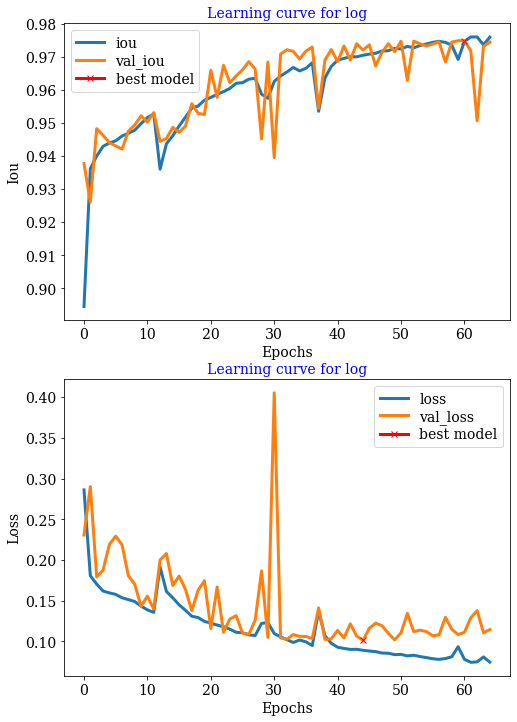

In [43]:
# plot the leaning curve
# you can make a change for legend regarding your project
plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
fig = plt.figure(figsize=(8, 12))
plt.subplot(2,1,1)
plt.title("Learning curve for log",fontsize=14, color="blue")
plt.plot(results.history["iou"], label="iou",linewidth=3)
plt.plot(results.history["val_iou"], label="val_iou",linewidth=3)
plt.plot( np.argmax(results.history["val_iou"]), np.max(results.history["val_iou"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Iou",fontsize=14)
plt.legend();
print(np.max(results.history["val_iou"]))

plt.subplot(2,1,2)

plt.title("Learning curve for log",fontsize=14, color="blue")
plt.plot(results.history["loss"], label="loss",linewidth=3)
plt.plot(results.history["val_loss"],label="val_loss",linewidth=3)
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.legend();
print(np.min(results.history["val_loss"]))
#0.8793798685073853 steel
#0.9789779186248779 steel iou
#0.9495388269424438 cardboard
#0.19808801025466047
#0.9162416458129883 homedepot
#0.2886759589485076
#0.9808236360549927 steel
#0.0798869830950235
#0.9931753277778625 log
#0.03263660343830654
#0.9979723691940308 log
#0.008322062255339008
#0.9981222152709961 lognew
#0.00738993662616198
# 0.9748544692993164 cardboard
# 0.10187775430284911
# 0.9351864457130432 homedepot
# 0.2829342065690618
# 0.9801501035690308 steel
# 0.08850873220497026

plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
plt.figure(figsize=(8, 8))
plt.title("Learning curve for steel",fontsize=14, color="blue")
plt.plot(results.history["accuracy"], label="accuracy",linewidth=3)
plt.plot(results.history["val_accuracy"], label="val_accuracy",linewidth=3)
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("log_loss",fontsize=14)
plt.legend();
print(np.max(results.history["val_accuracy"]))
#0.8793798685073853 steel

0.10121423750072196


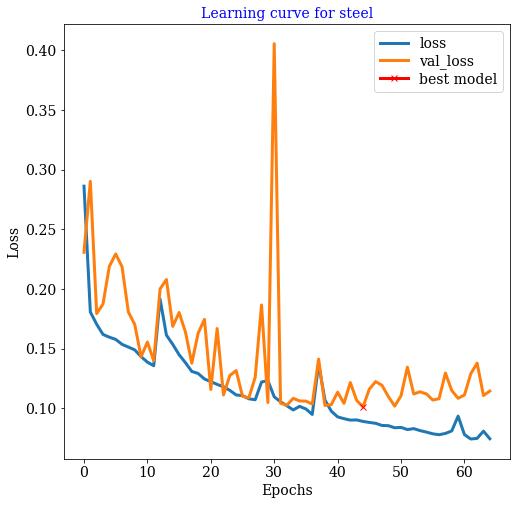

In [44]:
plt.rcParams.update({'font.size': 14, 'font.family': 'serif','legend.labelspacing':0.25,
                     'legend.fontsize': 14})
plt.figure(figsize=(8, 8))
plt.title("Learning curve for steel",fontsize=14, color="blue")
plt.plot(results.history["loss"], label="loss",linewidth=3)
plt.plot(results.history["val_loss"],label="val_loss",linewidth=3)
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model",linewidth=3)
plt.xlabel("Epochs",fontsize=14)
plt.ylabel("Loss",fontsize=14)
plt.legend();
print(np.min(results.history["val_loss"]))
#0.09378293198712456 steel
#0.09734031272371514 steel iou

In [45]:
import os
os.getcwd()

'C:\\Users\\mxie3'

In [114]:
# Predict on train, val and test
#model = load_model('model-dsbowl2018-2.h5',custom_objects={'iou': iou})
# when you are trying to predict new images, please make sure reload the test data set
# you just need to make a change for test_path
model = load_model(r'C:\Users\mxie3\model-log080623iou.h5',custom_objects={'iou': iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

3488/3488 [==============================] - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 11s 3ms/step


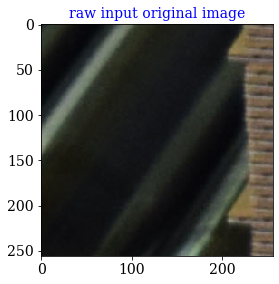

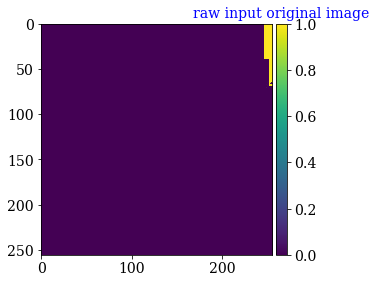

In [49]:
# Perform a sanity check on some random training samples
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
ix = random.randint(0, len(preds_train_t))
# fig = plt.figure(figsize=(6, 6))
imshow(X_train[ix])
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
# fig = plt.figure(figsize=(6, 6))
imshow(np.squeeze(Y_train[ix]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()

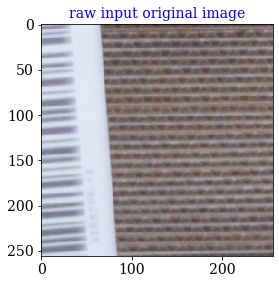

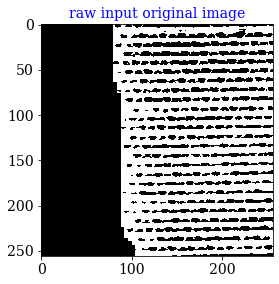

In [50]:
# Perform a sanity check on some random validation samples
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()

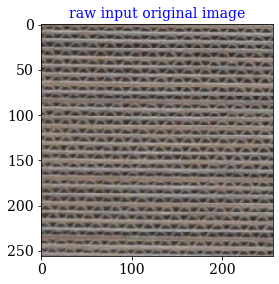

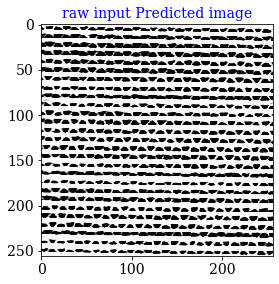

In [51]:
# Perform some checks on test images
plt.rcParams.update({'font.size': 14, 'font.family': 'serif'})
n = random.randint(0, len(test_ids))
imshow(np.squeeze(X_test[n]))
plt.title("raw input original image",fontsize=14, color="blue")
plt.show()
imshow(np.squeeze(preds_test[n]))
plt.title("raw input Predicted image",fontsize=14, color="blue")
plt.show()

In [115]:
#create two folders, one for original images, one for predicted iamges
import os
os.mkdir('D:/carboardin/')
os.mkdir('D:/carboardout/')

In [116]:
#batch predict the results
import skimage.io as io
for n, id_ in tqdm(enumerate(lione), total=len(test_ids)):
    path = TEST_PATH 
    img=np.squeeze(X_test[n])
    io.imsave('D:/carboardin/' + str(id_)+'.png', img)
    pred=np.squeeze(preds_test[n])
    io.imsave('D:/carboardout/' + str(id_)+'.png', pred)



  0%|                                                                                           | 0/63 [00:00<?, ?it/s]W0810 07:20:04.407059 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:04.608741 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

  2%|█▎                                                                                 | 1/63 [00:00<00:12,  4.87it/s]W0810 07:20:04.615781 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:04.670603 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:04.711843 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior t

 32%|██████████████████████████                                                        | 20/63 [00:02<00:04,  9.19it/s]W0810 07:20:06.661355 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:06.754811 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

 33%|███████████████████████████▎                                                      | 21/63 [00:02<00:04,  8.62it/s]W0810 07:20:06.794041 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:06.886596 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

 35%|████████████████████████████▋                                                     | 22/63 [00:02<00:04,  8.22it/s]W0810


 63%|████████████████████████████████████████████████████                              | 40/63 [00:04<00:02,  8.06it/s]W0810 07:20:09.027693 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:09.129788 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

 65%|█████████████████████████████████████████████████████▎                            | 41/63 [00:04<00:02,  8.17it/s]W0810 07:20:09.146388 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:09.206768 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:09.229904 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior t

W0810 07:20:11.137727 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

 97%|███████████████████████████████████████████████████████████████████████████████▍  | 61/63 [00:06<00:00,  9.92it/s]W0810 07:20:11.166395 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:11.211158 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:11.243850 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:11.287102 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

100%|███████████████████████████████████████████████████████████████████████████████

W0810 07:20:13.686321 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

85it [00:09,  9.30it/s]W0810 07:20:13.718008 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:13.798592 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

86it [00:09,  9.27it/s]W0810 07:20:13.828287 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:13.916806 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

87it [00:09,  9.02it/s]W0810 07:20:13.943965 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving 


109it [00:11,  9.94it/s]W0810 07:20:16.216929 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:16.271750 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:16.301425 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:16.355775 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

111it [00:11, 10.43it/s]W0810 07:20:16.386957 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:16.462399 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:20:19.000232 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

134it [00:14,  8.53it/s]W0810 07:20:19.032421 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:19.119431 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

135it [00:14,  8.52it/s]W0810 07:20:19.149629 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:19.274359 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

136it [00:14,  7.76it/s]W0810 07:20:19.305039 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


158it [00:17,  9.17it/s]W0810 07:20:21.851639 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:21.944179 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

159it [00:17,  8.69it/s]W0810 07:20:21.980895 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:22.090535 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

160it [00:17,  7.90it/s]W0810 07:20:22.134817 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:22.218308 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:20:24.866106 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

183it [00:20,  8.02it/s]W0810 07:20:24.900810 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:25.017493 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

184it [00:20,  7.86it/s]W0810 07:20:25.039623 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:25.144738 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

185it [00:20,  7.77it/s]W0810 07:20:25.166868 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:20:27.749526 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

207it [00:23,  8.39it/s]W0810 07:20:27.779198 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:27.979875 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

208it [00:23,  6.56it/s]W0810 07:20:28.008544 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:28.099072 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:28.105610 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni


231it [00:26,  7.58it/s]W0810 07:20:30.838128 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:30.937206 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

232it [00:26,  8.00it/s]W0810 07:20:30.943746 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:31.075014 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

233it [00:26,  7.76it/s]W0810 07:20:31.081553 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:31.193207 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:20:34.032226 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

256it [00:29,  8.06it/s]W0810 07:20:34.038764 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:34.134324 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

257it [00:29,  8.51it/s]W0810 07:20:34.140861 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:34.247990 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

258it [00:29,  8.57it/s]W0810 07:20:34.255534 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


280it [00:32,  7.43it/s]W0810 07:20:37.204342 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:37.394474 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

281it [00:32,  6.49it/s]W0810 07:20:37.404029 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:37.610758 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

282it [00:33,  5.80it/s]W0810 07:20:37.618805 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:37.789912 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

304it [00:36,  6.24it/s]W0810 07:20:40.874863 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:40.980983 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

305it [00:36,  6.86it/s]W0810 07:20:40.986515 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:41.174616 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

306it [00:36,  6.25it/s]W0810 07:20:41.180149 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:41.376297 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savin


328it [00:40,  6.67it/s]W0810 07:20:44.850345 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:44.975091 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

329it [00:40,  6.84it/s]W0810 07:20:44.987162 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:45.086745 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

330it [00:40,  7.26it/s]W0810 07:20:45.104851 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:45.192866 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:20:47.533725 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

353it [00:43,  9.87it/s]W0810 07:20:47.540264 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:47.590053 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:47.626265 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:47.681086 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

355it [00:43, 10.27it/s]W0810 07:20:47.715789 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:20:49.966767 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:49.984231 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:50.032514 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

379it [00:45, 10.33it/s]W0810 07:20:50.040058 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:50.114495 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:50.119315 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:50.213365

W0810 07:20:52.551237 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

403it [00:48,  9.00it/s]W0810 07:20:52.592979 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:52.650316 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

404it [00:48,  9.27it/s]W0810 07:20:52.693067 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:52.757445 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

405it [00:48,  9.29it/s]W0810 07:20:52.800194 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


427it [00:50,  8.92it/s]W0810 07:20:55.119493 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:55.168280 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:55.193428 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:55.240705 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

429it [00:50,  9.78it/s]W0810 07:20:55.277420 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:55.326708 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:20:57.797957 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

452it [00:53,  8.98it/s]W0810 07:20:57.834168 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:57.908605 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

453it [00:53,  9.07it/s]W0810 07:20:57.942302 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:20:58.017241 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

454it [00:53,  9.10it/s]W0810 07:20:58.050938 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:00.436577 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:00.501960 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

477it [00:56,  9.19it/s]W0810 07:21:00.534149 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:00.598023 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:00.632223 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:00.695667 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

479it [00:56,  9.44i

W0810 07:21:03.401127 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

501it [00:58,  7.15it/s]W0810 07:21:03.409174 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:03.522338 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

502it [00:59,  7.43it/s]W0810 07:21:03.531410 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:03.625462 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

503it [00:59,  7.91it/s]W0810 07:21:03.639041 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


525it [01:01,  7.47it/s]W0810 07:21:06.301788 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:06.403383 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

526it [01:01,  7.93it/s]W0810 07:21:06.409420 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:06.521072 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

527it [01:02,  8.10it/s]W0810 07:21:06.527611 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:06.663909 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


549it [01:05,  5.77it/s]W0810 07:21:09.741543 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:09.849678 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

550it [01:05,  6.39it/s]W0810 07:21:09.856719 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:09.976569 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

551it [01:05,  6.76it/s]W0810 07:21:09.984113 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:10.095768 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:13.116555 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

574it [01:08,  7.11it/s]W0810 07:21:13.125105 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:13.217647 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

575it [01:08,  7.76it/s]W0810 07:21:13.226701 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:13.328293 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

576it [01:08,  8.12it/s]W0810 07:21:13.334832 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:16.876780 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

598it [01:12,  6.01it/s]W0810 07:21:16.884324 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:17.021162 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

599it [01:12,  6.26it/s]W0810 07:21:17.028206 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:17.160481 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

600it [01:12,  6.50it/s]W0810 07:21:17.168529 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:20.117625 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:20.140827 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:20.217804 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

623it [01:15,  9.11it/s]W0810 07:21:20.243957 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:20.341026 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

624it [01:15,  8.86it/s]W0810 07:21:20.368823 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:21:22.691243 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

647it [01:18, 10.18it/s]W0810 07:21:22.720917 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:22.847659 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:22.862747 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:23.026710 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

649it [01:18,  8.62it/s]W0810 07:21:23.036767 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:21:25.222908 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:25.252080 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:25.425118 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

673it [01:21,  9.76it/s]W0810 07:21:25.432158 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:25.476982 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:25.501124 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:25.564997

W0810 07:21:27.767912 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

697it [01:23,  8.97it/s]W0810 07:21:27.781993 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:27.840337 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:27.864478 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:27.905217 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

699it [01:23,  9.92it/s]W0810 07:21:27.933383 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni

W0810 07:21:30.146316 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:30.181019 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:30.246402 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

723it [01:25,  9.90it/s]W0810 07:21:30.276075 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:30.346990 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:30.374169 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:30.447600

W0810 07:21:32.906534 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:32.938722 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:32.990526 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

748it [01:28,  9.12it/s]W0810 07:21:33.028247 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:33.088601 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

749it [01:28,  9.33it/s]W0810 07:21:33.129842 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni


771it [01:31,  7.58it/s]W0810 07:21:35.892611 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:35.963525 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

772it [01:31,  8.04it/s]W0810 07:21:35.999737 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:36.067132 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

773it [01:31,  8.39it/s]W0810 07:21:36.106362 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:36.179791 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:38.953036 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

796it [01:34,  7.63it/s]W0810 07:21:38.991283 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:39.043589 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:39.076280 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:39.142165 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

798it [01:34,  8.20it/s]W0810 07:21:39.192461 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warni


820it [01:38,  6.41it/s]W0810 07:21:43.114200 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:43.194696 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

821it [01:38,  6.87it/s]W0810 07:21:43.235525 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:43.306440 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

822it [01:38,  7.42it/s]W0810 07:21:43.344693 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:43.436229 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi

W0810 07:21:46.169587 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:46.194230 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:46.253577 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

846it [01:41,  8.63it/s]W0810 07:21:46.283755 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:46.339582 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:46.365232 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:46.425083


869it [01:46,  4.85it/s]W0810 07:21:50.984170 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:51.182478 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

870it [01:46,  4.85it/s]W0810 07:21:51.189520 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:51.409383 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

871it [01:47,  4.71it/s]W0810 07:21:51.417431 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:51.698253 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


893it [01:52,  4.07it/s]W0810 07:21:56.670722 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:56.916276 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

894it [01:52,  4.04it/s]W0810 07:21:56.923318 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:57.161714 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

895it [01:52,  4.05it/s]W0810 07:21:57.168254 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:21:57.422915 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


917it [01:57,  5.19it/s]W0810 07:22:01.691046 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:01.824347 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

918it [01:57,  5.65it/s]W0810 07:22:01.830886 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:01.957628 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

919it [01:57,  6.09it/s]W0810 07:22:01.964667 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:02.113038 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


941it [02:02,  4.73it/s]W0810 07:22:06.464180 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:06.704587 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

942it [02:02,  4.51it/s]W0810 07:22:06.710123 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:06.964680 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

943it [02:02,  4.21it/s]W0810 07:22:06.980330 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:07.233537 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


965it [02:07,  5.65it/s]W0810 07:22:11.411581 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:11.550894 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

966it [02:07,  5.94it/s]W0810 07:22:11.557935 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:11.712842 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

967it [02:07,  6.02it/s]W0810 07:22:11.719884 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:11.864732 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


989it [02:11,  5.22it/s]W0810 07:22:16.012132 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:16.212911 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

990it [02:11,  5.10it/s]W0810 07:22:16.218442 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:16.389947 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

991it [02:11,  5.25it/s]W0810 07:22:16.398497 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:16.600176 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to savi


1013it [02:15,  7.71it/s]W0810 07:22:19.838759 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:19.915206 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1014it [02:15,  8.07it/s]W0810 07:22:19.949911 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:20.018312 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1015it [02:15,  8.55it/s]W0810 07:22:20.050501 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:20.169196 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:22:22.695217 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:22.715335 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:22.762671 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1039it [02:18, 10.40it/s]W0810 07:22:22.791338 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:22.843646 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:22.871811 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:23.03023

W0810 07:22:25.938405 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1063it [02:21,  6.07it/s]W0810 07:22:25.949993 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:26.136625 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1064it [02:21,  5.74it/s]W0810 07:22:26.142661 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:26.268922 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1065it [02:21,  6.17it/s]W0810 07:22:26.277978 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

1087it [02:24,  9.51it/s]W0810 07:22:28.738320 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:28.784125 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:28.817319 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:29.030066 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1089it [02:24,  8.45it/s]W0810 07:22:29.035599 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:29.084381 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warn

W0810 07:22:32.172427 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1112it [02:27,  5.77it/s]W0810 07:22:32.178967 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:32.318890 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1113it [02:27,  6.04it/s]W0810 07:22:32.325931 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:32.374716 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:32.387793 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:22:35.096846 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1137it [02:30,  8.43it/s]W0810 07:22:35.102379 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:35.158205 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:35.174300 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:35.225097 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1139it [02:30,  9.73it/s]W0810 07:22:35.233647 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


1161it [02:33,  6.08it/s]W0810 07:22:38.292954 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:38.364370 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:38.373927 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:38.433274 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1163it [02:34,  7.17it/s]W0810 07:22:38.450374 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:38.507207 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:22:41.227277 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1186it [02:36,  8.13it/s]W0810 07:22:41.248401 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:41.356030 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1187it [02:36,  8.12it/s]W0810 07:22:41.371622 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:41.480761 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1188it [02:37,  8.18it/s]W0810 07:22:41.492329 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:22:45.154850 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1210it [02:40,  4.99it/s]W0810 07:22:45.159881 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:45.362062 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1211it [02:40,  4.94it/s]W0810 07:22:45.367094 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:45.568807 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1212it [02:41,  4.90it/s]W0810 07:22:45.575346 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:22:49.907119 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1234it [02:45,  5.16it/s]W0810 07:22:49.913660 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:50.083153 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1235it [02:45,  5.30it/s]W0810 07:22:50.091704 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:50.289360 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1236it [02:45,  5.17it/s]W0810 07:22:50.296402 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:22:54.617427 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1258it [02:50,  5.14it/s]W0810 07:22:54.624469 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:54.784942 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1259it [02:50,  5.37it/s]W0810 07:22:54.791482 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:54.958490 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1260it [02:50,  5.49it/s]W0810 07:22:54.964527 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:22:58.693452 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1282it [02:54,  6.74it/s]W0810 07:22:58.715079 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:58.813153 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1283it [02:54,  7.24it/s]W0810 07:22:58.828745 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:22:58.922315 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1284it [02:54,  7.70it/s]W0810 07:22:58.939918 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:02.078895 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1306it [02:57,  6.54it/s]W0810 07:23:02.085433 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:02.188034 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1307it [02:57,  7.10it/s]W0810 07:23:02.201613 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:02.316285 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1308it [02:57,  7.35it/s]W0810 07:23:02.322320 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:05.658985 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1330it [03:01,  6.86it/s]W0810 07:23:05.666528 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:05.770639 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1331it [03:01,  7.38it/s]W0810 07:23:05.778182 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:05.896375 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1332it [03:01,  7.55it/s]W0810 07:23:05.903918 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:09.288923 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1354it [03:04,  5.68it/s]W0810 07:23:09.296972 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:09.407142 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1355it [03:05,  6.33it/s]W0810 07:23:09.413176 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:09.559535 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1356it [03:05,  6.38it/s]W0810 07:23:09.566577 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:13.070819 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1378it [03:08,  5.94it/s]W0810 07:23:13.086913 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:13.224721 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1379it [03:08,  6.19it/s]W0810 07:23:13.230757 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:13.373089 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1380it [03:08,  6.34it/s]W0810 07:23:13.379629 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:16.883808 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:16.909459 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:16.961295 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1403it [03:12,  7.26it/s]W0810 07:23:16.978898 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:17.036778 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:17.046334 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:17.09662

W0810 07:23:18.896178 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1427it [03:14, 12.93it/s]W0810 07:23:18.916799 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:18.973631 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:18.993749 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:19.040020 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1429it [03:14, 13.17it/s]W0810 07:23:19.067179 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:23:20.905989 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:20.927113 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:20.969361 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1453it [03:16, 12.77it/s]W0810 07:23:20.992496 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:21.036756 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:21.059891 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:21.10616

W0810 07:23:22.911931 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1477it [03:18, 12.30it/s]W0810 07:23:22.934564 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:22.985362 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:23.005982 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:23.069545 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1479it [03:18, 12.41it/s]W0810 07:23:23.092177 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:23:25.070843 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:25.097500 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:25.136730 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1503it [03:20, 11.00it/s]W0810 07:23:25.165901 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:25.207142 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:25.234301 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:25.40982

W0810 07:23:27.292090 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1527it [03:22, 12.01it/s]W0810 07:23:27.308183 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:27.467115 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:27.474659 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:27.579653 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1529it [03:23,  9.94it/s]W0810 07:23:27.591223 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:23:29.457836 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:29.479463 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:29.636885 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1553it [03:25, 11.23it/s]W0810 07:23:29.642416 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:29.693216 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:29.717357 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:29.76865

W0810 07:23:32.103294 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1577it [03:27,  8.67it/s]W0810 07:23:32.110336 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:32.208913 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1578it [03:27,  8.87it/s]W0810 07:23:32.216457 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:32.311012 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1579it [03:27,  9.13it/s]W0810 07:23:32.318556 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


1601it [03:30, 10.52it/s]W0810 07:23:34.570948 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:34.628282 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:34.661980 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:34.718812 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1603it [03:30, 10.73it/s]W0810 07:23:34.747984 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:34.808840 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:23:37.513866 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1626it [03:33,  7.39it/s]W0810 07:23:37.519904 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:37.600426 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:37.605456 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:37.692464 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1628it [03:33,  8.22it/s]W0810 07:23:37.699505 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


1650it [03:36,  7.20it/s]W0810 07:23:40.592921 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:40.765430 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1651it [03:36,  6.64it/s]W0810 07:23:40.771466 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:40.920841 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1652it [03:36,  6.51it/s]W0810 07:23:40.931907 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:41.024449 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


1674it [03:39,  7.31it/s]W0810 07:23:43.843791 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:43.970029 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1675it [03:39,  7.37it/s]W0810 07:23:43.977071 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:44.179255 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1676it [03:39,  6.32it/s]W0810 07:23:44.187302 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:44.261738 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

1698it [03:42,  6.75it/s]W0810 07:23:47.172390 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:47.368538 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1699it [03:42,  6.09it/s]W0810 07:23:47.374073 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:47.511409 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1700it [03:43,  6.32it/s]W0810 07:23:47.518452 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:47.644690 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to sa


1722it [03:46,  6.75it/s]W0810 07:23:50.727429 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:50.897960 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1723it [03:46,  6.38it/s]W0810 07:23:50.905505 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:51.061465 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1724it [03:46,  6.28it/s]W0810 07:23:51.069511 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:51.198770 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:23:53.822243 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:53.861976 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1747it [03:49,  8.49it/s]W0810 07:23:53.891652 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:53.947979 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:53.969606 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:54.013362 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1749it [03:49,  9.4


1771it [03:51, 10.77it/s]W0810 07:23:56.070327 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:56.102516 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:56.135207 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:56.168402 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1773it [03:51, 11.93it/s]W0810 07:23:56.196063 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:56.239820 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:23:58.201045 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:58.244836 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1797it [03:53, 11.76it/s]W0810 07:23:58.269984 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:58.318265 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:58.337377 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:23:58.433941 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1799it [03:54, 11.5


1821it [03:55, 12.70it/s]W0810 07:24:00.341461 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:00.378679 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:00.407850 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:00.444565 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1823it [03:56, 13.33it/s]W0810 07:24:00.474741 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:00.511960 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:24:02.498193 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:02.598783 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1847it [03:58, 10.77it/s]W0810 07:24:02.612361 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:02.806531 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:02.812065 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:02.861414 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1849it [03:58,  9.5


1871it [04:00, 12.64it/s]W0810 07:24:04.707853 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:04.747083 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:04.773739 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:04.970412 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1873it [04:00, 10.38it/s]W0810 07:24:04.980471 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:05.025735 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:24:07.150524 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:07.204340 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1897it [04:02,  9.36it/s]W0810 07:24:07.224477 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:07.272300 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:07.293927 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:07.339192 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1899it [04:02, 10.5

W0810 07:24:11.109188 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1921it [04:06,  4.25it/s]W0810 07:24:11.121763 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:11.198207 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1922it [04:06,  4.96it/s]W0810 07:24:11.243975 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:11.315896 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1923it [04:06,  5.66it/s]W0810 07:24:11.362168 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:13.865009 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:13.933938 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1946it [04:09,  7.65it/s]W0810 07:24:13.952547 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:14.028491 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:14.045591 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:14.139138 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1948it [04:09,  8.1


1970it [04:12,  6.79it/s]W0810 07:24:17.011237 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:17.070080 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:17.099251 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:17.158596 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1972it [04:12,  7.73it/s]W0810 07:24:17.185755 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:17.243594 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:24:20.196706 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1995it [04:15,  7.42it/s]W0810 07:24:20.212297 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:20.383297 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1996it [04:15,  6.71it/s]W0810 07:24:20.394864 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:20.561339 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

1997it [04:16,  6.39it/s]W0810 07:24:20.568381 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:24.912964 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2019it [04:20,  4.52it/s]W0810 07:24:24.918495 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:25.066919 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2020it [04:20,  4.94it/s]W0810 07:24:25.076475 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:25.200236 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2021it [04:20,  5.49it/s]W0810 07:24:25.212307 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:29.326339 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2043it [04:24,  5.72it/s]W0810 07:24:29.336902 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:29.516954 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2044it [04:25,  5.58it/s]W0810 07:24:29.525001 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:29.737247 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2045it [04:25,  5.24it/s]W0810 07:24:29.742277 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:34.160525 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2067it [04:29,  4.61it/s]W0810 07:24:34.167065 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:34.309400 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2068it [04:29,  5.08it/s]W0810 07:24:34.319457 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:34.418536 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2069it [04:30,  5.85it/s]W0810 07:24:34.431611 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:38.459255 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2091it [04:34,  6.76it/s]W0810 07:24:38.467805 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:38.626769 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2092it [04:34,  6.53it/s]W0810 07:24:38.633811 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:38.806859 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2093it [04:34,  6.16it/s]W0810 07:24:38.817926 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:41.337447 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:41.380701 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2116it [04:36,  9.65it/s]W0810 07:24:41.408866 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:41.476261 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:41.499899 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:41.547173 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2118it [04:37, 10.0

W0810 07:24:44.385480 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2140it [04:39,  6.52it/s]W0810 07:24:44.393025 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:44.509206 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2141it [04:40,  6.78it/s]W0810 07:24:44.528821 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:44.617339 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2142it [04:40,  7.11it/s]W0810 07:24:44.650534 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:47.682711 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2164it [04:43,  7.89it/s]W0810 07:24:47.710373 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:47.884408 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2165it [04:43,  6.94it/s]W0810 07:24:47.891449 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:48.080053 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2166it [04:43,  6.27it/s]W0810 07:24:48.091117 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:51.386010 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2188it [04:47,  6.77it/s]W0810 07:24:51.435299 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:51.532367 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2189it [04:47,  6.76it/s]W0810 07:24:51.582664 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:51.673697 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2190it [04:47,  7.06it/s]W0810 07:24:51.708399 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:54.848376 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2212it [04:50,  7.63it/s]W0810 07:24:54.867488 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:54.998759 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2213it [04:50,  7.45it/s]W0810 07:24:55.008818 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:55.180823 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2214it [04:50,  6.77it/s]W0810 07:24:55.188369 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:24:58.445786 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2236it [04:54,  6.74it/s]W0810 07:24:58.489039 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:58.587615 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2237it [04:54,  6.81it/s]W0810 07:24:58.634389 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:24:58.730955 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2238it [04:54,  7.01it/s]W0810 07:24:58.763646 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:01.923308 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2260it [04:57,  7.44it/s]W0810 07:25:01.941414 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:02.089299 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2261it [04:57,  7.11it/s]W0810 07:25:02.096843 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:02.270377 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2262it [04:57,  6.56it/s]W0810 07:25:02.276414 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:05.696882 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2284it [05:01,  6.33it/s]W0810 07:25:05.744158 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:05.851286 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2285it [05:01,  6.50it/s]W0810 07:25:05.887499 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:05.999655 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2286it [05:01,  6.58it/s]W0810 07:25:06.035365 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:09.949884 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2308it [05:05,  5.83it/s]W0810 07:25:09.961452 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:10.105294 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2309it [05:05,  6.04it/s]W0810 07:25:10.112335 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:10.290881 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2310it [05:05,  5.81it/s]W0810 07:25:10.299935 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:14.366601 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2332it [05:09,  4.71it/s]W0810 07:25:14.373142 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:14.586597 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2333it [05:10,  4.66it/s]W0810 07:25:14.591626 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:14.830034 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2334it [05:10,  4.47it/s]W0810 07:25:14.840595 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:19.590465 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2356it [05:15,  4.98it/s]W0810 07:25:19.599054 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:19.789155 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2357it [05:15,  5.00it/s]W0810 07:25:19.796196 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:19.991393 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2358it [05:15,  4.98it/s]W0810 07:25:19.998937 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:24.981184 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2380it [05:20,  4.15it/s]W0810 07:25:24.993258 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:25.230454 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2381it [05:20,  4.13it/s]W0810 07:25:25.236490 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:25.469877 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2382it [05:21,  4.14it/s]W0810 07:25:25.476918 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:29.680233 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2404it [05:25,  5.73it/s]W0810 07:25:29.693812 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:29.781325 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2405it [05:25,  6.55it/s]W0810 07:25:29.794402 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:29.885938 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:29.892979 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:25:33.835618 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2428it [05:29,  5.77it/s]W0810 07:25:33.841152 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:34.080185 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2429it [05:29,  5.10it/s]W0810 07:25:34.094269 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:34.339527 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2430it [05:29,  4.67it/s]W0810 07:25:34.347066 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:38.422320 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2452it [05:34,  6.08it/s]W0810 07:25:38.430870 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:38.528441 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2453it [05:34,  6.80it/s]W0810 07:25:38.541015 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:38.664741 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2454it [05:34,  6.91it/s]W0810 07:25:38.679829 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:42.417388 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2476it [05:38,  6.23it/s]W0810 07:25:42.425436 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:42.610540 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2477it [05:38,  5.88it/s]W0810 07:25:42.617582 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:42.787093 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2478it [05:38,  5.82it/s]W0810 07:25:42.794134 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:46.249567 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2500it [05:41,  7.24it/s]W0810 07:25:46.264153 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:46.387375 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2501it [05:41,  7.37it/s]W0810 07:25:46.394416 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:46.511602 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2502it [05:42,  7.55it/s]W0810 07:25:46.519145 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:25:49.566446 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:49.606681 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2525it [05:45,  7.50it/s]W0810 07:25:49.628811 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:49.672064 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:49.691679 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:49.727890 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2527it [05:45,  8.9

W0810 07:25:52.246921 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:52.452625 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2550it [05:48,  8.42it/s]W0810 07:25:52.460171 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:52.652863 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2551it [05:48,  7.01it/s]W0810 07:25:52.658900 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:52.831459 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


2574it [05:51,  8.07it/s]W0810 07:25:55.501946 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:55.532123 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:55.564311 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:55.597506 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2576it [05:51,  9.54it/s]W0810 07:25:55.622150 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:55.838983 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


2599it [05:54,  6.56it/s]W0810 07:25:58.694370 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:58.897609 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2600it [05:54,  5.90it/s]W0810 07:25:58.903645 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:59.137545 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2601it [05:54,  5.25it/s]W0810 07:25:59.143580 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:25:59.282899 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:26:01.787104 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2624it [05:57,  8.84it/s]W0810 07:26:01.812756 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:02.044652 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:02.049178 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:02.095983 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2626it [05:57,  7.97it/s]W0810 07:26:02.121635 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

2648it [06:00,  6.03it/s]W0810 07:26:05.044777 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:05.176590 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2649it [06:00,  6.23it/s]W0810 07:26:05.193187 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:05.360733 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2650it [06:00,  6.04it/s]W0810 07:26:05.370291 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:05.434703 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to sa

W0810 07:26:08.123152 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2673it [06:03,  6.97it/s]W0810 07:26:08.128187 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:08.349534 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2674it [06:03,  5.91it/s]W0810 07:26:08.358079 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:08.527249 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2675it [06:04,  5.75it/s]W0810 07:26:08.543344 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:26:12.445596 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2697it [06:08,  5.53it/s]W0810 07:26:12.453140 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:12.626153 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2698it [06:08,  5.48it/s]W0810 07:26:12.640738 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:12.715174 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:12.734285 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


2721it [06:11,  6.89it/s]W0810 07:26:15.497302 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:15.577773 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2722it [06:11,  7.55it/s]W0810 07:26:15.600908 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:15.674840 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:15.692444 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:15.767884 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


2745it [06:14,  4.96it/s]W0810 07:26:19.125275 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:19.309355 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2746it [06:14,  5.03it/s]W0810 07:26:19.317403 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:19.436622 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2747it [06:15,  5.46it/s]W0810 07:26:19.464679 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:19.575330 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


2769it [06:18,  6.19it/s]W0810 07:26:22.869643 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:23.085172 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2770it [06:18,  5.54it/s]W0810 07:26:23.092216 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:23.213924 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2771it [06:18,  5.97it/s]W0810 07:26:23.229515 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:23.347204 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


2793it [06:22,  5.19it/s]W0810 07:26:27.220694 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:27.452587 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2794it [06:23,  4.83it/s]W0810 07:26:27.460673 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:27.686506 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2795it [06:23,  4.65it/s]W0810 07:26:27.695052 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:27.863538 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


2817it [06:27,  5.09it/s]W0810 07:26:31.862709 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:31.916169 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:31.931797 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:31.992230 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2819it [06:27,  6.25it/s]W0810 07:26:32.012349 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:32.069182 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:35.513688 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2842it [06:31,  5.21it/s]W0810 07:26:35.523747 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:35.637916 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2843it [06:31,  5.74it/s]W0810 07:26:35.655518 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:35.723417 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:35.738505 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:38.562651 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:38.605402 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2867it [06:34,  8.90it/s]W0810 07:26:38.630046 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:38.672796 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:38.707499 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:38.752262 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2869it [06:34,  9.7

W0810 07:26:41.957301 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2891it [06:37,  5.85it/s]W0810 07:26:41.975407 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:42.061914 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2892it [06:37,  6.44it/s]W0810 07:26:42.093599 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:42.138864 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:42.156969 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:44.239970 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2916it [06:39, 10.61it/s]W0810 07:26:44.269644 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:44.328515 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:44.360200 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:44.413512 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2918it [06:40, 10.83it/s]W0810 07:26:44.445701 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:46.838226 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2941it [06:42,  8.99it/s]W0810 07:26:46.859852 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:46.912663 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:46.930289 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:46.982595 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2943it [06:42, 10.07it/s]W0810 07:26:47.003216 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:49.548521 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2966it [06:45,  9.67it/s]W0810 07:26:49.576184 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:49.644586 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:49.673254 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:49.821623 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2968it [06:45,  9.04it/s]W0810 07:26:49.831177 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:26:52.840143 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:52.906028 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2991it [06:48,  7.16it/s]W0810 07:26:52.931220 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:53.000123 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

2992it [06:48,  7.49it/s]W0810 07:26:53.050921 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:53.238520 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


3014it [06:51,  7.43it/s]W0810 07:26:56.253269 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:56.372972 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3015it [06:51,  7.33it/s]W0810 07:26:56.393593 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:56.572139 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3016it [06:52,  6.57it/s]W0810 07:26:56.583205 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:56.775326 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:26:59.433598 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3039it [06:55, 10.30it/s]W0810 07:26:59.463272 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:59.510046 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:59.538714 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:26:59.755484 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3041it [06:55,  8.82it/s]W0810 07:26:59.767554 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:27:01.868190 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:01.877746 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:01.983365 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3065it [06:57,  9.73it/s]W0810 07:27:01.998955 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:02.066879 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:02.079956 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:02.13833

W0810 07:27:04.195543 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3089it [06:59, 10.45it/s]W0810 07:27:04.201578 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:04.251873 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:04.284564 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:04.326811 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3091it [06:59, 11.07it/s]W0810 07:27:04.356988 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:27:06.414071 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:06.435734 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:06.485526 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3115it [07:02, 11.03it/s]W0810 07:27:06.512685 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:06.552920 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:06.583600 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:06.62283

W0810 07:27:08.793223 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3139it [07:04, 10.54it/s]W0810 07:27:08.822933 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:08.867695 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:08.889825 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:08.938611 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3141it [07:04, 11.45it/s]W0810 07:27:08.962249 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

W0810 07:27:11.036423 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:11.058050 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:11.100297 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3165it [07:06, 11.83it/s]W0810 07:27:11.117397 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:11.156628 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:11.179327 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:11.21956

W0810 07:27:13.848564 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3189it [07:09,  9.53it/s]W0810 07:27:13.869686 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:14.051753 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:14.055274 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:14.244395 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3191it [07:09,  7.66it/s]W0810 07:27:14.249424 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


3213it [07:13,  5.88it/s]W0810 07:27:17.643920 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:17.774684 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3214it [07:13,  6.17it/s]W0810 07:27:17.787258 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:17.915030 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3215it [07:13,  6.45it/s]W0810 07:27:17.926094 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:18.064906 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3237it [07:17,  5.27it/s]W0810 07:27:22.241431 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:22.436071 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3238it [07:18,  5.19it/s]W0810 07:27:22.441603 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:22.641273 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3239it [07:18,  5.09it/s]W0810 07:27:22.646303 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:22.839939 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3261it [07:22,  4.82it/s]W0810 07:27:27.174870 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:27.363974 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3262it [07:22,  4.90it/s]W0810 07:27:27.373029 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:27.550094 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3263it [07:23,  5.04it/s]W0810 07:27:27.558645 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:27.727660 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3285it [07:27,  5.67it/s]W0810 07:27:31.568874 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:31.768543 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3286it [07:27,  5.38it/s]W0810 07:27:31.773070 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:31.981702 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3287it [07:27,  5.16it/s]W0810 07:27:31.986225 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:32.197022 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3309it [07:31,  5.85it/s]W0810 07:27:35.863299 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:36.022732 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3310it [07:31,  5.89it/s]W0810 07:27:36.029271 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:36.167078 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3311it [07:31,  6.17it/s]W0810 07:27:36.173616 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:36.279297 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3333it [07:35,  6.27it/s]W0810 07:27:39.836690 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:39.954379 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3334it [07:35,  6.65it/s]W0810 07:27:39.963935 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:40.114026 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3335it [07:35,  6.57it/s]W0810 07:27:40.122351 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:40.293352 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3357it [07:39,  6.99it/s]W0810 07:27:43.656787 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:43.763957 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3358it [07:39,  7.41it/s]W0810 07:27:43.772512 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:43.871084 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3359it [07:39,  7.89it/s]W0810 07:27:43.880137 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:43.978211 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3381it [07:42,  7.31it/s]W0810 07:27:46.913982 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:47.086522 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3382it [07:42,  6.63it/s]W0810 07:27:47.097587 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:47.301280 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3383it [07:42,  5.95it/s]W0810 07:27:47.306813 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:47.490890 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

W0810 07:27:50.208761 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:50.229886 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:50.305830 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3407it [07:45,  8.49it/s]W0810 07:27:50.325445 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:50.400384 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:50.417987 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:50.56423

W0810 07:27:53.232331 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3431it [07:48,  7.49it/s]W0810 07:27:53.238365 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:53.418923 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3432it [07:49,  6.70it/s]W0810 07:27:53.424958 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:53.612557 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3433it [07:49,  6.14it/s]W0810 07:27:53.619598 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s


3455it [07:52,  8.08it/s]W0810 07:27:56.412697 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:56.463998 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:56.477577 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:56.683374 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3457it [07:52,  7.81it/s]W0810 07:27:56.688404 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:56.741715 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war


3480it [07:55,  6.72it/s]W0810 07:27:59.613955 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:27:59.832295 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3481it [07:55,  5.83it/s]W0810 07:27:59.838325 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:28:00.051597 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.

3482it [07:55,  5.39it/s]W0810 07:28:00.056627 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
W0810 07:28:00.209526 10576 util.py:64] Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to s

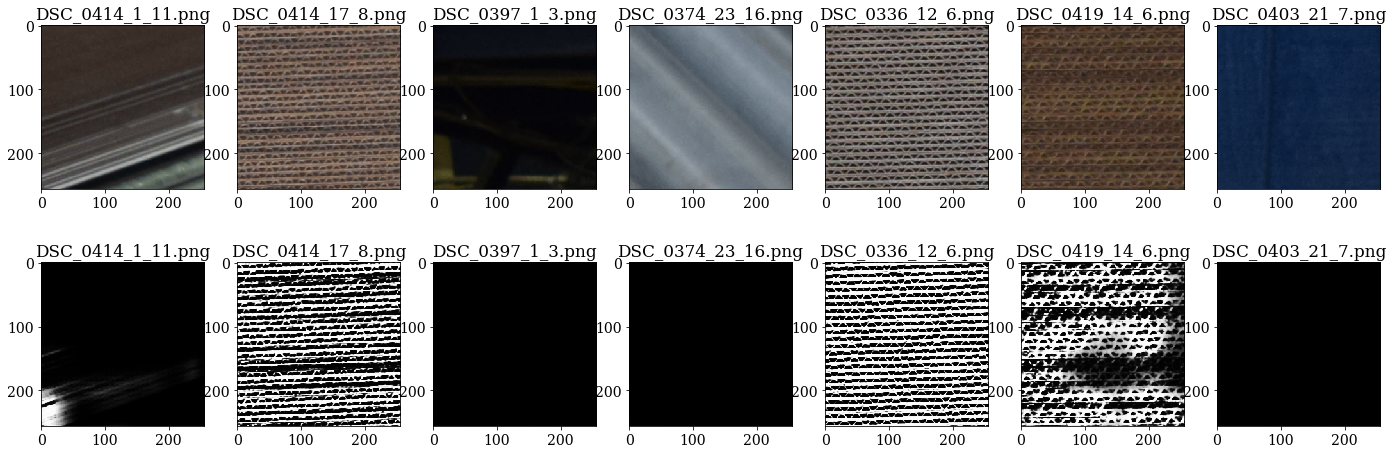

In [117]:
# randomly show some predicted results
train_test_path = "D:/carboardin/"
train_pred_path = 'D:/carboardout/'
 
image_array = []
 
for root, dirs, files in os.walk(train_test_path): 
    image_array = files

col_size = 7
row_size = 2
 
rand_id_array = random.sample(range(0, len(image_array)), col_size)
 
fig, ax = plt.subplots(row_size, col_size, figsize=(24,8))  
 
for row in range(0,row_size): 
    image_index = 0
    if (row==0): 
        da_path= train_test_path
    else: 
        da_path= train_pred_path
 
    for col in range(0,col_size):
        img = load_img(da_path+image_array[rand_id_array[image_index]])
        ax[row][col].imshow(img)
        ax[row][col].set_title(image_array[rand_id_array[image_index]])
        image_index += 1
plt.show()

In [129]:
#create some foder to combine all chunks back to one image
import os
os.mkdir('D:/Out01/test01')
os.mkdir('D:/Out01/test02')
os.mkdir('D:/Out01/test03')
os.mkdir('D:/Out01/test04')
os.mkdir('D:/Out01/test05')
os.mkdir('D:/Out01/test06')
os.mkdir('D:/Out01/test07')
os.mkdir('D:/Out01/test08')

In [135]:
# filelist=['DSC_0324','DSC_0326','DSC_0336','DSC_0374','DSC_0397','DSC_0400','DSC_0403','DSC_0414','DSC_0419','DSC_0435']
os.chdir('D:/image')
list_im = os.listdir('D:/image')
filelist=[i.split('.')[0] for i in list_im]

In [145]:
# filelist=['DSC_0324','DSC_0326','DSC_0336','DSC_0374','DSC_0397','DSC_0400','DSC_0403','DSC_0414','DSC_0419','DSC_0435']
import shutil
os.chdir('D:/carboardout')
list_im = os.listdir('D:/carboardout')
for i in list_im:
    filename='_'.join([i.split('_')[0],i.split('_')[1]])
    if filename == 'DSC_0324':
        shutil.copy2('D:/carboardout/'+str(i), 'D:/Out01/test08/' ) # target filename is D:/Out01/test08/

In [146]:
import cv2
import numpy as np
import imageio
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy import misc
import scipy.misc
import scipy
import image_slicer
from image_slicer import join
from PIL import Image
import numpy as np
import PIL

In [147]:
os.chdir('D:/Out01/test08')
list_im = os.listdir('D:/Out01/test08')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
dim=set([ i.split('_')[2] for i in list_im])

list=[i.split('.')[0] for i in list_im]

list1=sorted(list,key=lambda x:(int(x.split('_')[2]),int(x.split('_')[3])))
# Have to sort the picture, otherwise will get wrong order pictures
for j in range(1,len(dim)+1):
    imgs=[]
    for i in list1:
        if i.split('_')[2]==str(j):
            img = PIL.Image.open(i+'.png')
            imgs.append(img)
            # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
            min_shape = sorted( [(np.sum(h.size), h.size ) for h in imgs])[0][1]
            # for a vertical stacking it is simple: use vstack
            imgs_comb = np.vstack((np.asarray( t.resize(min_shape) ) for t in imgs ))
            imgs_comb = PIL.Image.fromarray( imgs_comb)
            imgs_comb.save( 'D:/Out01/test03/'+filename+ str(j)+'.png' )           


C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


In [148]:
os.chdir('D:/Out01/test03')
list_im = os.listdir('D:/Out01/test03')
list=[i.split('.')[0] for i in list_im]
list1=sorted(list,key=lambda x:int(x.split('_')[1]))
imgs = [ PIL.Image.open(i+'.png') for i in list1 ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(h.size), h.size ) for h in imgs])[0][1]
# for a horizontal  stacking it is simple: use hstack
imgs_comb = np.hstack((np.asarray( t.resize(min_shape) ) for t in imgs ))
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test04/'+filename+'.png' )  

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if __name__ == '__main__':


In [149]:
from math import remainder
remainder(4000,256)
import cv2
image = cv2.imread('D:/unet4paper/cardboard/predict/image/DSC_0324.jpg')
size_x = image.shape[1]
size_y = image.shape[0]
w=256*(size_x//256)
h=256*(size_y//256)
dx=size_x - w
dy=size_y - h
dx,dy


(94, 143)

In [150]:
# Remove the overlap for horizontal
import cv2
import os

dirpath = 'D:/Out01/test04/'
destDirectory = 'D:/Out01/test05/'
for file in os.listdir(dirpath):
    image = cv2.imread(os.path.join(dirpath, file))
    #image = cv2.imread(os.path.join(dirpath, file), cv2.IMREAD_GRAYSCALE)
    size = image.shape[1]
    s_thresh = image[:, (size-dx):size]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(2) + '.png', s_thresh)

    s_thresh = image[:, 0:w]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(1) + '.png', s_thresh)


In [152]:
# Remove the overlap for horizontal
os.chdir('D:/Out01/test05')
list_im = os.listdir('D:/Out01/test05')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
imgs = [ PIL.Image.open(i) for i in list_im ]
# for a horizontal  stacking it is simple: use hstack
imgs_comb = np.hstack( (np.asarray( t ) for t in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test06/'+filename+'.png') 

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys


In [153]:
# Remove the overlap for vetical
import cv2
import os
dirpath = 'D:/Out01/test06/'
destDirectory = 'D:/Out01/test07/'
for file in os.listdir(dirpath):
    image = cv2.imread(os.path.join(dirpath, file))
    #image = cv2.imread(os.path.join(dirpath, file), cv2.IMREAD_GRAYSCALE)
    size = image.shape[0]
    s_thresh = image[(size-dy):size,:]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(2) + '.png', s_thresh)

    s_thresh = image[0:h,:]
    cv2.imwrite(os.path.join(destDirectory, os.path.splitext(file)[0]) + '_' + str(1) + '.png', s_thresh)


In [156]:
# Remove the overlap for vetical
os.chdir('D:/Out01/test07')
list_im = os.listdir('D:/Out01/test07')
filename='_'.join([list_im[0].split('_')[0],list_im[0].split('_')[1]])
imgs = [ PIL.Image.open(i) for i in list_im ]
# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( t ) for t in imgs ) )
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'D:/Out01/test01/'+filename+'.png') 

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  import sys
